# 라이브러리 임포트

In [8]:
import pandas as pd
import numpy as np
import openpyxl
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

# 한글폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 데이터 출력 생략 없애기
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [9]:
import torch
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [13]:
data_root = '/root/ML-Regression/Competition/data/'

# 데이터 불러오기

In [14]:
locate_train_df = pd.read_csv(data_root + 'locate_train_preprocessed.csv')
locate_test_df = pd.read_csv(data_root + 'locate_test_preprocessed.csv')

In [15]:
display(locate_train_df.tail(2))
display(locate_test_df.head(2))

print(locate_train_df.shape)
print(locate_test_df.shape)

,주소,target,아파트명,번지,500m이내 버스정류장 수,본번,부번,75m이내 초등학교여부,성취도,50m이내 중학교여부,100m이내 중학교여부,75m이내 중학교여부,대치목동 여부,좌표Y,50m이내 초등학교여부,좌표X,100m이내 초등학교여부,시군구,기본금리,로얄층,도로명,건축년도,층,계약일,계약년월,전용면적,is_test
568329,서울특별시 구로구 개봉동 476,34900.0,한마을,476,18.0,476.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,37.495303,0.0,126.862409,0.0,서울특별시 구로구 개봉동,1.25,2.772589,경인로 382,1999.0,11.0,18.0,201606.0,59.57,0
568330,서울특별시 구로구 개봉동 476,37500.0,한마을,476,18.0,476.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,37.495303,0.0,126.862409,0.0,서울특별시 구로구 개봉동,1.25,3.401197,경인로 382,1999.0,25.0,18.0,201606.0,84.57,0


,주소,target,아파트명,번지,500m이내 버스정류장 수,본번,부번,75m이내 초등학교여부,성취도,50m이내 중학교여부,100m이내 중학교여부,75m이내 중학교여부,대치목동 여부,좌표Y,50m이내 초등학교여부,좌표X,100m이내 초등학교여부,시군구,기본금리,로얄층,도로명,건축년도,층,계약일,계약년월,전용면적
0,NaN,NaN,개포6차우성,658-1,12.0,658.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,37.476151,0.0,127.057213,1.0,서울특별시 강남구 개포동,3.5,2.302585,언주로 3,1987.0,5.0,26.0,202307.0,79.9700
1,NaN,NaN,개포더샵트리에,651-1,15.0,651.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,37.484745,1.0,127.057283,0.0,서울특별시 강남구 개포동,3.5,2.708050,개포로 311,2021.0,10.0,15.0,202308.0,108.2017


(568331, 27)
(9272, 26)


# 데이터 병합
- locate_XXX_df 데이터는 내가 선별한 데이터
    - 팀원들의 모든 데이터 병합 후 6~70% 이상 데이터 `drop`
    - 일부 데이터 `drop`

In [16]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
locate_train_df['is_test'] = 0
locate_test_df['is_test'] = 1
concat = pd.concat([locate_train_df, locate_test_df])     # 하나의 데이터로 만들어줍니다.

In [17]:
# 결측치 백분율로 표시
percent = concat.isnull().sum() / len(concat) * 100
pd.DataFrame({'percent': percent}).sort_values('percent', ascending=False)

,percent
주소,1.605255
target,1.605255
500m이내 버스정류장 수,0.012638
아파트명,0.001731
번지,0.000346
100m이내 초등학교여부,0.000000
전용면적,0.000000
계약년월,0.000000
계약일,0.000000
층,0.000000


# Feature Engineering

## 데이터 전처리
1. 시군구 분리
2. 계약년월 -> 계약년월일(datetime)

In [18]:
# 시, 군, 구 분리
concat['시'] = concat['시군구'].apply(lambda x: x.split()[0])
concat['구'] = concat['시군구'].apply(lambda x: x.split()[1])
concat['동'] = concat['시군구'].apply(lambda x: x.split()[2])
# concat.drop('시군구', axis=1, inplace=True)

In [19]:
concat['계약년월'] = concat['계약년월'].astype(int).astype(str) # 소수점 제거 후 문자열로 변환

concat['계약년'] = concat['계약년월'].str[:4]
concat['계약월'] = concat['계약년월'].str[4:]
concat['계약일'] = concat['계약일'].astype(int).astype(str).str.zfill(2)

concat['계약년월일'] = concat['계약년'] + '-' + concat['계약월'] + '-' + concat['계약일']
concat['계약년월일'] = pd.to_datetime(concat['계약년월일'], format='%Y-%m-%d')

# 숫자형으로 변환
concat['계약년'] = concat['계약년'].astype(int)
concat['계약월'] = concat['계약월'].astype(int)
concat['계약일'] = concat['계약일'].astype(int)

## 파생변수
1. 강남여부
2. 신축아파트
3. 아파트 수명
4. 탑급아파트

In [20]:
gangnam = ['서초구', '강남구', '용산구', '송파구', '성동구']
concat['강남여부'] = concat['구'].apply(lambda x: 1 if x in gangnam else 0)

In [21]:
concat['신축아파트'] = concat['계약년'].apply(lambda x: 1 if x >= 2012 else 0)

In [22]:
# 연차 변수 생성 (2023-계약년도+1)
concat['아파트수명'] = 2023 - concat['건축년도'].astype(int) + 1

In [23]:
top_apartment_name = [
    '자이', '래미안', '파크', '더퍼스트', '센트럴', '포레', 
    '메트로', '에듀', '시티', '힐스테이트', '아이파크', '트리마제',
    '더샵', '더힐', '그랑자이', '아크로', '푸르지오'
]
concat['탑급아파트'] =concat['아파트명'].apply(lambda x: 1 if x in top_apartment_name else 0)

## 결측치 처리

In [24]:
concat.isnull().sum()

주소                9272
target            9272
아파트명                10
번지                   2
500m이내 버스정류장 수      73
본번                   0
부번                   0
75m이내 초등학교여부         0
성취도                  0
50m이내 중학교여부          0
100m이내 중학교여부         0
75m이내 중학교여부          0
대치목동 여부              0
좌표Y                  0
50m이내 초등학교여부         0
좌표X                  0
100m이내 초등학교여부        0
시군구                  0
기본금리                 0
로얄층                  0
도로명                  0
건축년도                 0
층                    0
계약일                  0
계약년월                 0
전용면적                 0
is_test              0
시                    0
구                    0
동                    0
계약년                  0
계약월                  0
계약년월일                0
강남여부                 0
신축아파트                0
아파트수명                0
탑급아파트                0
dtype: int64

In [25]:
concat.drop(['주소', '500m이내 버스정류장 수'], axis=1, inplace=True)

In [26]:
# 아파트명 결측치 처리
concat['아파트명'] = concat['아파트명'].fillna('아파트명없음')

# 번지 결측치 처리
concat['번지'] = concat['번지'].fillna(0)

# 결측치 확인
concat.isnull().sum()

target           9272
아파트명                0
번지                  0
본번                  0
부번                  0
75m이내 초등학교여부        0
성취도                 0
50m이내 중학교여부         0
100m이내 중학교여부        0
75m이내 중학교여부         0
대치목동 여부             0
좌표Y                 0
50m이내 초등학교여부        0
좌표X                 0
100m이내 초등학교여부       0
시군구                 0
기본금리                0
로얄층                 0
도로명                 0
건축년도                0
층                   0
계약일                 0
계약년월                0
전용면적                0
is_test             0
시                   0
구                   0
동                   0
계약년                 0
계약월                 0
계약년월일               0
강남여부                0
신축아파트               0
아파트수명               0
탑급아파트               0
dtype: int64

In [27]:
# 계약년도 2020년 이전 데이터 제거
concat = concat[concat['계약년'] >= 2020]

# 차원축소
- `groupby`
- 데이터의 특성을 파악하여 차원축소

In [28]:
stats = concat.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
concat = concat.join(stats, on=['계약년', '구'], rsuffix='_target')

In [29]:
concat['계약년과구(std)'] = concat['std']
concat['계약년과구(mean)'] = concat['mean']
concat['계약년과구(max)'] = concat['max']
concat.drop(['std', 'mean', 'max'], axis=1, inplace=True)
concat.head(1)

,target,아파트명,번지,본번,부번,75m이내 초등학교여부,성취도,50m이내 중학교여부,100m이내 중학교여부,75m이내 중학교여부,대치목동 여부,좌표Y,50m이내 초등학교여부,좌표X,100m이내 초등학교여부,시군구,기본금리,로얄층,도로명,건축년도,층,계약일,계약년월,전용면적,is_test,시,구,동,계약년,계약월,계약년월일,강남여부,신축아파트,아파트수명,탑급아파트,계약년과구(std),계약년과구(mean),계약년과구(max)
200689,240000.0,개포더샵트리에,651-1,651.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,37.484745,1.0,127.057283,0.0,서울특별시 강남구 개포동,3.5,2.564949,개포로 311,2021.0,8.0,29,202306,105.8064,0,서울특별시,강남구,개포동,2023,6,2023-06-29,1,1,3,0,112608.321949,207993.469722,900000.0


In [30]:
stats = concat.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
concat = concat.join(stats, on=['계약년', '동'], rsuffix='_target')

In [31]:
concat['계약년과동(std)'] = concat['std']
concat['계약년과동(mean)'] = concat['mean']
concat['계약년과동(max)'] = concat['max']
concat.drop(['std', 'mean', 'max'], axis=1, inplace=True)
concat.head(1)

,target,아파트명,번지,본번,부번,75m이내 초등학교여부,성취도,50m이내 중학교여부,100m이내 중학교여부,75m이내 중학교여부,대치목동 여부,좌표Y,50m이내 초등학교여부,좌표X,100m이내 초등학교여부,시군구,기본금리,로얄층,도로명,건축년도,층,계약일,계약년월,전용면적,is_test,시,구,동,계약년,계약월,계약년월일,강남여부,신축아파트,아파트수명,탑급아파트,계약년과구(std),계약년과구(mean),계약년과구(max),계약년과동(std),계약년과동(mean),계약년과동(max)
200689,240000.0,개포더샵트리에,651-1,651.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,37.484745,1.0,127.057283,0.0,서울특별시 강남구 개포동,3.5,2.564949,개포로 311,2021.0,8.0,29,202306,105.8064,0,서울특별시,강남구,개포동,2023,6,2023-06-29,1,1,3,0,112608.321949,207993.469722,900000.0,65335.877082,169735.59322,370000.0


In [32]:
concat['계약년과동(std)'] = concat['계약년과동(std)'].fillna(concat['계약년과구(std)'])
concat['계약년과동(mean)'] = concat['계약년과동(mean)'].fillna(concat['계약년과구(mean)'])
concat['계약년과동(max)'] = concat['계약년과동(max)'].fillna(concat['계약년과구(max)'])

In [36]:
# 수치형 변수와 범주형 변수 분류
num_col = []
cat_col = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]) and column != 'is_test':
        num_col.append(column)
    else:
        cat_col.append(column)

print("수치형 변수:", num_col)
print("범주형 변수:", cat_col)

수치형 변수: ['target', '본번', '부번', '75m이내 초등학교여부', '성취도', '50m이내 중학교여부', '100m이내 중학교여부', '75m이내 중학교여부', '대치목동 여부', '좌표Y', '50m이내 초등학교여부', '좌표X', '100m이내 초등학교여부', '기본금리', '로얄층', '건축년도', '층', '계약일', '전용면적', '계약년', '계약월', '강남여부', '신축아파트', '아파트수명', '탑급아파트', '계약년과구(std)', '계약년과구(mean)', '계약년과구(max)', '계약년과동(std)', '계약년과동(mean)', '계약년과동(max)', '탑급아파트와전용면적(mean)', '탑급아파트와전용면적(max)', '탑급아파트와전용면적(min)']
범주형 변수: ['아파트명', '번지', '시군구', '도로명', '계약년월', 'is_test', '시', '구', '동', '계약년월일']


In [37]:
df_train = concat.query('is_test==0')
df_test = concat.query('is_test==1')

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(155929, 43) (9272, 43)


/tmp/ipykernel_673112/4216512207.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['is_test'], axis=1, inplace=True)
/tmp/ipykernel_673112/4216512207.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['is_test'], axis=1, inplace=True)


In [ ]:
gangnam_list = ['서초구', '강남구', '용산구', '송파구', '성동구']

# train
gangnam_train = df_train[df_train['구'].isin(gangnam_list)]
non_gangnam_train = df_train[~df_train['구'].isin(gangnam_list)]

# test
gangnam_test = df_train[df_train['구'].isin(gangnam_list)]
non_gangnam_test = df_train[~df_train['구'].isin(gangnam_list)]

In [ ]:
print(gangnam_train.shape, non_gangnam_train.shape)

## 라벨인코딩

### 강남 고가/저가 따로

In [ ]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders_low = {}

# Implement Label Encoding
for col in tqdm(cat_col):
    lbl = LabelEncoder()
    
    # 모든 데이터를 문자열로 변환
    all_values = pd.concat([gangnam_train[col], gangnam_test[col]], axis=0).astype(str)
    
    # Label-Encoding을 fit
    lbl.fit(all_values)
    
    # 변환 적용
    gangnam_train[col] = lbl.transform(gangnam_train[col].astype(str))
    gangnam_test[col] = lbl.transform(gangnam_test[col].astype(str))
    
    # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.
    label_encoders_low[col] = lbl

In [ ]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders_low = {}

# Implement Label Encoding
for col in tqdm(cat_col):
    lbl = LabelEncoder()
    
    # 모든 데이터를 문자열로 변환
    all_values = pd.concat([non_gangnam_train[col], non_gangnam_test[col]], axis=0).astype(str)
    
    # Label-Encoding을 fit
    lbl.fit(all_values)
    
    # 변환 적용
    non_gangnam_train[col] = lbl.transform(non_gangnam_train[col].astype(str))
    non_gangnam_test[col] = lbl.transform(non_gangnam_test[col].astype(str))
    
    # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.
    label_encoders_low[col] = lbl

### 한번에

In [38]:
label_encoders = {}
for col in tqdm(cat_col):
    if col != 'is_test':
        lbl = LabelEncoder()

        df_train[col] = df_train[col].astype(str)
        df_test[col] = df_test[col].astype(str)


        lbl.fit(df_train[col])
        df_train[col] = lbl.transform(df_train[col])
        label_encoders[col] = lbl


        for label in np.unique(df_test[col]):
            if label not in lbl.classes_:
                lbl.classes_ = np.append(lbl.classes_, label)

        df_test[col] = lbl.transform(df_test[col])

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_673112/2589031420.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col] = df_train[col].astype(str)
/tmp/ipykernel_673112/2589031420.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test[col].astype(str)
/tmp/ipykernel_673112/2589031420.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [39]:
df_train.columns

Index(['target', '아파트명', '번지', '본번', '부번', '75m이내 초등학교여부', '성취도',
       '50m이내 중학교여부', '100m이내 중학교여부', '75m이내 중학교여부', '대치목동 여부', '좌표Y',
       '50m이내 초등학교여부', '좌표X', '100m이내 초등학교여부', '시군구', '기본금리', '로얄층', '도로명',
       '건축년도', '층', '계약일', '계약년월', '전용면적', '시', '구', '동', '계약년', '계약월',
       '계약년월일', '강남여부', '신축아파트', '아파트수명', '탑급아파트', '계약년과구(std)', '계약년과구(mean)',
       '계약년과구(max)', '계약년과동(std)', '계약년과동(mean)', '계약년과동(max)',
       '탑급아파트와전용면적(mean)', '탑급아파트와전용면적(max)', '탑급아파트와전용면적(min)'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


좌표Y    True
Name: target, dtype: bool

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


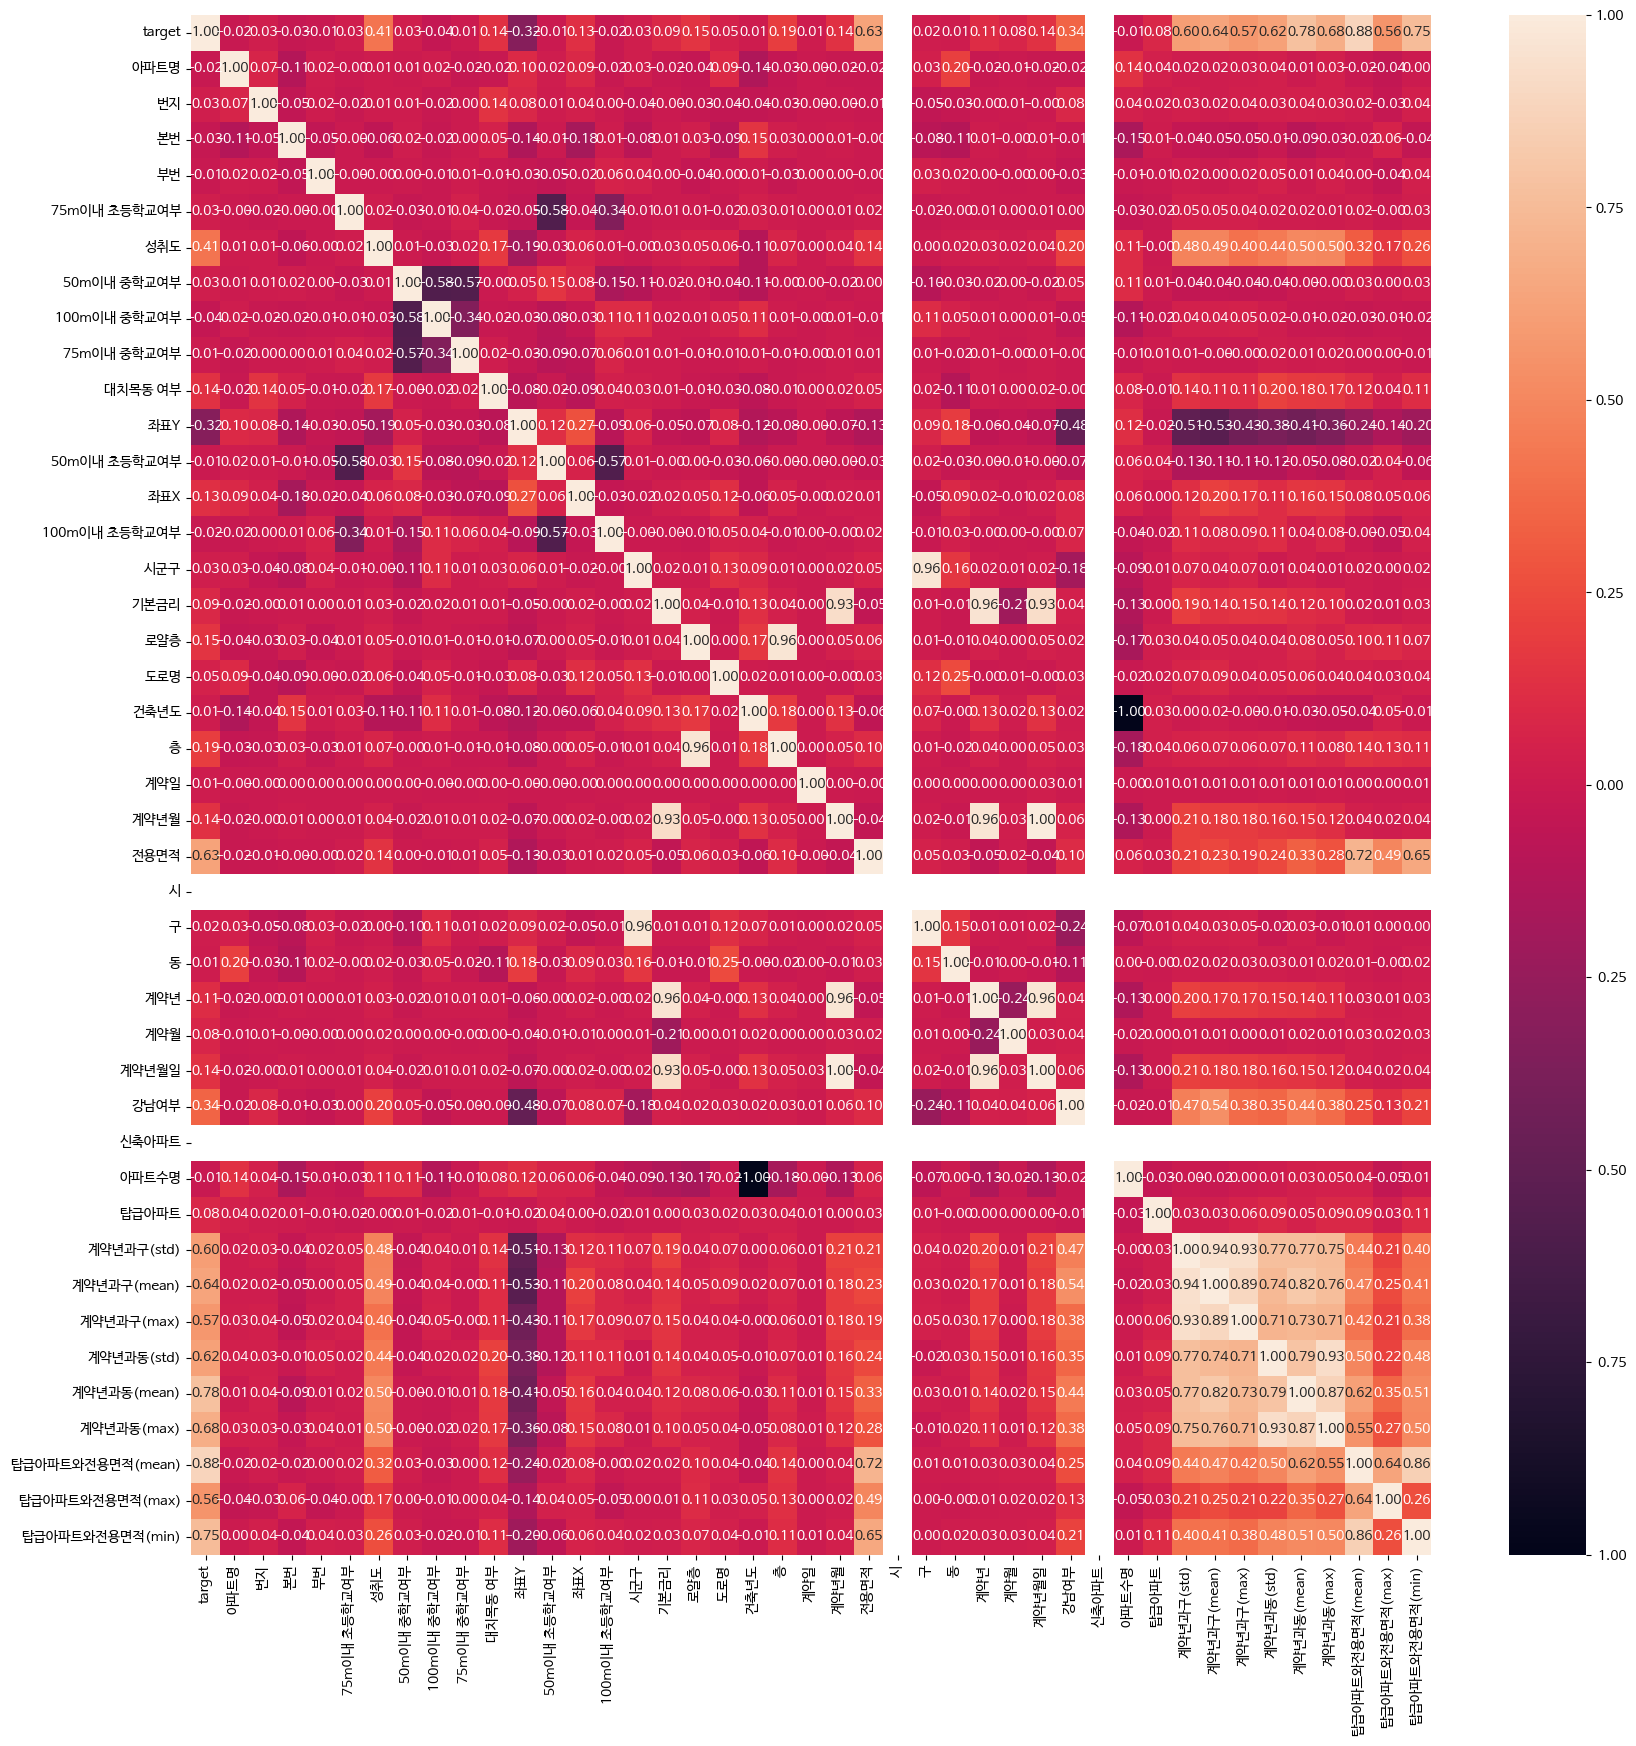

In [40]:
# dt_train 상관관계, PCA 분석
corr = df_train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f')

# target과 상관관계가 음수인 변수
corr_target = corr['target'].sort_values() < -0.1
corr_target[corr_target]

In [41]:
df_test['target'] = 0

/tmp/ipykernel_673112/992821829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['target'] = 0


In [55]:
print(df_train.shape)
print(df_test.shape)


(155929, 43)
(9272, 43)


## 데이터 스플릿(전용면적&강남여부)
1. df_train0 -> 전용면적 0~85
2. df_train85 -> 전용면적 85~200
3. df_train_200 -> 전용면적 200~

In [42]:
df_train0_gangnam1 = df_train[(df_train['전용면적']<85)&(df_train['강남여부']==1)]
df_train0_gangnam0 = df_train[(df_train['전용면적']<85)&(df_train['강남여부']==0)]

df_train85_gangnam1 = df_train[(df_train['전용면적']>=85)&(df_train['전용면적']<200)&(df_train['강남여부']==1)]
df_train85_gangnam0 = df_train[(df_train['전용면적']>=85)&(df_train['전용면적']<200)&(df_train['강남여부']==0)]

df_train200_gangnam1 = df_train[(df_train['전용면적']>=200)&(df_train['강남여부']==1)]
df_train200_gangnam0 = df_train[(df_train['전용면적']>=200)&(df_train['강남여부']==0)]

y_train0_gangnam1 = df_train0_gangnam1['target']
X_train0_gangnam1 = df_train0_gangnam1.drop(['target'], axis=1)
y_train0_gangnam0 = df_train0_gangnam0['target']
X_train0_gangnam0 = df_train0_gangnam0.drop(['target'], axis=1)

# y_train35_gangnam1 = df_train0_gangnam1['target']
# X_train35_gangnam1 = df_train0_gangnam1.drop(['target'], axis=1)
# y_train35_gangnam0 = df_train0_gangnam0['target']
# X_train35_gangnam0 = df_train0_gangnam0.drop(['target'], axis=1)

y_train85_gangnam1 = df_train85_gangnam1['target']
X_train85_gangnam1 = df_train85_gangnam1.drop(['target'], axis=1)
y_train85_gangnam0 = df_train85_gangnam0['target']
X_train85_gangnam0 = df_train85_gangnam0.drop(['target'], axis=1)

# y_train135_gangnam1 = df_train135_gangnam1['target']
# X_train135_gangnam1 = df_train135_gangnam1.drop(['target'], axis=1)
# y_train135_gangnam0 = df_train135_gangnam0['target']
# X_train135_gangnam0 = df_train135_gangnam0.drop(['target'], axis=1)

y_train200_gangnam1 = df_train200_gangnam1['target']
X_train200_gangnam1 = df_train200_gangnam1.drop(['target'], axis=1)
y_train200_gangnam0 = df_train200_gangnam0['target']
X_train200_gangnam0 = df_train200_gangnam0.drop(['target'], axis=1)

# Split the data into train and validation sets
X_train0_gangnam1, X_val0_gangnam1, y_train0_gangnam1, y_val0_gangnam1 = train_test_split(X_train0_gangnam1, y_train0_gangnam1, test_size=0.2, random_state=42)
X_train0_gangnam0, X_val0_gangnam0, y_train0_gangnam0, y_val0_gangnam0 = train_test_split(X_train0_gangnam0, y_train0_gangnam0, test_size=0.2, random_state=42)

# X_train35_gangnam1, X_val35_gangnam1, y_train35_gangnam1, y_val35_gangnam1 = train_test_split(X_train35_gangnam1, y_train35_gangnam1, test_size=0.2, random_state=42)
# X_train35_gangnam0, X_val35_gangnam0, y_train35_gangnam0, y_val35_gangnam0 = train_test_split(X_train35_gangnam0, y_train35_gangnam0, test_size=0.2, random_state=42)

X_train85_gangnam1, X_val85_gangnam1, y_train85_gangnam1, y_val85_gangnam1 = train_test_split(X_train85_gangnam1, y_train85_gangnam1, test_size=0.2, random_state=42)
X_train85_gangnam0, X_val85_gangnam0, y_train85_gangnam0, y_val85_gangnam0 = train_test_split(X_train85_gangnam0, y_train85_gangnam0, test_size=0.2, random_state=42)

# X_train135_gangnam1, X_val135_gangnam1, y_train135_gangnam1, y_val135_gangnam1 = train_test_split(X_train135_gangnam1, y_train135_gangnam1, test_size=0.2, random_state=42)
# X_train135_gangnam0, X_val135_gangnam0, y_train135_gangnam0, y_val135_gangnam0 = train_test_split(X_train135_gangnam0, y_train135_gangnam0, test_size=0.2, random_state=42)

X_train200_gangnam1, X_val200_gangnam1, y_train200_gangnam1, y_val200_gangnam1 = train_test_split(X_train200_gangnam1, y_train200_gangnam1, test_size=0.2, random_state=42)
X_train200_gangnam0, X_val200_gangnam0, y_train200_gangnam0, y_val200_gangnam0 = train_test_split(X_train200_gangnam0, y_train200_gangnam0, test_size=0.2, random_state=42)

## CatBoost

In [33]:
cat0_gangnam1 = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE', eval_metric='RMSE', random_seed=2023)
cat0_gangnam0 = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE', eval_metric='RMSE', random_seed=2023)

cat35_gangnam1 = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE', eval_metric='RMSE', random_seed=2023)
cat35_gangnam0 = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE', eval_metric='RMSE', random_seed=2023)

cat85_gangnam1 = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE', eval_metric='RMSE', random_seed=2023)
cat85_gangnam0 = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE', eval_metric='RMSE', random_seed=2023)

cat135_gangnam1 = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE', eval_metric='RMSE', random_seed=2023)
cat135_gangnam0 = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE', eval_metric='RMSE', random_seed=2023)

cat200_gangnam1 = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE', eval_metric='RMSE', random_seed=2023)
cat200_gangnam0 = CatBoostRegressor(iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE', eval_metric='RMSE', random_seed=2023)

In [34]:
cat0_gangnam1.fit(
    X_train0_gangnam1, y_train0_gangnam1, 
    eval_set=(X_val0_gangnam1, y_val0_gangnam1),
    use_best_model=True, early_stopping_rounds=50, 
    verbose_eval=100
)

cat0_gangnam0.fit(
    X_train0_gangnam0, y_train0_gangnam0, 
    eval_set=(X_val0_gangnam0, y_val0_gangnam0),
    use_best_model=True, early_stopping_rounds=50,
    verbose_eval=100
)

0:	learn: 24742.9374496	test: 24558.9837965	best: 24558.9837965 (0)	total: 61.4ms	remaining: 10m 13s
100:	learn: 10758.2582671	test: 10959.7791283	best: 10959.7791283 (100)	total: 684ms	remaining: 1m 7s
200:	learn: 5545.4055000	test: 5930.8975458	best: 5930.8975458 (200)	total: 1.32s	remaining: 1m 4s
300:	learn: 3629.5012333	test: 4184.4715731	best: 4184.4715731 (300)	total: 1.96s	remaining: 1m 3s
400:	learn: 2908.3429273	test: 3590.8349933	best: 3590.8349933 (400)	total: 2.6s	remaining: 1m 2s
500:	learn: 2584.4117636	test: 3339.4362210	best: 3339.4362210 (500)	total: 3.24s	remaining: 1m 1s
600:	learn: 2390.6771204	test: 3210.9804173	best: 3210.9804173 (600)	total: 3.88s	remaining: 1m
700:	learn: 2240.0068512	test: 3130.5414548	best: 3130.5414548 (700)	total: 4.51s	remaining: 59.8s
800:	learn: 2126.2547273	test: 3083.8223617	best: 3083.8223617 (800)	total: 5.14s	remaining: 59s
900:	learn: 2028.4066358	test: 3050.2414189	best: 3050.2414189 (900)	total: 5.77s	remaining: 58.3s
1000:	learn

In [35]:
cat35_gangnam1.fit(
    X_train35_gangnam1, y_train35_gangnam1, 
    eval_set=(X_val35_gangnam1, y_val35_gangnam1),
    use_best_model=True, early_stopping_rounds=50, 
    verbose_eval=100
)

cat35_gangnam0.fit(
    X_train35_gangnam0, y_train35_gangnam0, 
    eval_set=(X_val35_gangnam0, y_val35_gangnam0),
    use_best_model=True, early_stopping_rounds=50,
    verbose_eval=100
)

0:	learn: 58343.8719558	test: 57495.7495001	best: 57495.7495001 (0)	total: 13.1ms	remaining: 2m 11s
100:	learn: 29028.2733893	test: 28912.3500073	best: 28912.3500073 (100)	total: 1.29s	remaining: 2m 6s
200:	learn: 19163.1047801	test: 19466.7421840	best: 19466.7421840 (200)	total: 2.57s	remaining: 2m 5s
300:	learn: 15573.9848183	test: 16126.5524280	best: 16126.5524280 (300)	total: 3.85s	remaining: 2m 4s
400:	learn: 13883.1329478	test: 14600.3025603	best: 14600.3025603 (400)	total: 5.11s	remaining: 2m 2s
500:	learn: 12851.2817736	test: 13700.0124090	best: 13700.0124090 (500)	total: 6.38s	remaining: 2m
600:	learn: 12085.9978820	test: 13037.4130859	best: 13037.4130859 (600)	total: 7.64s	remaining: 1m 59s
700:	learn: 11413.1258309	test: 12467.5757023	best: 12467.5757023 (700)	total: 8.9s	remaining: 1m 58s
800:	learn: 10875.8206342	test: 12017.1518012	best: 12017.1518012 (800)	total: 10.2s	remaining: 1m 56s
900:	learn: 10455.3565820	test: 11671.8351903	best: 11671.8351903 (900)	total: 11.5s	

In [36]:
cat85_gangnam1.fit(
    X_train85_gangnam1, y_train85_gangnam1, 
    eval_set=(X_val85_gangnam1, y_val85_gangnam1),
    use_best_model=True, early_stopping_rounds=50, 
    verbose_eval=100
)

cat85_gangnam0.fit(
    X_train85_gangnam0, y_train85_gangnam0, 
    eval_set=(X_val85_gangnam0, y_val85_gangnam0),
    use_best_model=True, early_stopping_rounds=50,
    verbose_eval=100
)

0:	learn: 82431.1224479	test: 86897.6300963	best: 86897.6300963 (0)	total: 8.71ms	remaining: 1m 27s
100:	learn: 40748.9568988	test: 43990.3825808	best: 43990.3825808 (100)	total: 696ms	remaining: 1m 8s
200:	learn: 25208.5066489	test: 28315.3780155	best: 28315.3780155 (200)	total: 1.36s	remaining: 1m 6s
300:	learn: 19148.6587846	test: 22563.0303279	best: 22563.0303279 (300)	total: 2.02s	remaining: 1m 5s
400:	learn: 16435.8971228	test: 20239.6185772	best: 20239.6185772 (400)	total: 2.71s	remaining: 1m 4s
500:	learn: 14876.9024579	test: 19029.6708128	best: 19029.6708128 (500)	total: 3.37s	remaining: 1m 3s
600:	learn: 13812.2411359	test: 18291.2887199	best: 18291.2887199 (600)	total: 4.04s	remaining: 1m 3s
700:	learn: 12973.8198929	test: 17762.7212927	best: 17762.7212927 (700)	total: 4.69s	remaining: 1m 2s
800:	learn: 12231.8595828	test: 17320.6703793	best: 17320.6703793 (800)	total: 5.33s	remaining: 1m 1s
900:	learn: 11602.9098772	test: 16956.3138247	best: 16956.3138247 (900)	total: 6s	re

In [37]:
cat135_gangnam1.fit(
    X_train135_gangnam1, y_train135_gangnam1, 
    eval_set=(X_val135_gangnam1, y_val135_gangnam1),
    use_best_model=True, early_stopping_rounds=50, 
    verbose_eval=100
)

cat135_gangnam0.fit(
    X_train135_gangnam0, y_train135_gangnam0, 
    eval_set=(X_val135_gangnam0, y_val135_gangnam0),
    use_best_model=True, early_stopping_rounds=50,
    verbose_eval=100
)

0:	learn: 116511.8767948	test: 123692.7093728	best: 123692.7093728 (0)	total: 8.83ms	remaining: 1m 28s
100:	learn: 57687.4211924	test: 64844.1955545	best: 64844.1955545 (100)	total: 593ms	remaining: 58.1s
200:	learn: 34997.0637256	test: 41813.2776423	best: 41813.2776423 (200)	total: 1.19s	remaining: 57.8s
300:	learn: 26195.3427489	test: 32893.4356087	best: 32893.4356087 (300)	total: 1.75s	remaining: 56.3s
400:	learn: 22029.4179024	test: 29036.0548233	best: 29036.0548233 (400)	total: 2.33s	remaining: 55.7s
500:	learn: 19577.0423473	test: 27007.2095588	best: 27007.2095588 (500)	total: 2.91s	remaining: 55.3s
600:	learn: 17903.5684200	test: 25775.6190237	best: 25775.6190237 (600)	total: 3.48s	remaining: 54.4s
700:	learn: 16560.7620002	test: 24920.1885323	best: 24920.1885323 (700)	total: 4.03s	remaining: 53.4s
800:	learn: 15394.1124804	test: 24250.3506798	best: 24250.3506798 (800)	total: 4.57s	remaining: 52.5s
900:	learn: 14376.4209999	test: 23736.2553227	best: 23736.2553227 (900)	total: 5.

In [38]:
cat200_gangnam1.fit(
    X_train200_gangnam1, y_train200_gangnam1, 
    eval_set=(X_val200_gangnam1, y_val200_gangnam1),
    use_best_model=True, early_stopping_rounds=50, 
    verbose_eval=100
)

cat200_gangnam0.fit(
    X_train200_gangnam0, y_train200_gangnam0, 
    eval_set=(X_val200_gangnam0, y_val200_gangnam0),
    use_best_model=True, early_stopping_rounds=50,
    verbose_eval=100
)

0:	learn: 169222.5138077	test: 191128.7352203	best: 191128.7352203 (0)	total: 6.64ms	remaining: 1m 6s
100:	learn: 98655.6672043	test: 135961.0709708	best: 135961.0709708 (100)	total: 427ms	remaining: 41.8s
200:	learn: 62939.6328284	test: 109373.7888447	best: 109373.7888447 (200)	total: 835ms	remaining: 40.7s
300:	learn: 44495.1876238	test: 96887.8851985	best: 96887.8851985 (300)	total: 1.23s	remaining: 39.8s
400:	learn: 34346.9761518	test: 91193.4586614	best: 91193.4586614 (400)	total: 1.63s	remaining: 39s
500:	learn: 28291.9572881	test: 88118.4547830	best: 88118.4547830 (500)	total: 2.02s	remaining: 38.4s
600:	learn: 24060.6354619	test: 85968.9812488	best: 85968.9812488 (600)	total: 2.42s	remaining: 37.9s
700:	learn: 20757.2162985	test: 85055.7749951	best: 85055.7749951 (700)	total: 2.84s	remaining: 37.6s
800:	learn: 18054.8802170	test: 84529.9193771	best: 84529.9193771 (800)	total: 3.25s	remaining: 37.3s
900:	learn: 16066.1801217	test: 84092.1464175	best: 84091.7445276 (899)	total: 3

In [39]:
X_test = df_test.drop(['target'], axis=1)
X_test = X_test.sort_values(by='전용면적')
X_test = X_test.sort_index()
X_test.head(30)

,아파트명,번지,본번,부번,75m이내 초등학교여부,성취도,50m이내 중학교여부,100m이내 중학교여부,75m이내 중학교여부,대치목동 여부,좌표Y,50m이내 초등학교여부,좌표X,100m이내 초등학교여부,시군구,기본금리,로얄층,도로명,건축년도,층,계약일,계약년월,전용면적,시,구,동,계약년,계약월,계약년월일,강남여부,신축아파트,아파트수명,탑급아파트,계약년과구(std),계약년과구(mean),계약년과구(max),계약년과동(std),계약년과동(mean),계약년과동(max),탑급아파트와전용면적(mean),탑급아파트와전용면적(max),탑급아파트와전용면적(min)
0,292,4114,658.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,37.476151,0.0,127.057213,1.0,0,3.5,2.302585,5063,1987.0,5.0,26,42,79.9700,0,0,8,2023,7,1301,1,1,37,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,113637.500000,220000.000000,53800.000000
1,293,4090,651.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,37.484745,1.0,127.057283,0.0,0,3.5,2.708050,390,2021.0,10.0,15,43,108.2017,0,0,8,2023,8,1321,1,1,3,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,94038.457614,192530.991401,49704.727349
2,297,4091,652.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.483955,1.0,127.056025,0.0,0,3.5,2.995732,388,1984.0,15.0,28,42,161.0000,0,0,8,2023,7,1303,1,1,40,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,296083.333333,365000.000000,268500.000000
3,297,4091,652.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.483955,1.0,127.056025,0.0,0,3.5,2.944439,388,1984.0,14.0,10,43,133.4600,0,0,8,2023,8,1316,1,1,40,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,258500.000000,289000.000000,220000.000000
4,297,4091,652.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.483955,1.0,127.056025,0.0,0,3.5,2.397895,388,1984.0,6.0,18,43,104.4300,0,0,8,2023,8,1324,1,1,40,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,209416.666667,249500.000000,145000.000000
5,302,1474,187.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37.487630,1.0,127.068507,0.0,0,3.5,2.564949,3606,1983.0,8.0,28,42,74.2500,0,0,8,2023,7,1303,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,107686.585366,273000.000000,24000.000000
6,303,1462,185.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.489075,1.0,127.071512,0.0,0,3.5,2.772589,394,1983.0,11.0,2,42,83.2100,0,0,8,2023,7,1277,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,95388.144330,285000.000000,24500.000000
7,303,1462,185.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.489075,1.0,127.071512,0.0,0,3.5,2.833213,394,1983.0,12.0,14,43,73.0200,0,0,8,2023,8,1320,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,189861.111111,270000.000000,40500.000000
8,303,1462,185.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.489075,1.0,127.071512,0.0,0,3.5,2.639057,394,1983.0,9.0,24,43,53.0600,0,0,8,2023,8,1330,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,168711.111111,200000.000000,77500.000000
9,1503,627,1280.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.481161,0.0,127.064899,1.0,0,3.5,3.433987,4033,2019.0,26.0,3,42,126.9280,0,0,8,2023,7,1278,1,1,5,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,395500.000000,436000.000000,355000.000000


In [42]:
X_test0_gangnam1 = X_test[(X_test['전용면적']<35)&(X_test['강남여부']==1)]
X_test0_gangnam0 = X_test[(X_test['전용면적']<35)&(X_test['강남여부']==0)]

X_test35_gangnam1 = X_test[(X_test['전용면적']>=35)&(X_test['전용면적']<85)&(X_test['강남여부']==1)]
X_test35_gangnam0 = X_test[(X_test['전용면적']>=35)&(X_test['전용면적']<85)&(X_test['강남여부']==0)]

X_test85_gangnam1 = X_test[(X_test['전용면적']>=85)&(X_test['전용면적']<135)&(X_test['강남여부']==1)]
X_test85_gangnam0 = X_test[(X_test['전용면적']>=85)&(X_test['전용면적']<135)&(X_test['강남여부']==0)]

X_test135_gangnam1 = X_test[(X_test['전용면적']>=135)&(X_test['전용면적']<200)&(X_test['강남여부']==1)]
X_test135_gangnam0 = X_test[(X_test['전용면적']>=135)&(X_test['전용면적']<200)&(X_test['강남여부']==0)]

X_test200_gangnam1 = X_test[(X_test['전용면적']>=200)&(X_test['강남여부']==1)]
X_test200_gangnam0 = X_test[(X_test['전용면적']>=200)&(X_test['강남여부']==0)]

In [43]:
real_test_pred0_gangnam1 = cat0_gangnam1.predict(X_test0_gangnam1)
real_test_pred0_gangnam0 = cat0_gangnam0.predict(X_test0_gangnam0)

real_test_pred35_gangnam1 = cat35_gangnam1.predict(X_test35_gangnam1)
real_test_pred35_gangnam0 = cat35_gangnam0.predict(X_test35_gangnam0)

real_test_pred85_gangnam1 = cat85_gangnam1.predict(X_test85_gangnam1)
real_test_pred85_gangnam0 = cat85_gangnam0.predict(X_test85_gangnam0)

real_test_pred135_gangnam1 = cat135_gangnam1.predict(X_test135_gangnam1)
real_test_pred135_gangnam0 = cat135_gangnam0.predict(X_test135_gangnam0)

real_test_pred200_gangnam1 = cat200_gangnam1.predict(X_test200_gangnam1)
real_test_pred200_gangnam0 = cat200_gangnam0.predict(X_test200_gangnam0)

In [44]:
X_test0_gangnam1['target'] = real_test_pred0_gangnam1
X_test0_gangnam0['target'] = real_test_pred0_gangnam0

X_test35_gangnam1['target'] = real_test_pred35_gangnam1
X_test35_gangnam0['target'] = real_test_pred35_gangnam0

X_test85_gangnam1['target'] = real_test_pred85_gangnam1
X_test85_gangnam0['target'] = real_test_pred85_gangnam0

X_test135_gangnam1['target'] = real_test_pred135_gangnam1
X_test135_gangnam0['target'] = real_test_pred135_gangnam0

X_test200_gangnam1['target'] = real_test_pred200_gangnam1
X_test200_gangnam0['target'] = real_test_pred200_gangnam0

/tmp/ipykernel_634245/3789095651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test0_gangnam1['target'] = real_test_pred0_gangnam1
/tmp/ipykernel_634245/3789095651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test0_gangnam0['target'] = real_test_pred0_gangnam0
/tmp/ipykernel_634245/3789095651.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [45]:
concat_test = pd.concat([
    X_test0_gangnam1, X_test0_gangnam0,
    X_test35_gangnam1, X_test35_gangnam0,
    X_test85_gangnam1, X_test85_gangnam0,
    X_test135_gangnam1, X_test135_gangnam0,
    X_test200_gangnam1, X_test200_gangnam0
], axis=0)
concat_test = concat_test.sort_index()
concat_test.head(30)

,아파트명,번지,본번,부번,75m이내 초등학교여부,성취도,50m이내 중학교여부,100m이내 중학교여부,75m이내 중학교여부,대치목동 여부,좌표Y,50m이내 초등학교여부,좌표X,100m이내 초등학교여부,시군구,기본금리,로얄층,도로명,건축년도,층,계약일,계약년월,전용면적,시,구,동,계약년,계약월,계약년월일,강남여부,신축아파트,아파트수명,탑급아파트,계약년과구(std),계약년과구(mean),계약년과구(max),계약년과동(std),계약년과동(mean),계약년과동(max),탑급아파트와전용면적(mean),탑급아파트와전용면적(max),탑급아파트와전용면적(min),target
0,292,4114,658.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,37.476151,0.0,127.057213,1.0,0,3.5,2.302585,5063,1987.0,5.0,26,42,79.9700,0,0,8,2023,7,1301,1,1,37,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,113637.500000,220000.000000,53800.000000,172862.092369
1,293,4090,651.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,37.484745,1.0,127.057283,0.0,0,3.5,2.708050,390,2021.0,10.0,15,43,108.2017,0,0,8,2023,8,1321,1,1,3,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,94038.457614,192530.991401,49704.727349,202228.871243
2,297,4091,652.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.483955,1.0,127.056025,0.0,0,3.5,2.995732,388,1984.0,15.0,28,42,161.0000,0,0,8,2023,7,1303,1,1,40,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,296083.333333,365000.000000,268500.000000,318123.078933
3,297,4091,652.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.483955,1.0,127.056025,0.0,0,3.5,2.944439,388,1984.0,14.0,10,43,133.4600,0,0,8,2023,8,1316,1,1,40,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,258500.000000,289000.000000,220000.000000,261988.773461
4,297,4091,652.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.483955,1.0,127.056025,0.0,0,3.5,2.397895,388,1984.0,6.0,18,43,104.4300,0,0,8,2023,8,1324,1,1,40,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,209416.666667,249500.000000,145000.000000,215704.639897
5,302,1474,187.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37.487630,1.0,127.068507,0.0,0,3.5,2.564949,3606,1983.0,8.0,28,42,74.2500,0,0,8,2023,7,1303,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,107686.585366,273000.000000,24000.000000,223983.563852
6,303,1462,185.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.489075,1.0,127.071512,0.0,0,3.5,2.772589,394,1983.0,11.0,2,42,83.2100,0,0,8,2023,7,1277,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,95388.144330,285000.000000,24500.000000,235831.415083
7,303,1462,185.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.489075,1.0,127.071512,0.0,0,3.5,2.833213,394,1983.0,12.0,14,43,73.0200,0,0,8,2023,8,1320,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,189861.111111,270000.000000,40500.000000,221026.500741
8,303,1462,185.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.489075,1.0,127.071512,0.0,0,3.5,2.639057,394,1983.0,9.0,24,43,53.0600,0,0,8,2023,8,1330,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,168711.111111,200000.000000,77500.000000,179361.556183
9,1503,627,1280.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.481161,0.0,127.064899,1.0,0,3.5,3.433987,4033,2019.0,26.0,3,42,126.9280,0,0,8,2023,7,1278,1,1,5,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,395500.000000,436000.000000,355000.000000,384329.490494


In [46]:
ttt = concat_test.loc[:,'target']
ttt = pd.DataFrame(ttt)

ttt= ttt.reset_index()

preds_df= ttt.drop(columns='index')
preds_df= ttt.drop(columns='index')

preds_df2 = pd.DataFrame(preds_df['target'].astype(int), columns=["target"])
preds_df2

preds_df2.to_csv('cat_(2020)_전용면적&강남여부.csv', index=False)

## LGBM

In [43]:
gbm0_gangnam1 = lgb.LGBMRegressor(n_estimators=10000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)
gbm0_gangnam0 = lgb.LGBMRegressor(n_estimators=10000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)

# gbm35_gangnam1 = lgb.LGBMRegressor(n_estimators=10000, max_depth=50, num_leaves=600, min_child_samples=50,
#                             feature_fraction=0.7,
#                             bagging_fraction=0.9, verbosity=-1)
# gbm35_gangnam0 = lgb.LGBMRegressor(n_estimators=10000, max_depth=50, num_leaves=600, min_child_samples=50,
#                             feature_fraction=0.7,
#                             bagging_fraction=0.9, verbosity=-1)

gbm85_gangnam1 = lgb.LGBMRegressor(n_estimators=10000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)
gbm85_gangnam0 = lgb.LGBMRegressor(n_estimators=10000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)

# gbm135_gangnam1 = lgb.LGBMRegressor(n_estimators=10000, max_depth=50, num_leaves=600, min_child_samples=50,
#                             feature_fraction=0.7,
#                             bagging_fraction=0.9, verbosity=-1)
# gbm135_gangnam0 = lgb.LGBMRegressor(n_estimators=10000, max_depth=50, num_leaves=600, min_child_samples=50,
#                             feature_fraction=0.7,
#                             bagging_fraction=0.9, verbosity=-1)

gbm200_gangnam1 = lgb.LGBMRegressor(n_estimators=10000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)
gbm200_gangnam0 = lgb.LGBMRegressor(n_estimators=10000, max_depth=50, num_leaves=600, min_child_samples=50,
                            feature_fraction=0.7,
                            bagging_fraction=0.9, verbosity=-1)

In [44]:
gbm0_gangnam1.fit(
        X_train0_gangnam1, y_train0_gangnam1, 
        eval_set=[(X_train0_gangnam1, y_train0_gangnam1), (X_val0_gangnam1, y_val0_gangnam1)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
print('강남여부 O & 전용면적 85m³ 이하 모델 학습 완료')

gbm0_gangnam0.fit(
        X_train0_gangnam0, y_train0_gangnam0,
        eval_set=[(X_train0_gangnam0, y_train0_gangnam0), (X_val0_gangnam0, y_val0_gangnam0)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
print('강남여부 X & 전용면적 85m³ 이하 모델 학습 완료')

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5244.96	training's l2: 2.75096e+07	valid_1's rmse: 8642.49	valid_1's l2: 7.46927e+07
[200]	training's rmse: 3665.88	training's l2: 1.34387e+07	valid_1's rmse: 8431.87	valid_1's l2: 7.10965e+07
Early stopping, best iteration is:
[202]	training's rmse: 3643.38	training's l2: 1.32742e+07	valid_1's rmse: 8430.27	valid_1's l2: 7.10694e+07
강남여부 O & 전용면적 85m³ 이하 모델 학습 완료
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3418.87	training's l2: 1.16887e+07	valid_1's rmse: 5496.43	valid_1's l2: 3.02108e+07
[200]	training's rmse: 2437.25	training's l2: 5.94018e+06	valid_1's rmse: 5276.53	valid_1's l2: 2.78418e+07
[300]	training's rmse: 1928.3	training's l2: 3.71834e+06	valid_1's rmse: 5236.39	valid_1's l2: 2.74198e+07
[400]	training's rmse: 1573.75	training's l2: 2.4767e+06	valid_1's rmse: 5230.85	valid_1's l2: 2.73618e+07
Early stopping, best iteration is:
[370]	training's rmse: 

In [546]:
gbm35_gangnam1.fit(
        X_train35_gangnam1, y_train35_gangnam1,
        eval_set=[(X_train35_gangnam1, y_train35_gangnam1), (X_val35_gangnam1, y_val35_gangnam1)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
print('강남여부 O & 전용면적 35m³이상 85m³이하 모델 학습 완료')

gbm35_gangnam0.fit(
        X_train35_gangnam0, y_train35_gangnam0,
        eval_set=[(X_train35_gangnam0, y_train35_gangnam0), (X_val35_gangnam0, y_val35_gangnam0)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
print('강남여부 X & 전용면적 35m³이상 85m³이하 모델 학습 완료')

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5480.79	training's l2: 3.0039e+07	valid_1's rmse: 9446.62	valid_1's l2: 8.92387e+07
[200]	training's rmse: 3863.83	training's l2: 1.49292e+07	valid_1's rmse: 9258.5	valid_1's l2: 8.57198e+07
Early stopping, best iteration is:
[231]	training's rmse: 3555.77	training's l2: 1.26435e+07	valid_1's rmse: 9245.18	valid_1's l2: 8.54734e+07
강남여부 O & 전용면적 35m³이상 85m³이하 모델 학습 완료
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3521.19	training's l2: 1.23987e+07	valid_1's rmse: 5564.7	valid_1's l2: 3.09659e+07
[200]	training's rmse: 2503.46	training's l2: 6.26729e+06	valid_1's rmse: 5324.95	valid_1's l2: 2.83551e+07
[300]	training's rmse: 1952.34	training's l2: 3.81162e+06	valid_1's rmse: 5289.56	valid_1's l2: 2.79795e+07
[400]	training's rmse: 1585.89	training's l2: 2.51506e+06	valid_1's rmse: 5287.35	valid_1's l2: 2.79561e+07
Early stopping, best iteration is:
[355]	training's r

In [45]:
gbm85_gangnam1.fit(
        X_train85_gangnam1, y_train85_gangnam1,
        eval_set=[(X_train85_gangnam1, y_train85_gangnam1), (X_val85_gangnam1, y_val85_gangnam1)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
print('강남여부 O & 전용면적 85m³이상 200m³이하 모델 학습 완료')

gbm85_gangnam0.fit(
        X_train85_gangnam0, y_train85_gangnam0,
        eval_set=[(X_train85_gangnam0, y_train85_gangnam0), (X_val85_gangnam0, y_val85_gangnam0)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
print('강남여부 X & 전용면적 85m³이상 200m³이하 모델 학습 완료')

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10127.9	training's l2: 1.02575e+08	valid_1's rmse: 18142.9	valid_1's l2: 3.29165e+08
[200]	training's rmse: 7390.03	training's l2: 5.46125e+07	valid_1's rmse: 17603.7	valid_1's l2: 3.09891e+08
[300]	training's rmse: 5964.37	training's l2: 3.55737e+07	valid_1's rmse: 17476.2	valid_1's l2: 3.05416e+08
[400]	training's rmse: 5012.44	training's l2: 2.51246e+07	valid_1's rmse: 17404	valid_1's l2: 3.02898e+08
Early stopping, best iteration is:
[419]	training's rmse: 4874.84	training's l2: 2.37641e+07	valid_1's rmse: 17394.5	valid_1's l2: 3.02569e+08
강남여부 O & 전용면적 85m³이상 200m³이하 모델 학습 완료
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7274.52	training's l2: 5.29187e+07	valid_1's rmse: 11036.8	valid_1's l2: 1.2181e+08
[200]	training's rmse: 5445.46	training's l2: 2.9653e+07	valid_1's rmse: 10756	valid_1's l2: 1.15692e+08
[300]	training's rmse: 4460.87	training's l2: 1.98994e+

In [537]:
gbm135_gangnam1.fit(
        X_train135_gangnam1, y_train135_gangnam1,
        eval_set=[(X_train135_gangnam1, y_train135_gangnam1), (X_val135_gangnam1, y_val135_gangnam1)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
print('강남여부 O & 전용면적 135m³이상 200m³이하 모델 학습 완료')

gbm135_gangnam0.fit(
        X_train135_gangnam0, y_train135_gangnam0,
        eval_set=[(X_train135_gangnam0, y_train135_gangnam0), (X_val135_gangnam0, y_val135_gangnam0)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
print('강남여부 X & 전용면적 135m³이상 200m³이하 모델 학습 완료')

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 14847.5	training's l2: 2.20449e+08	valid_1's rmse: 23881.3	valid_1's l2: 5.70315e+08
[200]	training's rmse: 11031.3	training's l2: 1.21689e+08	valid_1's rmse: 22881.1	valid_1's l2: 5.23544e+08
[300]	training's rmse: 8840.17	training's l2: 7.81487e+07	valid_1's rmse: 22530.8	valid_1's l2: 5.07635e+08
[400]	training's rmse: 7435.15	training's l2: 5.52815e+07	valid_1's rmse: 22358.4	valid_1's l2: 4.99896e+08
[500]	training's rmse: 6237.23	training's l2: 3.8903e+07	valid_1's rmse: 22297.5	valid_1's l2: 4.97179e+08
Early stopping, best iteration is:
[535]	training's rmse: 5913.99	training's l2: 3.49753e+07	valid_1's rmse: 22259.5	valid_1's l2: 4.95486e+08
강남여부 O & 전용면적 135m³이상 200m³이하 모델 학습 완료
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 13734.5	training's l2: 1.88637e+08	valid_1's rmse: 20159.5	valid_1's l2: 4.06407e+08
[200]	training's rmse: 10291.5	training's l2: 1.0

In [46]:
gbm200_gangnam1.fit(
        X_train200_gangnam1, y_train200_gangnam1,
        eval_set=[(X_train200_gangnam1, y_train200_gangnam1), (X_val200_gangnam1, y_val200_gangnam1)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
print('강남여부 O & 전용면적 200m³이상 모델 학습 완료')

gbm200_gangnam0.fit(
        X_train200_gangnam0, y_train200_gangnam0,
        eval_set=[(X_train200_gangnam0, y_train200_gangnam0), (X_val200_gangnam0, y_val200_gangnam0)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
print('강남여부 X & 전용면적 200m³이상 모델 학습 완료')

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 38619.9	training's l2: 1.4915e+09	valid_1's rmse: 77633.8	valid_1's l2: 6.02701e+09
[200]	training's rmse: 29335.6	training's l2: 8.60577e+08	valid_1's rmse: 70120.6	valid_1's l2: 4.9169e+09
[300]	training's rmse: 24277.4	training's l2: 5.89391e+08	valid_1's rmse: 67087.9	valid_1's l2: 4.50079e+09
[400]	training's rmse: 20444.9	training's l2: 4.17995e+08	valid_1's rmse: 65553.4	valid_1's l2: 4.29724e+09
[500]	training's rmse: 17576.1	training's l2: 3.0892e+08	valid_1's rmse: 64492.8	valid_1's l2: 4.15932e+09
[600]	training's rmse: 15357.9	training's l2: 2.35865e+08	valid_1's rmse: 63889	valid_1's l2: 4.08181e+09
[700]	training's rmse: 13649.6	training's l2: 1.86313e+08	valid_1's rmse: 63509.8	valid_1's l2: 4.03349e+09
Early stopping, best iteration is:
[714]	training's rmse: 13414.7	training's l2: 1.79955e+08	valid_1's rmse: 63452.9	valid_1's l2: 4.02627e+09
강남여부 O & 전용면적 200m³이상 모델 학습 완료
Training until

In [47]:
X_test = df_test.drop(['target'], axis=1)
X_test = X_test.sort_values(by='전용면적')
X_test = X_test.sort_index()
X_test.head(30)

,아파트명,번지,본번,부번,75m이내 초등학교여부,성취도,50m이내 중학교여부,100m이내 중학교여부,75m이내 중학교여부,대치목동 여부,좌표Y,50m이내 초등학교여부,좌표X,100m이내 초등학교여부,시군구,기본금리,로얄층,도로명,건축년도,층,계약일,계약년월,전용면적,시,구,동,계약년,계약월,계약년월일,강남여부,신축아파트,아파트수명,탑급아파트,계약년과구(std),계약년과구(mean),계약년과구(max),계약년과동(std),계약년과동(mean),계약년과동(max),탑급아파트와전용면적(mean),탑급아파트와전용면적(max),탑급아파트와전용면적(min)
0,292,4114,658.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,37.476151,0.0,127.057213,1.0,0,3.5,2.302585,5063,1987.0,5.0,26,42,79.9700,0,0,8,2023,7,1301,1,1,37,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,113637.500000,220000.000000,53800.000000
1,293,4090,651.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,37.484745,1.0,127.057283,0.0,0,3.5,2.708050,390,2021.0,10.0,15,43,108.2017,0,0,8,2023,8,1321,1,1,3,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,94038.457614,192530.991401,49704.727349
2,297,4091,652.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.483955,1.0,127.056025,0.0,0,3.5,2.995732,388,1984.0,15.0,28,42,161.0000,0,0,8,2023,7,1303,1,1,40,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,296083.333333,365000.000000,268500.000000
3,297,4091,652.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.483955,1.0,127.056025,0.0,0,3.5,2.944439,388,1984.0,14.0,10,43,133.4600,0,0,8,2023,8,1316,1,1,40,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,258500.000000,289000.000000,220000.000000
4,297,4091,652.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.483955,1.0,127.056025,0.0,0,3.5,2.397895,388,1984.0,6.0,18,43,104.4300,0,0,8,2023,8,1324,1,1,40,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,209416.666667,249500.000000,145000.000000
5,302,1474,187.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,37.487630,1.0,127.068507,0.0,0,3.5,2.564949,3606,1983.0,8.0,28,42,74.2500,0,0,8,2023,7,1303,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,107686.585366,273000.000000,24000.000000
6,303,1462,185.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.489075,1.0,127.071512,0.0,0,3.5,2.772589,394,1983.0,11.0,2,42,83.2100,0,0,8,2023,7,1277,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,95388.144330,285000.000000,24500.000000
7,303,1462,185.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.489075,1.0,127.071512,0.0,0,3.5,2.833213,394,1983.0,12.0,14,43,73.0200,0,0,8,2023,8,1320,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,189861.111111,270000.000000,40500.000000
8,303,1462,185.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.489075,1.0,127.071512,0.0,0,3.5,2.639057,394,1983.0,9.0,24,43,53.0600,0,0,8,2023,8,1330,1,1,41,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,168711.111111,200000.000000,77500.000000
9,1503,627,1280.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.481161,0.0,127.064899,1.0,0,3.5,3.433987,4033,2019.0,26.0,3,42,126.9280,0,0,8,2023,7,1278,1,1,5,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,395500.000000,436000.000000,355000.000000


In [48]:
X_test0_gangnam1 = X_test[(X_test['전용면적']<35)&(X_test['강남여부']==1)]
X_test0_gangnam0 = X_test[(X_test['전용면적']<35)&(X_test['강남여부']==0)]

# X_test35_gangnam1 = X_test[(X_test['전용면적']>=35)&(X_test['전용면적']<85)&(X_test['강남여부']==1)]
# X_test35_gangnam0 = X_test[(X_test['전용면적']>=35)&(X_test['전용면적']<85)&(X_test['강남여부']==0)]

X_test85_gangnam1 = X_test[(X_test['전용면적']>=85)&(X_test['전용면적']<135)&(X_test['강남여부']==1)]
X_test85_gangnam0 = X_test[(X_test['전용면적']>=85)&(X_test['전용면적']<135)&(X_test['강남여부']==0)]

# X_test135_gangnam1 = X_test[(X_test['전용면적']>=135)&(X_test['전용면적']<200)&(X_test['강남여부']==1)]
# X_test135_gangnam0 = X_test[(X_test['전용면적']>=135)&(X_test['전용면적']<200)&(X_test['강남여부']==0)]

X_test200_gangnam1 = X_test[(X_test['전용면적']>=200)&(X_test['강남여부']==1)]
X_test200_gangnam0 = X_test[(X_test['전용면적']>=200)&(X_test['강남여부']==0)]

In [49]:
real_test_pred0_gangnam1 = gbm0_gangnam1.predict(X_test0_gangnam1)
real_test_pred0_gangnam0 = gbm0_gangnam0.predict(X_test0_gangnam0)

# real_test_pred35_gangnam1 = gbm35_gangnam1.predict(X_test35_gangnam1)
# real_test_pred35_gangnam0 = gbm35_gangnam0.predict(X_test35_gangnam0)

real_test_pred85_gangnam1 = gbm85_gangnam1.predict(X_test85_gangnam1)
real_test_pred85_gangnam0 = gbm85_gangnam0.predict(X_test85_gangnam0)

# real_test_pred135_gangnam1 = gbm135_gangnam1.predict(X_test135_gangnam1)
# real_test_pred135_gangnam0 = gbm135_gangnam0.predict(X_test135_gangnam0)

real_test_pred200_gangnam1 = gbm200_gangnam1.predict(X_test200_gangnam1)
real_test_pred200_gangnam0 = gbm200_gangnam0.predict(X_test200_gangnam0)

In [50]:
X_test0_gangnam1['target'] = real_test_pred0_gangnam1
X_test0_gangnam0['target'] = real_test_pred0_gangnam0

# X_test35_gangnam1['target'] = real_test_pred35_gangnam1
# X_test35_gangnam0['target'] = real_test_pred35_gangnam0

X_test85_gangnam1['target'] = real_test_pred85_gangnam1
X_test85_gangnam0['target'] = real_test_pred85_gangnam0

# X_test135_gangnam1['target'] = real_test_pred135_gangnam1
# X_test135_gangnam0['target'] = real_test_pred135_gangnam0

X_test200_gangnam1['target'] = real_test_pred200_gangnam1
X_test200_gangnam0['target'] = real_test_pred200_gangnam0

/tmp/ipykernel_673112/2791039051.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test0_gangnam1['target'] = real_test_pred0_gangnam1
/tmp/ipykernel_673112/2791039051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test0_gangnam0['target'] = real_test_pred0_gangnam0
/tmp/ipykernel_673112/2791039051.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [51]:
concat_test = pd.concat([
    X_test0_gangnam1, X_test0_gangnam0,
    # X_test35_gangnam1, X_test35_gangnam0,
    X_test85_gangnam1, X_test85_gangnam0,
    # X_test135_gangnam1, X_test135_gangnam0,
    X_test200_gangnam1, X_test200_gangnam0
], axis=0)
concat_test = concat_test.sort_index()
concat_test.head(30)

,아파트명,번지,본번,부번,75m이내 초등학교여부,성취도,50m이내 중학교여부,100m이내 중학교여부,75m이내 중학교여부,대치목동 여부,좌표Y,50m이내 초등학교여부,좌표X,100m이내 초등학교여부,시군구,기본금리,로얄층,도로명,건축년도,층,계약일,계약년월,전용면적,시,구,동,계약년,계약월,계약년월일,강남여부,신축아파트,아파트수명,탑급아파트,계약년과구(std),계약년과구(mean),계약년과구(max),계약년과동(std),계약년과동(mean),계약년과동(max),탑급아파트와전용면적(mean),탑급아파트와전용면적(max),탑급아파트와전용면적(min),target
1,293,4090,651.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,37.484745,1.0,127.057283,0.0,0,3.5,2.708050,390,2021.0,10.0,15,43,108.2017,0,0,8,2023,8,1321,1,1,3,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,94038.457614,192530.991401,49704.727349,208076.886118
3,297,4091,652.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.483955,1.0,127.056025,0.0,0,3.5,2.944439,388,1984.0,14.0,10,43,133.4600,0,0,8,2023,8,1316,1,1,40,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,258500.000000,289000.000000,220000.000000,266680.569039
4,297,4091,652.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.483955,1.0,127.056025,0.0,0,3.5,2.397895,388,1984.0,6.0,18,43,104.4300,0,0,8,2023,8,1324,1,1,40,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,209416.666667,249500.000000,145000.000000,205476.852628
9,1503,627,1280.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.481161,0.0,127.064899,1.0,0,3.5,3.433987,4033,2019.0,26.0,3,42,126.9280,0,0,8,2023,7,1278,1,1,5,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,395500.000000,436000.000000,355000.000000,365390.976825
20,1503,627,1280.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.481161,0.0,127.064899,1.0,0,3.5,1.945910,4033,2019.0,2.0,23,43,113.8080,0,0,8,2023,8,1329,1,1,5,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,94038.457614,192530.991401,49704.727349,212116.384233
21,1503,627,1280.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.481161,0.0,127.064899,1.0,0,3.5,3.091042,4033,2019.0,17.0,8,44,99.9190,0,0,8,2023,9,1345,1,1,5,0,112608.321949,207993.469722,900000.0,65335.877082,169735.593220,370000.0,307250.000000,310000.000000,304500.000000,307104.204955
27,1090,5378,974.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,37.500931,0.0,127.060970,0.0,2,3.5,2.302585,3614,1999.0,5.0,12,42,85.0000,0,0,57,2023,7,1287,1,1,25,0,112608.321949,207993.469722,900000.0,91425.662731,252174.641148,515000.0,98902.989130,246000.000000,35700.000000,211094.374389
30,1090,5378,974.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,37.500931,0.0,127.060970,0.0,2,3.5,3.218876,3614,1999.0,20.0,7,43,85.0000,0,0,57,2023,8,1313,1,1,25,0,112608.321949,207993.469722,900000.0,91425.662731,252174.641148,515000.0,98902.989130,246000.000000,35700.000000,218586.566459
31,1090,5378,974.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,37.500931,0.0,127.060970,0.0,2,3.5,2.944439,3614,1999.0,14.0,22,43,85.0000,0,0,57,2023,8,1328,1,1,25,0,112608.321949,207993.469722,900000.0,91425.662731,252174.641148,515000.0,98902.989130,246000.000000,35700.000000,218951.867063
32,1090,5378,974.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,37.500931,0.0,127.060970,0.0,2,3.5,2.484907,3614,1999.0,7.0,3,44,114.5900,0,0,57,2023,9,1340,1,1,25,0,112608.321949,207993.469722,900000.0,91425.662731,252174.641148,515000.0,109062.500000,134000.000000,77000.000000,154188.311272


In [52]:
ttt = concat_test.loc[:,'target']
ttt = pd.DataFrame(ttt)

ttt= ttt.reset_index()

preds_df= ttt.drop(columns='index')
preds_df= ttt.drop(columns='index')

preds_df2 = pd.DataFrame(preds_df['target'].astype(int), columns=["target"])
preds_df2

preds_df2.to_csv('lgbm_전용면적&강남여부(0,85,200)_groupby.csv', index=False)

## LGBM optuna

In [38]:
import optuna
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the objective function for Optuna
def objective_lgb(trial, X_train, y_train, X_val, y_val):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000),
        'max_depth': trial.suggest_int('max_depth', 10, 100),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True)
    }

    gbm = lgb.LGBMRegressor(**params, verbosity=-1)

    gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
    )
    
    val_rmse = gbm.best_score_['valid_1']['rmse']
    return val_rmse

# Define the function to optimize hyperparameters
def optimize_hyperparameters_lgb(X_train, y_train, X_val, y_val, n_trials=100):
    study = optuna.create_study(direction='minimize')
    objective = lambda trial: objective_lgb(trial, X_train, y_train, X_val, y_val)
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_trial.params
    best_model = lgb.LGBMRegressor(**best_params, verbosity=-1)

    best_model.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_val, y_val)],
                   eval_metric='rmse',
                   callbacks=[lgb.early_stopping(stopping_rounds=50),
                              lgb.log_evaluation(period=100, show_stdv=True)])

    return best_model

# 데이터 준비 및 모델 최적화
areas = [0, 35, 85, 135, 200]
gangnam_status = [0, 1]
best_models = {}

for area in areas:
    for gangnam in gangnam_status:
        print(f"Optimizing model for area {area} and gangnam status {gangnam}")
        
        df = globals()[f'df_train{area}_gangnam{gangnam}']
        y = df['target']
        X = df.drop(['target'], axis=1)
        
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        
        best_model = optimize_hyperparameters_lgb(X_train, y_train, X_val, y_val, n_trials=20)
        best_models[(area, gangnam)] = best_model


# 테스트 데이터 준비 및 예측
X_test = df_test.drop(['target'], axis=1)
X_test = X_test.sort_values(by='전용면적').sort_index()

for area in areas:
    for gangnam in gangnam_status:
        mask = (X_test['전용면적'] >= area) & (X_test['전용면적'] < (area + 35 if area < 200 else float('inf'))) & (X_test['강남여부'] == gangnam)
        X_test.loc[mask, 'target'] = best_models[(area, gangnam)].predict(X_test.loc[mask])

# 결과 정리
preds_df = pd.DataFrame(X_test['target']).reset_index(drop=True)
preds_df2 = pd.DataFrame(preds_df['target'].astype(int), columns=["target"])

# 결과 저장
preds_df2.to_csv('lgbm_전용면적&강남여부_groupby_optimized.csv', index=False)

[I 2024-07-18 10:08:32,112] A new study created in memory with name: no-name-bd78b04e-39fd-4631-9109-265f29bb5f3a


Optimizing model for area 0 and gangnam status 0
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1509	training's l2: 2.27709e+06	valid_1's rmse: 2052.32	valid_1's l2: 4.21204e+06
[200]	training's rmse: 1116.77	training's l2: 1.24718e+06	valid_1's rmse: 2040.17	valid_1's l2: 4.16229e+06
Early stopping, best iteration is:
[248]	training's rmse: 1003.77	training's l2: 1.00755e+06	valid_1's rmse: 2033.65	valid_1's l2: 4.13575e+06


[I 2024-07-18 10:08:32,763] Trial 0 finished with value: 2033.6549153105045 and parameters: {'n_estimators': 5600, 'max_depth': 97, 'num_leaves': 565, 'min_child_samples': 40, 'feature_fraction': 0.6330874879129766, 'bagging_fraction': 0.5731577601775177, 'lambda_l1': 4.1702456121171693e-07, 'lambda_l2': 0.047437855012947706}. Best is trial 0 with value: 2033.6549153105045.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2142.23	training's l2: 4.58916e+06	valid_1's rmse: 2285.32	valid_1's l2: 5.22267e+06
[200]	training's rmse: 1599.61	training's l2: 2.55875e+06	valid_1's rmse: 2057.94	valid_1's l2: 4.23512e+06
[300]	training's rmse: 1346.24	training's l2: 1.81235e+06	valid_1's rmse: 2030.69	valid_1's l2: 4.1237e+06


[I 2024-07-18 10:08:33,268] Trial 1 finished with value: 2025.4854113555753 and parameters: {'n_estimators': 7279, 'max_depth': 62, 'num_leaves': 675, 'min_child_samples': 77, 'feature_fraction': 0.5756262715848773, 'bagging_fraction': 0.5364059448978858, 'lambda_l1': 0.0009299294684460513, 'lambda_l2': 6.782394148773459e-08}. Best is trial 1 with value: 2025.4854113555753.


Early stopping, best iteration is:
[340]	training's rmse: 1268.36	training's l2: 1.60875e+06	valid_1's rmse: 2025.49	valid_1's l2: 4.10259e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2104.28	training's l2: 4.428e+06	valid_1's rmse: 2269.43	valid_1's l2: 5.15033e+06


[I 2024-07-18 10:08:33,666] Trial 2 finished with value: 2033.7285754992477 and parameters: {'n_estimators': 3849, 'max_depth': 39, 'num_leaves': 540, 'min_child_samples': 72, 'feature_fraction': 0.651852183769615, 'bagging_fraction': 0.6971627323137455, 'lambda_l1': 9.42283437871937e-05, 'lambda_l2': 1.3758678689689544e-06}. Best is trial 1 with value: 2025.4854113555753.


[200]	training's rmse: 1549.08	training's l2: 2.39966e+06	valid_1's rmse: 2058.05	valid_1's l2: 4.23557e+06
[300]	training's rmse: 1294.37	training's l2: 1.6754e+06	valid_1's rmse: 2035.95	valid_1's l2: 4.14508e+06
Early stopping, best iteration is:
[252]	training's rmse: 1396.74	training's l2: 1.95087e+06	valid_1's rmse: 2033.73	valid_1's l2: 4.13605e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1528.2	training's l2: 2.33539e+06	valid_1's rmse: 2062.51	valid_1's l2: 4.25394e+06


[I 2024-07-18 10:08:34,135] Trial 3 finished with value: 2039.2145074964499 and parameters: {'n_estimators': 6947, 'max_depth': 66, 'num_leaves': 600, 'min_child_samples': 43, 'feature_fraction': 0.9127023146403626, 'bagging_fraction': 0.544939431293306, 'lambda_l1': 0.0022850259469142896, 'lambda_l2': 1.4063304976394993e-05}. Best is trial 1 with value: 2025.4854113555753.


[200]	training's rmse: 1152.25	training's l2: 1.32767e+06	valid_1's rmse: 2042.91	valid_1's l2: 4.1735e+06
Early stopping, best iteration is:
[169]	training's rmse: 1239.62	training's l2: 1.53665e+06	valid_1's rmse: 2039.21	valid_1's l2: 4.1584e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2409.41	training's l2: 5.80524e+06	valid_1's rmse: 2459.02	valid_1's l2: 6.04678e+06
[200]	training's rmse: 1819.21	training's l2: 3.30952e+06	valid_1's rmse: 2133.6	valid_1's l2: 4.55223e+06
[300]	training's rmse: 1540.61	training's l2: 2.37349e+06	valid_1's rmse: 2056.82	valid_1's l2: 4.23052e+06


[I 2024-07-18 10:08:34,611] Trial 4 finished with value: 2035.9982812862438 and parameters: {'n_estimators': 9148, 'max_depth': 41, 'num_leaves': 656, 'min_child_samples': 99, 'feature_fraction': 0.7536672448845891, 'bagging_fraction': 0.5856101413995989, 'lambda_l1': 3.489182790890191e-05, 'lambda_l2': 1.0329482200490587e-07}. Best is trial 1 with value: 2025.4854113555753.


[400]	training's rmse: 1363.24	training's l2: 1.85843e+06	valid_1's rmse: 2036.83	valid_1's l2: 4.14867e+06
Early stopping, best iteration is:
[397]	training's rmse: 1368.44	training's l2: 1.87263e+06	valid_1's rmse: 2036	valid_1's l2: 4.14529e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:34,968] Trial 5 finished with value: 2044.042149160873 and parameters: {'n_estimators': 7996, 'max_depth': 18, 'num_leaves': 177, 'min_child_samples': 10, 'feature_fraction': 0.9086354070381293, 'bagging_fraction': 0.547249735421212, 'lambda_l1': 1.5233378123904274e-08, 'lambda_l2': 0.0001003664745833632}. Best is trial 1 with value: 2025.4854113555753.


Early stopping, best iteration is:
[48]	training's rmse: 1181.36	training's l2: 1.39561e+06	valid_1's rmse: 2044.04	valid_1's l2: 4.17811e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1837.03	training's l2: 3.37469e+06	valid_1's rmse: 2165.47	valid_1's l2: 4.68925e+06


[I 2024-07-18 10:08:35,488] Trial 6 finished with value: 2044.7362480724887 and parameters: {'n_estimators': 9726, 'max_depth': 38, 'num_leaves': 223, 'min_child_samples': 55, 'feature_fraction': 0.7966629445004001, 'bagging_fraction': 0.7294384079634924, 'lambda_l1': 0.16108277144789718, 'lambda_l2': 7.525318461156058e-05}. Best is trial 1 with value: 2025.4854113555753.


[200]	training's rmse: 1359.28	training's l2: 1.84763e+06	valid_1's rmse: 2055.64	valid_1's l2: 4.22568e+06
[300]	training's rmse: 1117.48	training's l2: 1.24877e+06	valid_1's rmse: 2047.16	valid_1's l2: 4.19085e+06
Early stopping, best iteration is:
[253]	training's rmse: 1218.25	training's l2: 1.48414e+06	valid_1's rmse: 2044.74	valid_1's l2: 4.18095e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2099.95	training's l2: 4.40977e+06	valid_1's rmse: 2270.72	valid_1's l2: 5.15617e+06
[200]	training's rmse: 1562.58	training's l2: 2.44165e+06	valid_1's rmse: 2056.49	valid_1's l2: 4.22917e+06


[I 2024-07-18 10:08:36,073] Trial 7 finished with value: 2031.975237124385 and parameters: {'n_estimators': 1034, 'max_depth': 83, 'num_leaves': 347, 'min_child_samples': 68, 'feature_fraction': 0.6154577067895789, 'bagging_fraction': 0.7481332599429688, 'lambda_l1': 0.5573252252938018, 'lambda_l2': 2.6408484003130177e-08}. Best is trial 1 with value: 2025.4854113555753.


[300]	training's rmse: 1304.04	training's l2: 1.70052e+06	valid_1's rmse: 2041.78	valid_1's l2: 4.16885e+06
[400]	training's rmse: 1117.79	training's l2: 1.24945e+06	valid_1's rmse: 2036.39	valid_1's l2: 4.14687e+06
Early stopping, best iteration is:
[380]	training's rmse: 1149.23	training's l2: 1.32074e+06	valid_1's rmse: 2031.98	valid_1's l2: 4.12892e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2262.34	training's l2: 5.1182e+06	valid_1's rmse: 2365.85	valid_1's l2: 5.59723e+06
[200]	training's rmse: 1688.29	training's l2: 2.85033e+06	valid_1's rmse: 2093.38	valid_1's l2: 4.38223e+06


[I 2024-07-18 10:08:36,499] Trial 8 finished with value: 2040.971504972516 and parameters: {'n_estimators': 2548, 'max_depth': 70, 'num_leaves': 707, 'min_child_samples': 88, 'feature_fraction': 0.5265541187724774, 'bagging_fraction': 0.7673687333218069, 'lambda_l1': 1.5347662779772531e-06, 'lambda_l2': 0.0007894545068151862}. Best is trial 1 with value: 2025.4854113555753.


[300]	training's rmse: 1423.98	training's l2: 2.02772e+06	valid_1's rmse: 2049.74	valid_1's l2: 4.20144e+06
Early stopping, best iteration is:
[341]	training's rmse: 1354.3	training's l2: 1.83413e+06	valid_1's rmse: 2040.97	valid_1's l2: 4.16556e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2143.52	training's l2: 4.59469e+06	valid_1's rmse: 2292.39	valid_1's l2: 5.25507e+06
[200]	training's rmse: 1627.58	training's l2: 2.649e+06	valid_1's rmse: 2075.08	valid_1's l2: 4.30594e+06
[300]	training's rmse: 1384.51	training's l2: 1.91686e+06	valid_1's rmse: 2047.67	valid_1's l2: 4.19295e+06


[I 2024-07-18 10:08:36,855] Trial 9 finished with value: 2040.7959040540725 and parameters: {'n_estimators': 6327, 'max_depth': 14, 'num_leaves': 197, 'min_child_samples': 78, 'feature_fraction': 0.8222855072508821, 'bagging_fraction': 0.6692135052953738, 'lambda_l1': 0.08000935927832035, 'lambda_l2': 2.3715985294214833e-08}. Best is trial 1 with value: 2025.4854113555753.


Early stopping, best iteration is:
[334]	training's rmse: 1323.02	training's l2: 1.75038e+06	valid_1's rmse: 2040.8	valid_1's l2: 4.16485e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:37,454] Trial 10 finished with value: 1963.8273434361531 and parameters: {'n_estimators': 4249, 'max_depth': 58, 'num_leaves': 967, 'min_child_samples': 16, 'feature_fraction': 0.5033194980069237, 'bagging_fraction': 0.926552671717862, 'lambda_l1': 0.0036116955757702677, 'lambda_l2': 0.9361985346155139}. Best is trial 10 with value: 1963.8273434361531.


[100]	training's rmse: 949.846	training's l2: 902207	valid_1's rmse: 1968.94	valid_1's l2: 3.87673e+06
Early stopping, best iteration is:
[81]	training's rmse: 1064.32	training's l2: 1.13278e+06	valid_1's rmse: 1963.83	valid_1's l2: 3.85662e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:38,076] Trial 11 finished with value: 1953.7799698612878 and parameters: {'n_estimators': 4076, 'max_depth': 56, 'num_leaves': 999, 'min_child_samples': 11, 'feature_fraction': 0.5116290175709411, 'bagging_fraction': 0.9459204084364877, 'lambda_l1': 0.0024235051256760944, 'lambda_l2': 0.05035255515938022}. Best is trial 11 with value: 1953.7799698612878.


Early stopping, best iteration is:
[42]	training's rmse: 1189.32	training's l2: 1.41449e+06	valid_1's rmse: 1953.78	valid_1's l2: 3.81726e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:38,699] Trial 12 finished with value: 1929.4948299151556 and parameters: {'n_estimators': 4268, 'max_depth': 52, 'num_leaves': 991, 'min_child_samples': 10, 'feature_fraction': 0.5031118990484837, 'bagging_fraction': 0.9513581113017102, 'lambda_l1': 0.005379079730666056, 'lambda_l2': 0.9528982522769789}. Best is trial 12 with value: 1929.4948299151556.


Early stopping, best iteration is:
[44]	training's rmse: 1193.29	training's l2: 1.42395e+06	valid_1's rmse: 1929.49	valid_1's l2: 3.72295e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1303.97	training's l2: 1.70035e+06	valid_1's rmse: 2067.01	valid_1's l2: 4.27253e+06


[I 2024-07-18 10:08:39,225] Trial 13 finished with value: 2060.3285100408184 and parameters: {'n_estimators': 3997, 'max_depth': 50, 'num_leaves': 983, 'min_child_samples': 29, 'feature_fraction': 0.681427777925478, 'bagging_fraction': 0.964592602195216, 'lambda_l1': 0.017486035782686336, 'lambda_l2': 0.06001419556222116}. Best is trial 12 with value: 1929.4948299151556.


Early stopping, best iteration is:
[123]	training's rmse: 1175.68	training's l2: 1.38222e+06	valid_1's rmse: 2060.33	valid_1's l2: 4.24495e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:39,715] Trial 14 finished with value: 1972.6494242270924 and parameters: {'n_estimators': 2436, 'max_depth': 76, 'num_leaves': 847, 'min_child_samples': 23, 'feature_fraction': 0.5701203757330339, 'bagging_fraction': 0.8641417040313545, 'lambda_l1': 0.0005985234897118611, 'lambda_l2': 0.7133930243422546}. Best is trial 12 with value: 1929.4948299151556.


[100]	training's rmse: 1157.07	training's l2: 1.33881e+06	valid_1's rmse: 1978.71	valid_1's l2: 3.9153e+06
Early stopping, best iteration is:
[93]	training's rmse: 1198.39	training's l2: 1.43614e+06	valid_1's rmse: 1972.65	valid_1's l2: 3.89135e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:40,091] Trial 15 finished with value: 2069.847488573489 and parameters: {'n_estimators': 4914, 'max_depth': 27, 'num_leaves': 845, 'min_child_samples': 34, 'feature_fraction': 0.9864246485019978, 'bagging_fraction': 0.8702207777637415, 'lambda_l1': 2.383373186284737e-05, 'lambda_l2': 0.010012825843426979}. Best is trial 12 with value: 1929.4948299151556.


[100]	training's rmse: 1384.67	training's l2: 1.91732e+06	valid_1's rmse: 2075.23	valid_1's l2: 4.30657e+06
Early stopping, best iteration is:
[91]	training's rmse: 1438.34	training's l2: 2.06882e+06	valid_1's rmse: 2069.85	valid_1's l2: 4.28427e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:40,796] Trial 16 finished with value: 1957.8572246717142 and parameters: {'n_estimators': 3135, 'max_depth': 50, 'num_leaves': 821, 'min_child_samples': 10, 'feature_fraction': 0.5068450986511667, 'bagging_fraction': 0.8350097303854788, 'lambda_l1': 0.02450386746604866, 'lambda_l2': 0.0027743201516739068}. Best is trial 12 with value: 1929.4948299151556.


Early stopping, best iteration is:
[45]	training's rmse: 1068.51	training's l2: 1.14172e+06	valid_1's rmse: 1957.86	valid_1's l2: 3.8332e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1777.36	training's l2: 3.159e+06	valid_1's rmse: 2121.1	valid_1's l2: 4.49905e+06
[200]	training's rmse: 1312.19	training's l2: 1.72185e+06	valid_1's rmse: 2057.35	valid_1's l2: 4.2327e+06


[I 2024-07-18 10:08:41,277] Trial 17 finished with value: 2053.652983878916 and parameters: {'n_estimators': 1187, 'max_depth': 87, 'num_leaves': 440, 'min_child_samples': 53, 'feature_fraction': 0.7148353283006846, 'bagging_fraction': 0.981773357651197, 'lambda_l1': 4.6536291141913915e-06, 'lambda_l2': 0.13438282285719017}. Best is trial 12 with value: 1929.4948299151556.


Early stopping, best iteration is:
[221]	training's rmse: 1253.98	training's l2: 1.57247e+06	valid_1's rmse: 2053.65	valid_1's l2: 4.21749e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:41,795] Trial 18 finished with value: 2003.9816596530306 and parameters: {'n_estimators': 5393, 'max_depth': 29, 'num_leaves': 901, 'min_child_samples': 22, 'feature_fraction': 0.5796054916268699, 'bagging_fraction': 0.9196350750493162, 'lambda_l1': 0.0003600744047402105, 'lambda_l2': 0.009036246751174782}. Best is trial 12 with value: 1929.4948299151556.


[100]	training's rmse: 1127.27	training's l2: 1.27073e+06	valid_1's rmse: 2006.35	valid_1's l2: 4.02543e+06
Early stopping, best iteration is:
[96]	training's rmse: 1148.51	training's l2: 1.31907e+06	valid_1's rmse: 2003.98	valid_1's l2: 4.01594e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:42,310] Trial 19 finished with value: 1958.9475852201876 and parameters: {'n_estimators': 2410, 'max_depth': 52, 'num_leaves': 784, 'min_child_samples': 24, 'feature_fraction': 0.5444376696474988, 'bagging_fraction': 0.8173271628388981, 'lambda_l1': 0.006788288916066941, 'lambda_l2': 0.2033393854890877}. Best is trial 12 with value: 1929.4948299151556.


[100]	training's rmse: 1154.8	training's l2: 1.33355e+06	valid_1's rmse: 1959.72	valid_1's l2: 3.8405e+06
Early stopping, best iteration is:
[101]	training's rmse: 1148.06	training's l2: 1.31804e+06	valid_1's rmse: 1958.95	valid_1's l2: 3.83748e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:42,926] A new study created in memory with name: no-name-fa44aa9c-45d5-448e-ad5f-c8d84ae0ab2e


Early stopping, best iteration is:
[44]	training's rmse: 1193.29	training's l2: 1.42395e+06	valid_1's rmse: 1929.49	valid_1's l2: 3.72295e+06
Optimizing model for area 0 and gangnam status 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2121.61	training's l2: 4.50123e+06	valid_1's rmse: 3067.33	valid_1's l2: 9.40851e+06


[I 2024-07-18 10:08:43,396] Trial 0 finished with value: 2909.9526369754535 and parameters: {'n_estimators': 9631, 'max_depth': 47, 'num_leaves': 794, 'min_child_samples': 53, 'feature_fraction': 0.9534401891287643, 'bagging_fraction': 0.9294702363276839, 'lambda_l1': 0.00705196433275186, 'lambda_l2': 0.0530820026421426}. Best is trial 0 with value: 2909.9526369754535.


[200]	training's rmse: 1667.54	training's l2: 2.78068e+06	valid_1's rmse: 2920.37	valid_1's l2: 8.52856e+06
[300]	training's rmse: 1428.76	training's l2: 2.04136e+06	valid_1's rmse: 2915.29	valid_1's l2: 8.49892e+06
Early stopping, best iteration is:
[268]	training's rmse: 1496.75	training's l2: 2.24027e+06	valid_1's rmse: 2909.95	valid_1's l2: 8.46782e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2200.88	training's l2: 4.84385e+06	valid_1's rmse: 3170.97	valid_1's l2: 1.00551e+07
[200]	training's rmse: 1781.66	training's l2: 3.17432e+06	valid_1's rmse: 2995.14	valid_1's l2: 8.97088e+06


[I 2024-07-18 10:08:43,958] Trial 1 finished with value: 2947.8789328545854 and parameters: {'n_estimators': 9267, 'max_depth': 77, 'num_leaves': 660, 'min_child_samples': 59, 'feature_fraction': 0.7937798593289214, 'bagging_fraction': 0.5570337894585429, 'lambda_l1': 0.00016099276732308253, 'lambda_l2': 3.2495327940153158e-06}. Best is trial 0 with value: 2909.9526369754535.


[300]	training's rmse: 1545.02	training's l2: 2.38708e+06	valid_1's rmse: 2957.75	valid_1's l2: 8.74831e+06
[400]	training's rmse: 1389.34	training's l2: 1.93027e+06	valid_1's rmse: 2951.9	valid_1's l2: 8.71374e+06
Early stopping, best iteration is:
[369]	training's rmse: 1432.44	training's l2: 2.05187e+06	valid_1's rmse: 2947.88	valid_1's l2: 8.68999e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1829.36	training's l2: 3.34655e+06	valid_1's rmse: 3014.35	valid_1's l2: 9.08633e+06
[200]	training's rmse: 1376.69	training's l2: 1.89529e+06	valid_1's rmse: 2946.97	valid_1's l2: 8.68464e+06


[I 2024-07-18 10:08:44,456] Trial 2 finished with value: 2945.073591661385 and parameters: {'n_estimators': 1462, 'max_depth': 64, 'num_leaves': 231, 'min_child_samples': 38, 'feature_fraction': 0.9273089689986393, 'bagging_fraction': 0.8874774375153316, 'lambda_l1': 0.016671178722017302, 'lambda_l2': 5.2925961460561636e-08}. Best is trial 0 with value: 2909.9526369754535.


Early stopping, best iteration is:
[215]	training's rmse: 1335.75	training's l2: 1.78422e+06	valid_1's rmse: 2945.07	valid_1's l2: 8.67346e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2362.64	training's l2: 5.58206e+06	valid_1's rmse: 3115.24	valid_1's l2: 9.7047e+06


[I 2024-07-18 10:08:44,863] Trial 3 finished with value: 2855.313183175217 and parameters: {'n_estimators': 3212, 'max_depth': 83, 'num_leaves': 682, 'min_child_samples': 69, 'feature_fraction': 0.5634916112234948, 'bagging_fraction': 0.8277764142410335, 'lambda_l1': 4.731621710655406e-06, 'lambda_l2': 1.056657884932725e-05}. Best is trial 3 with value: 2855.313183175217.


[200]	training's rmse: 1943.51	training's l2: 3.77721e+06	valid_1's rmse: 2922.57	valid_1's l2: 8.5414e+06
[300]	training's rmse: 1678.43	training's l2: 2.81714e+06	valid_1's rmse: 2867.57	valid_1's l2: 8.22298e+06
[400]	training's rmse: 1504.2	training's l2: 2.26261e+06	valid_1's rmse: 2862.52	valid_1's l2: 8.19403e+06
Early stopping, best iteration is:
[354]	training's rmse: 1579.39	training's l2: 2.49446e+06	valid_1's rmse: 2855.31	valid_1's l2: 8.15281e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2492.91	training's l2: 6.21462e+06	valid_1's rmse: 3212.52	valid_1's l2: 1.03203e+07
[200]	training's rmse: 2029.8	training's l2: 4.1201e+06	valid_1's rmse: 2989.89	valid_1's l2: 8.93946e+06
[300]	training's rmse: 1772.18	training's l2: 3.14063e+06	valid_1's rmse: 2932.13	valid_1's l2: 8.5974e+06
[400]	training's rmse: 1597.99	training's l2: 2.55359e+06	valid_1's rmse: 2916.4	valid_1's l2: 8.50538e+06
[500]	training's rmse: 1469.86	training's l2: 

[I 2024-07-18 10:08:45,360] Trial 4 finished with value: 2908.5634517249546 and parameters: {'n_estimators': 9785, 'max_depth': 37, 'num_leaves': 927, 'min_child_samples': 77, 'feature_fraction': 0.505428030458887, 'bagging_fraction': 0.9917887669000364, 'lambda_l1': 0.31432374687839953, 'lambda_l2': 0.014889933503077742}. Best is trial 3 with value: 2855.313183175217.


Early stopping, best iteration is:
[520]	training's rmse: 1448.78	training's l2: 2.09895e+06	valid_1's rmse: 2908.56	valid_1's l2: 8.45974e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:45,708] Trial 5 finished with value: 2808.2008730747602 and parameters: {'n_estimators': 9770, 'max_depth': 63, 'num_leaves': 266, 'min_child_samples': 33, 'feature_fraction': 0.6715398628846799, 'bagging_fraction': 0.6069838142993887, 'lambda_l1': 0.4356579997290104, 'lambda_l2': 0.09153303280560843}. Best is trial 5 with value: 2808.2008730747602.


[100]	training's rmse: 1768.52	training's l2: 3.12765e+06	valid_1's rmse: 2834.61	valid_1's l2: 8.03499e+06
Early stopping, best iteration is:
[123]	training's rmse: 1629.47	training's l2: 2.65516e+06	valid_1's rmse: 2808.2	valid_1's l2: 7.88599e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2372.49	training's l2: 5.62872e+06	valid_1's rmse: 3113.7	valid_1's l2: 9.6951e+06
[200]	training's rmse: 1948.97	training's l2: 3.79849e+06	valid_1's rmse: 2888.15	valid_1's l2: 8.34142e+06
[300]	training's rmse: 1690.47	training's l2: 2.85769e+06	valid_1's rmse: 2860.97	valid_1's l2: 8.18513e+06


[I 2024-07-18 10:08:46,123] Trial 6 finished with value: 2842.4237812241804 and parameters: {'n_estimators': 7559, 'max_depth': 29, 'num_leaves': 246, 'min_child_samples': 71, 'feature_fraction': 0.5848564248152887, 'bagging_fraction': 0.5669867360483074, 'lambda_l1': 0.8891063440198597, 'lambda_l2': 0.22026319713985085}. Best is trial 5 with value: 2808.2008730747602.


[400]	training's rmse: 1518.54	training's l2: 2.30596e+06	valid_1's rmse: 2846.77	valid_1's l2: 8.10411e+06
Early stopping, best iteration is:
[388]	training's rmse: 1535.96	training's l2: 2.35919e+06	valid_1's rmse: 2842.42	valid_1's l2: 8.07937e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2016.64	training's l2: 4.06682e+06	valid_1's rmse: 2925.5	valid_1's l2: 8.55856e+06
[200]	training's rmse: 1573.75	training's l2: 2.47667e+06	valid_1's rmse: 2817.64	valid_1's l2: 7.93911e+06


[I 2024-07-18 10:08:46,537] Trial 7 finished with value: 2809.9594268351775 and parameters: {'n_estimators': 7359, 'max_depth': 78, 'num_leaves': 828, 'min_child_samples': 46, 'feature_fraction': 0.9680450313011866, 'bagging_fraction': 0.8576398374401886, 'lambda_l1': 0.005726608887802813, 'lambda_l2': 0.7097564706147436}. Best is trial 5 with value: 2808.2008730747602.


Early stopping, best iteration is:
[208]	training's rmse: 1551.69	training's l2: 2.40773e+06	valid_1's rmse: 2809.96	valid_1's l2: 7.89587e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:46,939] Trial 8 finished with value: 2930.1780362270847 and parameters: {'n_estimators': 6947, 'max_depth': 64, 'num_leaves': 178, 'min_child_samples': 22, 'feature_fraction': 0.8711535726947778, 'bagging_fraction': 0.9376908098300589, 'lambda_l1': 1.9896934406481925e-06, 'lambda_l2': 0.027025069372137545}. Best is trial 5 with value: 2808.2008730747602.


[100]	training's rmse: 1323.35	training's l2: 1.75126e+06	valid_1's rmse: 2937.55	valid_1's l2: 8.6292e+06
Early stopping, best iteration is:
[87]	training's rmse: 1427.48	training's l2: 2.03769e+06	valid_1's rmse: 2930.18	valid_1's l2: 8.58594e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2330.68	training's l2: 5.43207e+06	valid_1's rmse: 3160.69	valid_1's l2: 9.98993e+06
[200]	training's rmse: 1884.81	training's l2: 3.55251e+06	valid_1's rmse: 2946.75	valid_1's l2: 8.68334e+06
[300]	training's rmse: 1636.58	training's l2: 2.67838e+06	valid_1's rmse: 2922.53	valid_1's l2: 8.54119e+06


[I 2024-07-18 10:08:47,355] Trial 9 finished with value: 2913.660506610494 and parameters: {'n_estimators': 9612, 'max_depth': 50, 'num_leaves': 887, 'min_child_samples': 70, 'feature_fraction': 0.9475542174372071, 'bagging_fraction': 0.9805650634952452, 'lambda_l1': 2.07198933662712e-07, 'lambda_l2': 9.420961095456348e-05}. Best is trial 5 with value: 2808.2008730747602.


[400]	training's rmse: 1467.72	training's l2: 2.15421e+06	valid_1's rmse: 2928.73	valid_1's l2: 8.57749e+06
Early stopping, best iteration is:
[358]	training's rmse: 1535.37	training's l2: 2.35736e+06	valid_1's rmse: 2913.66	valid_1's l2: 8.48942e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:47,618] Trial 10 finished with value: 2979.498298167811 and parameters: {'n_estimators': 5030, 'max_depth': 10, 'num_leaves': 438, 'min_child_samples': 11, 'feature_fraction': 0.6908912903996104, 'bagging_fraction': 0.6795464339924613, 'lambda_l1': 0.00028337999974080414, 'lambda_l2': 0.001349755932845353}. Best is trial 5 with value: 2808.2008730747602.


[100]	training's rmse: 1158.14	training's l2: 1.34128e+06	valid_1's rmse: 3004.25	valid_1's l2: 9.02553e+06
Early stopping, best iteration is:
[68]	training's rmse: 1332.07	training's l2: 1.7744e+06	valid_1's rmse: 2979.5	valid_1's l2: 8.87741e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2587.95	training's l2: 6.69751e+06	valid_1's rmse: 3255.97	valid_1's l2: 1.06013e+07
[200]	training's rmse: 2158.44	training's l2: 4.65888e+06	valid_1's rmse: 2995.94	valid_1's l2: 8.97565e+06


[I 2024-07-18 10:08:48,043] Trial 11 finished with value: 2894.2935328297804 and parameters: {'n_estimators': 7472, 'max_depth': 98, 'num_leaves': 433, 'min_child_samples': 98, 'feature_fraction': 0.7074880698628271, 'bagging_fraction': 0.7416962633198192, 'lambda_l1': 0.01303994036559136, 'lambda_l2': 0.7002133590257594}. Best is trial 5 with value: 2808.2008730747602.


[300]	training's rmse: 1917.1	training's l2: 3.67527e+06	valid_1's rmse: 2935.45	valid_1's l2: 8.61687e+06
[400]	training's rmse: 1741.41	training's l2: 3.03251e+06	valid_1's rmse: 2904.7	valid_1's l2: 8.43728e+06
[500]	training's rmse: 1613.56	training's l2: 2.60356e+06	valid_1's rmse: 2896.14	valid_1's l2: 8.38763e+06
Early stopping, best iteration is:
[494]	training's rmse: 1620.5	training's l2: 2.62602e+06	valid_1's rmse: 2894.29	valid_1's l2: 8.37694e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1788.27	training's l2: 3.19791e+06	valid_1's rmse: 2853.7	valid_1's l2: 8.1436e+06


[I 2024-07-18 10:08:48,495] Trial 12 finished with value: 2799.608559339534 and parameters: {'n_estimators': 6355, 'max_depth': 81, 'num_leaves': 408, 'min_child_samples': 36, 'feature_fraction': 0.808365820432529, 'bagging_fraction': 0.6552638136759951, 'lambda_l1': 0.050910015639727, 'lambda_l2': 0.0016135420157916058}. Best is trial 12 with value: 2799.608559339534.


[200]	training's rmse: 1319.16	training's l2: 1.7402e+06	valid_1's rmse: 2818.89	valid_1's l2: 7.94614e+06
Early stopping, best iteration is:
[166]	training's rmse: 1454.94	training's l2: 2.11685e+06	valid_1's rmse: 2799.61	valid_1's l2: 7.83781e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:48,914] Trial 13 finished with value: 2899.5144904040053 and parameters: {'n_estimators': 5335, 'max_depth': 99, 'num_leaves': 377, 'min_child_samples': 31, 'feature_fraction': 0.8013063616089123, 'bagging_fraction': 0.6534866728320579, 'lambda_l1': 0.11624748903808343, 'lambda_l2': 0.0015715344419801552}. Best is trial 12 with value: 2799.608559339534.


[100]	training's rmse: 1655.21	training's l2: 2.73972e+06	valid_1's rmse: 2921.78	valid_1's l2: 8.5368e+06
Early stopping, best iteration is:
[124]	training's rmse: 1515.09	training's l2: 2.29551e+06	valid_1's rmse: 2899.51	valid_1's l2: 8.40718e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1463.11	training's l2: 2.14068e+06	valid_1's rmse: 2832.29	valid_1's l2: 8.02184e+06


[I 2024-07-18 10:08:49,430] Trial 14 finished with value: 2819.4402998758437 and parameters: {'n_estimators': 3827, 'max_depth': 66, 'num_leaves': 344, 'min_child_samples': 25, 'feature_fraction': 0.6640111326710624, 'bagging_fraction': 0.504773679555302, 'lambda_l1': 0.0006798999109520595, 'lambda_l2': 0.001286295327304434}. Best is trial 12 with value: 2799.608559339534.


Early stopping, best iteration is:
[135]	training's rmse: 1244.79	training's l2: 1.54951e+06	valid_1's rmse: 2819.44	valid_1's l2: 7.94924e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:50,090] Trial 15 finished with value: 3057.1132289809666 and parameters: {'n_estimators': 8371, 'max_depth': 82, 'num_leaves': 549, 'min_child_samples': 10, 'feature_fraction': 0.7679031429209339, 'bagging_fraction': 0.6452306882519073, 'lambda_l1': 0.06931666282333336, 'lambda_l2': 0.00013295503695604774}. Best is trial 12 with value: 2799.608559339534.


[100]	training's rmse: 682.705	training's l2: 466085	valid_1's rmse: 3109.81	valid_1's l2: 9.67091e+06
Early stopping, best iteration is:
[53]	training's rmse: 1209	training's l2: 1.46168e+06	valid_1's rmse: 3057.11	valid_1's l2: 9.34594e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1860.31	training's l2: 3.46077e+06	valid_1's rmse: 2908.56	valid_1's l2: 8.45972e+06
[200]	training's rmse: 1402.03	training's l2: 1.96568e+06	valid_1's rmse: 2839.5	valid_1's l2: 8.06275e+06


[I 2024-07-18 10:08:50,622] Trial 16 finished with value: 2826.0419957355193 and parameters: {'n_estimators': 6061, 'max_depth': 89, 'num_leaves': 118, 'min_child_samples': 39, 'feature_fraction': 0.8458368769537988, 'bagging_fraction': 0.7315170303475184, 'lambda_l1': 1.2711395949712724e-08, 'lambda_l2': 0.005598601814642442}. Best is trial 12 with value: 2799.608559339534.


Early stopping, best iteration is:
[224]	training's rmse: 1339.08	training's l2: 1.79314e+06	valid_1's rmse: 2826.04	valid_1's l2: 7.98651e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:51,060] Trial 17 finished with value: 2871.0142149058206 and parameters: {'n_estimators': 3457, 'max_depth': 68, 'num_leaves': 559, 'min_child_samples': 22, 'feature_fraction': 0.6286939527047317, 'bagging_fraction': 0.5990437261349644, 'lambda_l1': 0.0015824073093284132, 'lambda_l2': 0.00014157918584190544}. Best is trial 12 with value: 2799.608559339534.


[100]	training's rmse: 1341.1	training's l2: 1.79854e+06	valid_1's rmse: 2881.65	valid_1's l2: 8.30389e+06
Early stopping, best iteration is:
[92]	training's rmse: 1404.13	training's l2: 1.97159e+06	valid_1's rmse: 2871.01	valid_1's l2: 8.24272e+06
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:08:51,431] Trial 18 finished with value: 2784.9570339250454 and parameters: {'n_estimators': 1321, 'max_depth': 41, 'num_leaves': 293, 'min_child_samples': 50, 'feature_fraction': 0.7410427801978242, 'bagging_fraction': 0.7843533512793079, 'lambda_l1': 1.885817527211614e-05, 'lambda_l2': 1.672668901675473e-08}. Best is trial 18 with value: 2784.9570339250454.


[100]	training's rmse: 2082.05	training's l2: 4.33494e+06	valid_1's rmse: 2893.26	valid_1's l2: 8.37098e+06
[200]	training's rmse: 1628.98	training's l2: 2.65357e+06	valid_1's rmse: 2790.07	valid_1's l2: 7.78449e+06
Early stopping, best iteration is:
[183]	training's rmse: 1686.56	training's l2: 2.84448e+06	valid_1's rmse: 2784.96	valid_1's l2: 7.75599e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2140.76	training's l2: 4.58285e+06	valid_1's rmse: 2914.71	valid_1's l2: 8.49551e+06


[I 2024-07-18 10:08:51,805] Trial 19 finished with value: 2793.05029054965 and parameters: {'n_estimators': 2233, 'max_depth': 26, 'num_leaves': 535, 'min_child_samples': 55, 'feature_fraction': 0.8629597203751942, 'bagging_fraction': 0.8027426174146762, 'lambda_l1': 1.617963447483819e-05, 'lambda_l2': 3.0539509352716497e-08}. Best is trial 18 with value: 2784.9570339250454.


[200]	training's rmse: 1688.19	training's l2: 2.84998e+06	valid_1's rmse: 2794.09	valid_1's l2: 7.80692e+06
Early stopping, best iteration is:
[201]	training's rmse: 1684.95	training's l2: 2.83905e+06	valid_1's rmse: 2793.05	valid_1's l2: 7.80113e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2082.05	training's l2: 4.33494e+06	valid_1's rmse: 2893.26	valid_1's l2: 8.37098e+06
[200]	training's rmse: 1628.98	training's l2: 2.65357e+06	valid_1's rmse: 2790.07	valid_1's l2: 7.78449e+06
Early stopping, best iteration is:
[183]	training's rmse: 1686.56	training's l2: 2.84448e+06	valid_1's rmse: 2784.96	valid_1's l2: 7.75599e+06
Optimizing model for area 35 and gangnam status 0


[I 2024-07-18 10:08:52,179] A new study created in memory with name: no-name-307c197b-47d4-41e6-9f54-c1958bd7e3a9


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4457.38	training's l2: 1.98683e+07	valid_1's rmse: 5866.62	valid_1's l2: 3.44172e+07
[200]	training's rmse: 3400.1	training's l2: 1.15607e+07	valid_1's rmse: 5405.99	valid_1's l2: 2.92247e+07
[300]	training's rmse: 2819.04	training's l2: 7.94701e+06	valid_1's rmse: 5296.45	valid_1's l2: 2.80524e+07
[400]	training's rmse: 2419.47	training's l2: 5.85382e+06	valid_1's rmse: 5253.64	valid_1's l2: 2.76007e+07
[500]	training's rmse: 2124.53	training's l2: 4.51365e+06	valid_1's rmse: 5240.29	valid_1's l2: 2.74607e+07
[600]	training's rmse: 1893.04	training's l2: 3.58359e+06	valid_1's rmse: 5237.42	valid_1's l2: 2.74306e+07
Early stopping, best iteration is:
[610]	training's rmse: 1872.49	training's l2: 3.50622e+06	valid_1's rmse: 5236.95	valid_1's l2: 2.74256e+07


[I 2024-07-18 10:09:01,453] Trial 0 finished with value: 5236.946559063685 and parameters: {'n_estimators': 3746, 'max_depth': 82, 'num_leaves': 925, 'min_child_samples': 96, 'feature_fraction': 0.5506291027938421, 'bagging_fraction': 0.6577096261529223, 'lambda_l1': 4.255394027403062e-06, 'lambda_l2': 1.9743399413932142e-05}. Best is trial 0 with value: 5236.946559063685.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4419.62	training's l2: 1.95331e+07	valid_1's rmse: 5920.01	valid_1's l2: 3.50465e+07
[200]	training's rmse: 3464.81	training's l2: 1.20049e+07	valid_1's rmse: 5525.29	valid_1's l2: 3.05288e+07
[300]	training's rmse: 2969.85	training's l2: 8.82001e+06	valid_1's rmse: 5407.84	valid_1's l2: 2.92448e+07
[400]	training's rmse: 2626.63	training's l2: 6.89916e+06	valid_1's rmse: 5350.64	valid_1's l2: 2.86294e+07
[500]	training's rmse: 2347.49	training's l2: 5.51072e+06	valid_1's rmse: 5323.26	valid_1's l2: 2.83371e+07
[600]	training's rmse: 2145.09	training's l2: 4.60142e+06	valid_1's rmse: 5310.65	valid_1's l2: 2.8203e+07
[700]	training's rmse: 1966.28	training's l2: 3.86624e+06	valid_1's rmse: 5308.95	valid_1's l2: 2.8185e+07
[800]	training's rmse: 1820.76	training's l2: 3.31516e+06	valid_1's rmse: 5305.03	valid_1's l2: 2.81433e+07


[I 2024-07-18 10:09:10,935] Trial 1 finished with value: 5304.185805496865 and parameters: {'n_estimators': 5136, 'max_depth': 38, 'num_leaves': 638, 'min_child_samples': 97, 'feature_fraction': 0.9252219004072804, 'bagging_fraction': 0.7882890967688854, 'lambda_l1': 0.0021472479920203306, 'lambda_l2': 5.697011352809464e-08}. Best is trial 0 with value: 5236.946559063685.


Early stopping, best iteration is:
[836]	training's rmse: 1769.7	training's l2: 3.13182e+06	valid_1's rmse: 5304.19	valid_1's l2: 2.81344e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3584.55	training's l2: 1.2849e+07	valid_1's rmse: 5548.3	valid_1's l2: 3.07836e+07
[200]	training's rmse: 2602.99	training's l2: 6.77556e+06	valid_1's rmse: 5316.95	valid_1's l2: 2.82699e+07
[300]	training's rmse: 2049.06	training's l2: 4.19865e+06	valid_1's rmse: 5282.76	valid_1's l2: 2.79076e+07
[400]	training's rmse: 1686.57	training's l2: 2.84453e+06	valid_1's rmse: 5274.53	valid_1's l2: 2.78206e+07
Early stopping, best iteration is:
[364]	training's rmse: 1803.24	training's l2: 3.25169e+06	valid_1's rmse: 5273.73	valid_1's l2: 2.78122e+07


[I 2024-07-18 10:09:16,966] Trial 2 finished with value: 5273.726616308369 and parameters: {'n_estimators': 9369, 'max_depth': 82, 'num_leaves': 511, 'min_child_samples': 46, 'feature_fraction': 0.7536188086160645, 'bagging_fraction': 0.6873285799910713, 'lambda_l1': 0.00615864453098304, 'lambda_l2': 1.3442698901764557e-08}. Best is trial 0 with value: 5236.946559063685.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3417.36	training's l2: 1.16784e+07	valid_1's rmse: 5715.93	valid_1's l2: 3.26718e+07
[200]	training's rmse: 2383.33	training's l2: 5.68026e+06	valid_1's rmse: 5505.1	valid_1's l2: 3.03061e+07
[300]	training's rmse: 1861.26	training's l2: 3.4643e+06	valid_1's rmse: 5475.72	valid_1's l2: 2.99835e+07
[400]	training's rmse: 1524.33	training's l2: 2.32357e+06	valid_1's rmse: 5469.86	valid_1's l2: 2.99194e+07


[I 2024-07-18 10:09:25,868] Trial 3 finished with value: 5467.965736816828 and parameters: {'n_estimators': 4016, 'max_depth': 49, 'num_leaves': 880, 'min_child_samples': 53, 'feature_fraction': 0.9908132455341023, 'bagging_fraction': 0.8004941934431395, 'lambda_l1': 0.00015324682022257782, 'lambda_l2': 9.143506135265301e-06}. Best is trial 0 with value: 5236.946559063685.


Early stopping, best iteration is:
[365]	training's rmse: 1616.85	training's l2: 2.61422e+06	valid_1's rmse: 5467.97	valid_1's l2: 2.98986e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2379.76	training's l2: 5.66327e+06	valid_1's rmse: 5427.35	valid_1's l2: 2.94561e+07
[200]	training's rmse: 1489.89	training's l2: 2.21976e+06	valid_1's rmse: 5372.97	valid_1's l2: 2.88689e+07


[I 2024-07-18 10:09:33,248] Trial 4 finished with value: 5371.783319804284 and parameters: {'n_estimators': 7755, 'max_depth': 76, 'num_leaves': 950, 'min_child_samples': 17, 'feature_fraction': 0.588284478809141, 'bagging_fraction': 0.9542425783920245, 'lambda_l1': 3.54842058031537e-05, 'lambda_l2': 6.396266494344681e-06}. Best is trial 0 with value: 5236.946559063685.


Early stopping, best iteration is:
[242]	training's rmse: 1270.04	training's l2: 1.61301e+06	valid_1's rmse: 5371.78	valid_1's l2: 2.88561e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3678.8	training's l2: 1.35336e+07	valid_1's rmse: 5749.01	valid_1's l2: 3.30511e+07
[200]	training's rmse: 2641.65	training's l2: 6.97831e+06	valid_1's rmse: 5517.26	valid_1's l2: 3.04402e+07
[300]	training's rmse: 2090.59	training's l2: 4.37056e+06	valid_1's rmse: 5474.11	valid_1's l2: 2.99658e+07
[400]	training's rmse: 1736.82	training's l2: 3.01656e+06	valid_1's rmse: 5465.35	valid_1's l2: 2.98701e+07


[I 2024-07-18 10:09:42,536] Trial 5 finished with value: 5465.173854859216 and parameters: {'n_estimators': 7729, 'max_depth': 54, 'num_leaves': 946, 'min_child_samples': 63, 'feature_fraction': 0.9843715331812901, 'bagging_fraction': 0.6040645819141172, 'lambda_l1': 2.7178422972531786e-06, 'lambda_l2': 1.1654625947053761e-08}. Best is trial 0 with value: 5236.946559063685.


Early stopping, best iteration is:
[404]	training's rmse: 1727.16	training's l2: 2.98308e+06	valid_1's rmse: 5465.17	valid_1's l2: 2.98681e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2952.77	training's l2: 8.71883e+06	valid_1's rmse: 5450.97	valid_1's l2: 2.97131e+07
[200]	training's rmse: 2023.98	training's l2: 4.0965e+06	valid_1's rmse: 5331.97	valid_1's l2: 2.84299e+07
[300]	training's rmse: 1509.95	training's l2: 2.27994e+06	valid_1's rmse: 5318.95	valid_1's l2: 2.82912e+07


[I 2024-07-18 10:09:50,145] Trial 6 finished with value: 5318.564002885533 and parameters: {'n_estimators': 2766, 'max_depth': 51, 'num_leaves': 665, 'min_child_samples': 26, 'feature_fraction': 0.7312333697030062, 'bagging_fraction': 0.7101428859421863, 'lambda_l1': 0.045321441853926385, 'lambda_l2': 1.5233522228476559e-05}. Best is trial 0 with value: 5236.946559063685.


Early stopping, best iteration is:
[347]	training's rmse: 1342.07	training's l2: 1.80115e+06	valid_1's rmse: 5318.56	valid_1's l2: 2.82871e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4188.64	training's l2: 1.75447e+07	valid_1's rmse: 5786.88	valid_1's l2: 3.3488e+07
[200]	training's rmse: 3162.67	training's l2: 1.00025e+07	valid_1's rmse: 5423.06	valid_1's l2: 2.94096e+07
[300]	training's rmse: 2609.18	training's l2: 6.80784e+06	valid_1's rmse: 5338.63	valid_1's l2: 2.85009e+07
[400]	training's rmse: 2215.41	training's l2: 4.90804e+06	valid_1's rmse: 5316.01	valid_1's l2: 2.82599e+07
[500]	training's rmse: 1920.86	training's l2: 3.6897e+06	valid_1's rmse: 5308.98	valid_1's l2: 2.81852e+07


[I 2024-07-18 10:09:57,210] Trial 7 finished with value: 5308.310066221426 and parameters: {'n_estimators': 7582, 'max_depth': 80, 'num_leaves': 413, 'min_child_samples': 77, 'feature_fraction': 0.8663740241812578, 'bagging_fraction': 0.9869405946416492, 'lambda_l1': 0.15470221921161215, 'lambda_l2': 0.0021331020749703676}. Best is trial 0 with value: 5236.946559063685.


Early stopping, best iteration is:
[487]	training's rmse: 1953.83	training's l2: 3.81746e+06	valid_1's rmse: 5308.31	valid_1's l2: 2.81782e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5795.41	training's l2: 3.35868e+07	valid_1's rmse: 6592.5	valid_1's l2: 4.3461e+07
[200]	training's rmse: 4902.43	training's l2: 2.40338e+07	valid_1's rmse: 5901.15	valid_1's l2: 3.48236e+07
[300]	training's rmse: 4418.28	training's l2: 1.95212e+07	valid_1's rmse: 5590.49	valid_1's l2: 3.12536e+07
[400]	training's rmse: 4121.47	training's l2: 1.69865e+07	valid_1's rmse: 5440.14	valid_1's l2: 2.95951e+07
[500]	training's rmse: 3916.55	training's l2: 1.53394e+07	valid_1's rmse: 5344.17	valid_1's l2: 2.85602e+07
[600]	training's rmse: 3713.36	training's l2: 1.37891e+07	valid_1's rmse: 5267.61	valid_1's l2: 2.77477e+07
[700]	training's rmse: 3564.59	training's l2: 1.27063e+07	valid_1's rmse: 5219.18	valid_1's l2: 2.72398e+07
[800]	training's rmse: 3415.51	training's 

[I 2024-07-18 10:10:02,305] Trial 8 finished with value: 5061.077656471945 and parameters: {'n_estimators': 1630, 'max_depth': 10, 'num_leaves': 447, 'min_child_samples': 87, 'feature_fraction': 0.5221691394244569, 'bagging_fraction': 0.6067747823524386, 'lambda_l1': 0.07489622640766304, 'lambda_l2': 1.1639225883021321e-05}. Best is trial 8 with value: 5061.077656471945.


[1600]	training's rmse: 2668.71	training's l2: 7.12203e+06	valid_1's rmse: 5063.68	valid_1's l2: 2.56409e+07
Did not meet early stopping. Best iteration is:
[1630]	training's rmse: 2644.58	training's l2: 6.9938e+06	valid_1's rmse: 5061.08	valid_1's l2: 2.56145e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3235.49	training's l2: 1.04684e+07	valid_1's rmse: 5413.2	valid_1's l2: 2.93028e+07
[200]	training's rmse: 2340.23	training's l2: 5.47667e+06	valid_1's rmse: 5265.67	valid_1's l2: 2.77273e+07
[300]	training's rmse: 1820.7	training's l2: 3.31495e+06	valid_1's rmse: 5239.83	valid_1's l2: 2.74558e+07


[I 2024-07-18 10:10:07,016] Trial 9 finished with value: 5238.968278533967 and parameters: {'n_estimators': 6665, 'max_depth': 29, 'num_leaves': 516, 'min_child_samples': 22, 'feature_fraction': 0.6353393519262596, 'bagging_fraction': 0.893721001239743, 'lambda_l1': 1.1269867311020361e-05, 'lambda_l2': 1.932582712841669e-08}. Best is trial 8 with value: 5061.077656471945.


Early stopping, best iteration is:
[270]	training's rmse: 1953.48	training's l2: 3.8161e+06	valid_1's rmse: 5238.97	valid_1's l2: 2.74468e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5522.52	training's l2: 3.04983e+07	valid_1's rmse: 6334.67	valid_1's l2: 4.0128e+07
[200]	training's rmse: 4627.02	training's l2: 2.14093e+07	valid_1's rmse: 5724.28	valid_1's l2: 3.27673e+07
[300]	training's rmse: 4216.75	training's l2: 1.7781e+07	valid_1's rmse: 5494.61	valid_1's l2: 3.01908e+07
[400]	training's rmse: 3875.37	training's l2: 1.50185e+07	valid_1's rmse: 5344.64	valid_1's l2: 2.85652e+07
[500]	training's rmse: 3619.19	training's l2: 1.30986e+07	valid_1's rmse: 5253.57	valid_1's l2: 2.76e+07
[600]	training's rmse: 3416.52	training's l2: 1.16726e+07	valid_1's rmse: 5196.15	valid_1's l2: 2.7e+07
[700]	training's rmse: 3237.13	training's l2: 1.0479e+07	valid_1's rmse: 5151.95	valid_1's l2: 2.65425e+07
[800]	training's rmse: 3078.52	training's l2: 9.477

[I 2024-07-18 10:10:11,036] Trial 10 finished with value: 5087.316079885145 and parameters: {'n_estimators': 1042, 'max_depth': 12, 'num_leaves': 188, 'min_child_samples': 78, 'feature_fraction': 0.510389480229648, 'bagging_fraction': 0.5287781479045401, 'lambda_l1': 1.3594130318295724e-08, 'lambda_l2': 0.3589647552067512}. Best is trial 8 with value: 5061.077656471945.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5908.6	training's l2: 3.49115e+07	valid_1's rmse: 6598.97	valid_1's l2: 4.35464e+07
[200]	training's rmse: 4885.13	training's l2: 2.38645e+07	valid_1's rmse: 5849.39	valid_1's l2: 3.42153e+07
[300]	training's rmse: 4400.03	training's l2: 1.93603e+07	valid_1's rmse: 5553.44	valid_1's l2: 3.08406e+07
[400]	training's rmse: 4102.55	training's l2: 1.68309e+07	valid_1's rmse: 5391.86	valid_1's l2: 2.90722e+07
[500]	training's rmse: 3860.92	training's l2: 1.49067e+07	valid_1's rmse: 5298.08	valid_1's l2: 2.80697e+07
[600]	training's rmse: 3667.73	training's l2: 1.34523e+07	valid_1's rmse: 5231.17	valid_1's l2: 2.73651e+07
[700]	training's rmse: 3509.04	training's l2: 1.23134e+07	valid_1's rmse: 5184.39	valid_1's l2: 2.68779e+07
[800]	training's rmse: 3367.27	training's l2: 1.13385e+07	valid_1's rmse: 5151.66	valid_1's l2: 2.65396e+07
[900]	training's rmse: 3229.5	training's l2: 1.04297e+07	valid_1's rmse: 512

[I 2024-07-18 10:10:15,828] Trial 11 finished with value: 5088.603546866044 and parameters: {'n_estimators': 1079, 'max_depth': 10, 'num_leaves': 152, 'min_child_samples': 78, 'feature_fraction': 0.5278329036752888, 'bagging_fraction': 0.527136808180686, 'lambda_l1': 8.773722992609955e-08, 'lambda_l2': 0.2571649086723041}. Best is trial 8 with value: 5061.077656471945.


Did not meet early stopping. Best iteration is:
[1079]	training's rmse: 3021.44	training's l2: 9.12912e+06	valid_1's rmse: 5088.6	valid_1's l2: 2.58939e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5911.25	training's l2: 3.49429e+07	valid_1's rmse: 6584.45	valid_1's l2: 4.3355e+07
[200]	training's rmse: 4910.55	training's l2: 2.41135e+07	valid_1's rmse: 5848.09	valid_1's l2: 3.42001e+07
[300]	training's rmse: 4423.03	training's l2: 1.95632e+07	valid_1's rmse: 5552.32	valid_1's l2: 3.08283e+07
[400]	training's rmse: 4117.6	training's l2: 1.69547e+07	valid_1's rmse: 5393.29	valid_1's l2: 2.90876e+07
[500]	training's rmse: 3854.84	training's l2: 1.48598e+07	valid_1's rmse: 5281.28	valid_1's l2: 2.78919e+07
[600]	training's rmse: 3660.59	training's l2: 1.33999e+07	valid_1's rmse: 5212.52	valid_1's l2: 2.71704e+07
[700]	training's rmse: 3492.22	training's l2: 1.21956e+07	valid_1's rmse: 5162.65	valid_1's l2: 2.66529e+07
[800]	training's rmse: 3325.1

[I 2024-07-18 10:10:19,710] Trial 12 finished with value: 5052.6809775144075 and parameters: {'n_estimators': 1193, 'max_depth': 10, 'num_leaves': 143, 'min_child_samples': 79, 'feature_fraction': 0.6518223133824603, 'bagging_fraction': 0.5002769085509664, 'lambda_l1': 1.1188549395033505e-08, 'lambda_l2': 0.0018531008299455965}. Best is trial 12 with value: 5052.6809775144075.


Did not meet early stopping. Best iteration is:
[1193]	training's rmse: 2883.57	training's l2: 8.31499e+06	valid_1's rmse: 5052.68	valid_1's l2: 2.55296e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4573.85	training's l2: 2.09201e+07	valid_1's rmse: 5831.81	valid_1's l2: 3.40101e+07
[200]	training's rmse: 3703.99	training's l2: 1.37195e+07	valid_1's rmse: 5421.72	valid_1's l2: 2.9395e+07
[300]	training's rmse: 3232.08	training's l2: 1.04464e+07	valid_1's rmse: 5276.74	valid_1's l2: 2.7844e+07
[400]	training's rmse: 2892.13	training's l2: 8.36443e+06	valid_1's rmse: 5215.81	valid_1's l2: 2.72047e+07
[500]	training's rmse: 2618.8	training's l2: 6.8581e+06	valid_1's rmse: 5186.73	valid_1's l2: 2.69022e+07
[600]	training's rmse: 2403	training's l2: 5.77439e+06	valid_1's rmse: 5177.44	valid_1's l2: 2.68059e+07
[700]	training's rmse: 2213.87	training's l2: 4.90124e+06	valid_1's rmse: 5169.85	valid_1's l2: 2.67274e+07


[I 2024-07-18 10:10:25,693] Trial 13 finished with value: 5169.080059659262 and parameters: {'n_estimators': 2305, 'max_depth': 25, 'num_leaves': 315, 'min_child_samples': 86, 'feature_fraction': 0.664681432892073, 'bagging_fraction': 0.596918307221416, 'lambda_l1': 3.0468841384156903e-07, 'lambda_l2': 0.0009407049815597701}. Best is trial 12 with value: 5052.6809775144075.


Early stopping, best iteration is:
[722]	training's rmse: 2178.95	training's l2: 4.74784e+06	valid_1's rmse: 5169.08	valid_1's l2: 2.67194e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4569.21	training's l2: 2.08777e+07	valid_1's rmse: 5840.47	valid_1's l2: 3.41111e+07
[200]	training's rmse: 3737.94	training's l2: 1.39722e+07	valid_1's rmse: 5410.16	valid_1's l2: 2.92698e+07
[300]	training's rmse: 3292.91	training's l2: 1.08432e+07	valid_1's rmse: 5266.63	valid_1's l2: 2.77374e+07
[400]	training's rmse: 2974.63	training's l2: 8.8484e+06	valid_1's rmse: 5217.33	valid_1's l2: 2.72205e+07
[500]	training's rmse: 2733.65	training's l2: 7.47285e+06	valid_1's rmse: 5183.43	valid_1's l2: 2.68679e+07
[600]	training's rmse: 2535.38	training's l2: 6.42813e+06	valid_1's rmse: 5164.91	valid_1's l2: 2.66763e+07
[700]	training's rmse: 2348.56	training's l2: 5.51575e+06	valid_1's rmse: 5159.72	valid_1's l2: 2.66227e+07


[I 2024-07-18 10:10:30,719] Trial 14 finished with value: 5157.564110286004 and parameters: {'n_estimators': 2189, 'max_depth': 19, 'num_leaves': 282, 'min_child_samples': 65, 'feature_fraction': 0.7026460782613768, 'bagging_fraction': 0.5950592675973418, 'lambda_l1': 0.6433515855205357, 'lambda_l2': 0.004144551780518949}. Best is trial 12 with value: 5052.6809775144075.


Early stopping, best iteration is:
[727]	training's rmse: 2305.87	training's l2: 5.31702e+06	valid_1's rmse: 5157.56	valid_1's l2: 2.66005e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5361.03	training's l2: 2.87407e+07	valid_1's rmse: 6180.82	valid_1's l2: 3.82026e+07
[200]	training's rmse: 4340.93	training's l2: 1.88436e+07	valid_1's rmse: 5586.66	valid_1's l2: 3.12108e+07
[300]	training's rmse: 3829.03	training's l2: 1.46615e+07	valid_1's rmse: 5369.7	valid_1's l2: 2.88336e+07
[400]	training's rmse: 3459.61	training's l2: 1.19689e+07	valid_1's rmse: 5258.99	valid_1's l2: 2.76569e+07
[500]	training's rmse: 3173.83	training's l2: 1.00732e+07	valid_1's rmse: 5192.93	valid_1's l2: 2.69666e+07
[600]	training's rmse: 2927.9	training's l2: 8.57261e+06	valid_1's rmse: 5153.31	valid_1's l2: 2.65566e+07
[700]	training's rmse: 2732.9	training's l2: 7.46876e+06	valid_1's rmse: 5129.94	valid_1's l2: 2.63163e+07
[800]	training's rmse: 2570.29	training's l

[I 2024-07-18 10:10:35,546] Trial 15 finished with value: 5084.86088927242 and parameters: {'n_estimators': 3708, 'max_depth': 36, 'num_leaves': 122, 'min_child_samples': 43, 'feature_fraction': 0.8205312300066305, 'bagging_fraction': 0.507160894350367, 'lambda_l1': 0.00374510404343892, 'lambda_l2': 0.021752718720639504}. Best is trial 12 with value: 5052.6809775144075.


[1100]	training's rmse: 2145.45	training's l2: 4.60296e+06	valid_1's rmse: 5087.07	valid_1's l2: 2.58782e+07
Early stopping, best iteration is:
[1072]	training's rmse: 2178.46	training's l2: 4.7457e+06	valid_1's rmse: 5084.86	valid_1's l2: 2.58558e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4231.85	training's l2: 1.79085e+07	valid_1's rmse: 5716.2	valid_1's l2: 3.26749e+07
[200]	training's rmse: 3179.35	training's l2: 1.01083e+07	valid_1's rmse: 5341.61	valid_1's l2: 2.85328e+07
[300]	training's rmse: 2605.78	training's l2: 6.79009e+06	valid_1's rmse: 5258.89	valid_1's l2: 2.7656e+07
[400]	training's rmse: 2225.64	training's l2: 4.95346e+06	valid_1's rmse: 5233.57	valid_1's l2: 2.73902e+07
[500]	training's rmse: 1937.75	training's l2: 3.75489e+06	valid_1's rmse: 5228.24	valid_1's l2: 2.73345e+07


[I 2024-07-18 10:10:43,714] Trial 16 finished with value: 5227.334129426557 and parameters: {'n_estimators': 5143, 'max_depth': 66, 'num_leaves': 737, 'min_child_samples': 88, 'feature_fraction': 0.6027678238088994, 'bagging_fraction': 0.5720637403988701, 'lambda_l1': 9.78381000864544e-05, 'lambda_l2': 8.80055098041477e-07}. Best is trial 12 with value: 5052.6809775144075.


Early stopping, best iteration is:
[488]	training's rmse: 1966.47	training's l2: 3.867e+06	valid_1's rmse: 5227.33	valid_1's l2: 2.7325e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4379.29	training's l2: 1.91782e+07	valid_1's rmse: 5792.85	valid_1's l2: 3.35571e+07
[200]	training's rmse: 3587.79	training's l2: 1.28722e+07	valid_1's rmse: 5410.84	valid_1's l2: 2.92771e+07
[300]	training's rmse: 3173.47	training's l2: 1.00709e+07	valid_1's rmse: 5283.41	valid_1's l2: 2.79145e+07
[400]	training's rmse: 2856.75	training's l2: 8.16099e+06	valid_1's rmse: 5222.48	valid_1's l2: 2.72743e+07
[500]	training's rmse: 2630.21	training's l2: 6.91799e+06	valid_1's rmse: 5196.33	valid_1's l2: 2.70019e+07
[600]	training's rmse: 2424.49	training's l2: 5.87814e+06	valid_1's rmse: 5180.35	valid_1's l2: 2.6836e+07
[700]	training's rmse: 2260.76	training's l2: 5.11104e+06	valid_1's rmse: 5169.67	valid_1's l2: 2.67255e+07
[800]	training's rmse: 2082.93	training's l2

[I 2024-07-18 10:10:49,664] Trial 17 finished with value: 5165.0178137750945 and parameters: {'n_estimators': 1769, 'max_depth': 20, 'num_leaves': 373, 'min_child_samples': 67, 'feature_fraction': 0.5767827712155889, 'bagging_fraction': 0.642799060874942, 'lambda_l1': 0.0003662733595795901, 'lambda_l2': 0.0001445203270442899}. Best is trial 12 with value: 5052.6809775144075.


Early stopping, best iteration is:
[817]	training's rmse: 2056.69	training's l2: 4.22996e+06	valid_1's rmse: 5165.02	valid_1's l2: 2.66774e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4841.44	training's l2: 2.34396e+07	valid_1's rmse: 5885.98	valid_1's l2: 3.46447e+07
[200]	training's rmse: 3844.69	training's l2: 1.47816e+07	valid_1's rmse: 5377.38	valid_1's l2: 2.89163e+07
[300]	training's rmse: 3328.38	training's l2: 1.10781e+07	valid_1's rmse: 5236.75	valid_1's l2: 2.74235e+07
[400]	training's rmse: 2968.87	training's l2: 8.81421e+06	valid_1's rmse: 5174.23	valid_1's l2: 2.67726e+07
[500]	training's rmse: 2684.16	training's l2: 7.20471e+06	valid_1's rmse: 5142.93	valid_1's l2: 2.64497e+07
[600]	training's rmse: 2455.59	training's l2: 6.02993e+06	valid_1's rmse: 5129.42	valid_1's l2: 2.63109e+07
[700]	training's rmse: 2252.99	training's l2: 5.07596e+06	valid_1's rmse: 5120.54	valid_1's l2: 2.62199e+07


[I 2024-07-18 10:10:55,671] Trial 18 finished with value: 5117.965441460106 and parameters: {'n_estimators': 2934, 'max_depth': 39, 'num_leaves': 227, 'min_child_samples': 87, 'feature_fraction': 0.6628846145442335, 'bagging_fraction': 0.5041320318486313, 'lambda_l1': 3.0646430771912e-07, 'lambda_l2': 0.00020428350955299172}. Best is trial 12 with value: 5052.6809775144075.


[800]	training's rmse: 2087.2	training's l2: 4.3564e+06	valid_1's rmse: 5118.87	valid_1's l2: 2.62028e+07
Early stopping, best iteration is:
[758]	training's rmse: 2151.66	training's l2: 4.62964e+06	valid_1's rmse: 5117.97	valid_1's l2: 2.61936e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4432.6	training's l2: 1.96479e+07	valid_1's rmse: 5880.95	valid_1's l2: 3.45856e+07
[200]	training's rmse: 3393.97	training's l2: 1.1519e+07	valid_1's rmse: 5442.56	valid_1's l2: 2.96214e+07
[300]	training's rmse: 2831.78	training's l2: 8.01896e+06	valid_1's rmse: 5336.75	valid_1's l2: 2.84809e+07
[400]	training's rmse: 2442.47	training's l2: 5.96564e+06	valid_1's rmse: 5290.25	valid_1's l2: 2.79867e+07
[500]	training's rmse: 2153.03	training's l2: 4.63554e+06	valid_1's rmse: 5275.89	valid_1's l2: 2.7835e+07
[600]	training's rmse: 1921.47	training's l2: 3.69207e+06	valid_1's rmse: 5273.48	valid_1's l2: 2.78096e+07
Early stopping, best iteration is:
[557]	trai

[I 2024-07-18 10:11:04,338] Trial 19 finished with value: 5273.193097542876 and parameters: {'n_estimators': 4543, 'max_depth': 94, 'num_leaves': 471, 'min_child_samples': 100, 'feature_fraction': 0.7709163648536104, 'bagging_fraction': 0.7649820509116532, 'lambda_l1': 1.0108954317056473e-08, 'lambda_l2': 3.9555348684278556e-07}. Best is trial 12 with value: 5052.6809775144075.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5911.25	training's l2: 3.49429e+07	valid_1's rmse: 6584.45	valid_1's l2: 4.3355e+07
[200]	training's rmse: 4910.55	training's l2: 2.41135e+07	valid_1's rmse: 5848.09	valid_1's l2: 3.42001e+07
[300]	training's rmse: 4423.03	training's l2: 1.95632e+07	valid_1's rmse: 5552.32	valid_1's l2: 3.08283e+07
[400]	training's rmse: 4117.6	training's l2: 1.69547e+07	valid_1's rmse: 5393.29	valid_1's l2: 2.90876e+07
[500]	training's rmse: 3854.84	training's l2: 1.48598e+07	valid_1's rmse: 5281.28	valid_1's l2: 2.78919e+07
[600]	training's rmse: 3660.59	training's l2: 1.33999e+07	valid_1's rmse: 5212.52	valid_1's l2: 2.71704e+07
[700]	training's rmse: 3492.22	training's l2: 1.21956e+07	valid_1's rmse: 5162.65	valid_1's l2: 2.66529e+07
[800]	training's rmse: 3325.18	training's l2: 1.10568e+07	valid_1's rmse: 5128.26	valid_1's l2: 2.62991e+07
[900]	training's rmse: 3201.79	training's l2: 1.02515e+07	valid_1's rmse: 510

[I 2024-07-18 10:11:08,313] A new study created in memory with name: no-name-938af7bc-1d63-4296-af0e-42c56dabdbf9


Did not meet early stopping. Best iteration is:
[1193]	training's rmse: 2883.57	training's l2: 8.31499e+06	valid_1's rmse: 5052.68	valid_1's l2: 2.55296e+07
Optimizing model for area 35 and gangnam status 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5813.06	training's l2: 3.37916e+07	valid_1's rmse: 9572.35	valid_1's l2: 9.16298e+07
[200]	training's rmse: 4418.87	training's l2: 1.95264e+07	valid_1's rmse: 9350.96	valid_1's l2: 8.74405e+07
[300]	training's rmse: 3626.13	training's l2: 1.31488e+07	valid_1's rmse: 9325.53	valid_1's l2: 8.69654e+07


[I 2024-07-18 10:11:11,537] Trial 0 finished with value: 9323.0053557826 and parameters: {'n_estimators': 4775, 'max_depth': 24, 'num_leaves': 696, 'min_child_samples': 54, 'feature_fraction': 0.8584807924148983, 'bagging_fraction': 0.6151131486581057, 'lambda_l1': 0.0001098285865309504, 'lambda_l2': 0.00029293641788288226}. Best is trial 0 with value: 9323.0053557826.


Early stopping, best iteration is:
[307]	training's rmse: 3582.71	training's l2: 1.28358e+07	valid_1's rmse: 9323.01	valid_1's l2: 8.69184e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7196.67	training's l2: 5.17921e+07	valid_1's rmse: 9751.6	valid_1's l2: 9.50937e+07
[200]	training's rmse: 5736.42	training's l2: 3.29065e+07	valid_1's rmse: 9194.84	valid_1's l2: 8.45451e+07
[300]	training's rmse: 4918.38	training's l2: 2.41905e+07	valid_1's rmse: 9058.27	valid_1's l2: 8.20523e+07
[400]	training's rmse: 4340.18	training's l2: 1.88372e+07	valid_1's rmse: 9002.17	valid_1's l2: 8.1039e+07
[500]	training's rmse: 3880.92	training's l2: 1.50616e+07	valid_1's rmse: 8991.43	valid_1's l2: 8.08458e+07
Early stopping, best iteration is:
[492]	training's rmse: 3915.86	training's l2: 1.53339e+07	valid_1's rmse: 8990.59	valid_1's l2: 8.08307e+07


[I 2024-07-18 10:11:13,940] Trial 1 finished with value: 8990.588718794144 and parameters: {'n_estimators': 8369, 'max_depth': 67, 'num_leaves': 132, 'min_child_samples': 60, 'feature_fraction': 0.7444246722298868, 'bagging_fraction': 0.8650673928470229, 'lambda_l1': 0.6293731224907274, 'lambda_l2': 3.501803418145929e-05}. Best is trial 1 with value: 8990.588718794144.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7131.85	training's l2: 5.08632e+07	valid_1's rmse: 9736.7	valid_1's l2: 9.48034e+07
[200]	training's rmse: 5680.57	training's l2: 3.22688e+07	valid_1's rmse: 9219.3	valid_1's l2: 8.49954e+07
[300]	training's rmse: 4889.66	training's l2: 2.39088e+07	valid_1's rmse: 9086.75	valid_1's l2: 8.25691e+07
[400]	training's rmse: 4306.58	training's l2: 1.85466e+07	valid_1's rmse: 9050.52	valid_1's l2: 8.19118e+07


[I 2024-07-18 10:11:16,863] Trial 2 finished with value: 9041.999621466222 and parameters: {'n_estimators': 10000, 'max_depth': 30, 'num_leaves': 438, 'min_child_samples': 94, 'feature_fraction': 0.7405325173892445, 'bagging_fraction': 0.6720672728257633, 'lambda_l1': 0.0133650437002655, 'lambda_l2': 4.0876076642391025e-06}. Best is trial 1 with value: 8990.588718794144.


Early stopping, best iteration is:
[423]	training's rmse: 4195.42	training's l2: 1.76015e+07	valid_1's rmse: 9042	valid_1's l2: 8.17578e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6607.51	training's l2: 4.36592e+07	valid_1's rmse: 9645.79	valid_1's l2: 9.30413e+07
[200]	training's rmse: 5111.29	training's l2: 2.61253e+07	valid_1's rmse: 9231.82	valid_1's l2: 8.52266e+07
[300]	training's rmse: 4270.91	training's l2: 1.82407e+07	valid_1's rmse: 9162.62	valid_1's l2: 8.39536e+07
[400]	training's rmse: 3660.22	training's l2: 1.33972e+07	valid_1's rmse: 9140.66	valid_1's l2: 8.35517e+07


[I 2024-07-18 10:11:19,502] Trial 3 finished with value: 9135.222085228877 and parameters: {'n_estimators': 3672, 'max_depth': 96, 'num_leaves': 175, 'min_child_samples': 55, 'feature_fraction': 0.9337429103658214, 'bagging_fraction': 0.7054334770741324, 'lambda_l1': 0.0341880387341508, 'lambda_l2': 5.793717331053234e-06}. Best is trial 1 with value: 8990.588718794144.


Early stopping, best iteration is:
[415]	training's rmse: 3580.18	training's l2: 1.28177e+07	valid_1's rmse: 9135.22	valid_1's l2: 8.34523e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5053.2	training's l2: 2.55349e+07	valid_1's rmse: 9328.65	valid_1's l2: 8.70237e+07
[200]	training's rmse: 3425.79	training's l2: 1.1736e+07	valid_1's rmse: 9177.5	valid_1's l2: 8.42265e+07


[I 2024-07-18 10:11:23,039] Trial 4 finished with value: 9168.761797314864 and parameters: {'n_estimators': 3080, 'max_depth': 47, 'num_leaves': 530, 'min_child_samples': 40, 'feature_fraction': 0.5295090040042737, 'bagging_fraction': 0.8161477463753051, 'lambda_l1': 0.026132235592805614, 'lambda_l2': 9.920547827696762e-06}. Best is trial 1 with value: 8990.588718794144.


Early stopping, best iteration is:
[214]	training's rmse: 3287.42	training's l2: 1.08071e+07	valid_1's rmse: 9168.76	valid_1's l2: 8.40662e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6340.28	training's l2: 4.01992e+07	valid_1's rmse: 9625.17	valid_1's l2: 9.26438e+07
[200]	training's rmse: 4999.46	training's l2: 2.49946e+07	valid_1's rmse: 9258.41	valid_1's l2: 8.57182e+07


[I 2024-07-18 10:11:25,374] Trial 5 finished with value: 9197.269006410574 and parameters: {'n_estimators': 1965, 'max_depth': 22, 'num_leaves': 564, 'min_child_samples': 64, 'feature_fraction': 0.7951584491157933, 'bagging_fraction': 0.987434203014234, 'lambda_l1': 9.027255429690527e-05, 'lambda_l2': 0.2934765638827598}. Best is trial 1 with value: 8990.588718794144.


[300]	training's rmse: 4228.07	training's l2: 1.78766e+07	valid_1's rmse: 9202.37	valid_1's l2: 8.46835e+07
Early stopping, best iteration is:
[275]	training's rmse: 4407.37	training's l2: 1.94249e+07	valid_1's rmse: 9197.27	valid_1's l2: 8.45898e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7177.5	training's l2: 5.15166e+07	valid_1's rmse: 9833.39	valid_1's l2: 9.66955e+07
[200]	training's rmse: 5678.18	training's l2: 3.22417e+07	valid_1's rmse: 9285.65	valid_1's l2: 8.62232e+07
[300]	training's rmse: 4878.26	training's l2: 2.37974e+07	valid_1's rmse: 9153.06	valid_1's l2: 8.37786e+07
[400]	training's rmse: 4303.56	training's l2: 1.85206e+07	valid_1's rmse: 9118.51	valid_1's l2: 8.31472e+07


[I 2024-07-18 10:11:28,762] Trial 6 finished with value: 9113.004789978842 and parameters: {'n_estimators': 5934, 'max_depth': 32, 'num_leaves': 878, 'min_child_samples': 96, 'feature_fraction': 0.7147059972095657, 'bagging_fraction': 0.7033191922164117, 'lambda_l1': 0.009489953054728117, 'lambda_l2': 0.000211555528832254}. Best is trial 1 with value: 8990.588718794144.


[500]	training's rmse: 3849.61	training's l2: 1.48195e+07	valid_1's rmse: 9125.7	valid_1's l2: 8.32784e+07
Early stopping, best iteration is:
[460]	training's rmse: 4022.71	training's l2: 1.61822e+07	valid_1's rmse: 9113	valid_1's l2: 8.30469e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7339.83	training's l2: 5.38731e+07	valid_1's rmse: 9654.94	valid_1's l2: 9.32178e+07
[200]	training's rmse: 5865.52	training's l2: 3.44043e+07	valid_1's rmse: 9065.28	valid_1's l2: 8.21794e+07
[300]	training's rmse: 5049.48	training's l2: 2.54972e+07	valid_1's rmse: 8910.37	valid_1's l2: 7.93947e+07
[400]	training's rmse: 4484.39	training's l2: 2.01098e+07	valid_1's rmse: 8858.39	valid_1's l2: 7.84711e+07
[500]	training's rmse: 4019.19	training's l2: 1.61539e+07	valid_1's rmse: 8847.93	valid_1's l2: 7.82858e+07


[I 2024-07-18 10:11:31,213] Trial 7 finished with value: 8841.883204260846 and parameters: {'n_estimators': 1601, 'max_depth': 84, 'num_leaves': 142, 'min_child_samples': 70, 'feature_fraction': 0.5180262155950988, 'bagging_fraction': 0.5417122873241251, 'lambda_l1': 9.102027276233247e-06, 'lambda_l2': 1.4582788914988347e-08}. Best is trial 7 with value: 8841.883204260846.


Early stopping, best iteration is:
[519]	training's rmse: 3938.86	training's l2: 1.55146e+07	valid_1's rmse: 8841.88	valid_1's l2: 7.81789e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6704.99	training's l2: 4.49569e+07	valid_1's rmse: 9711.81	valid_1's l2: 9.43192e+07
[200]	training's rmse: 5142.58	training's l2: 2.64461e+07	valid_1's rmse: 9288.73	valid_1's l2: 8.62806e+07
[300]	training's rmse: 4282.31	training's l2: 1.83381e+07	valid_1's rmse: 9205.67	valid_1's l2: 8.47444e+07
[400]	training's rmse: 3693.26	training's l2: 1.36402e+07	valid_1's rmse: 9199.88	valid_1's l2: 8.46379e+07


[I 2024-07-18 10:11:34,160] Trial 8 finished with value: 9194.571445641197 and parameters: {'n_estimators': 7957, 'max_depth': 72, 'num_leaves': 205, 'min_child_samples': 72, 'feature_fraction': 0.8891611343917483, 'bagging_fraction': 0.5813524545719404, 'lambda_l1': 7.788529783477806e-06, 'lambda_l2': 5.904877652616001e-05}. Best is trial 7 with value: 8841.883204260846.


Early stopping, best iteration is:
[417]	training's rmse: 3610.68	training's l2: 1.3037e+07	valid_1's rmse: 9194.57	valid_1's l2: 8.45401e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6557.2	training's l2: 4.29969e+07	valid_1's rmse: 9715.21	valid_1's l2: 9.43853e+07
[200]	training's rmse: 4982.41	training's l2: 2.48244e+07	valid_1's rmse: 9307.9	valid_1's l2: 8.66371e+07
[300]	training's rmse: 4125.02	training's l2: 1.70158e+07	valid_1's rmse: 9246.15	valid_1's l2: 8.54912e+07


[I 2024-07-18 10:11:36,917] Trial 9 finished with value: 9238.543182102929 and parameters: {'n_estimators': 9752, 'max_depth': 41, 'num_leaves': 255, 'min_child_samples': 74, 'feature_fraction': 0.9047675283299546, 'bagging_fraction': 0.7604177458623199, 'lambda_l1': 0.5723950188822079, 'lambda_l2': 0.020509068259142164}. Best is trial 7 with value: 8841.883204260846.


Early stopping, best iteration is:
[315]	training's rmse: 4024.71	training's l2: 1.61983e+07	valid_1's rmse: 9238.54	valid_1's l2: 8.53507e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2593.68	training's l2: 6.72719e+06	valid_1's rmse: 9562.78	valid_1's l2: 9.14467e+07


[I 2024-07-18 10:11:40,451] Trial 10 finished with value: 9559.796348255853 and parameters: {'n_estimators': 1019, 'max_depth': 95, 'num_leaves': 966, 'min_child_samples': 12, 'feature_fraction': 0.5055717475330812, 'bagging_fraction': 0.5248212698112654, 'lambda_l1': 1.3727007211665727e-08, 'lambda_l2': 1.2806795323701821e-08}. Best is trial 7 with value: 8841.883204260846.


Early stopping, best iteration is:
[94]	training's rmse: 2722.27	training's l2: 7.41073e+06	valid_1's rmse: 9559.8	valid_1's l2: 9.13897e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5020.74	training's l2: 2.52079e+07	valid_1's rmse: 9249.47	valid_1's l2: 8.55528e+07
[200]	training's rmse: 3485.49	training's l2: 1.21486e+07	valid_1's rmse: 9099.5	valid_1's l2: 8.28009e+07


[I 2024-07-18 10:11:43,248] Trial 11 finished with value: 9096.649891668314 and parameters: {'n_estimators': 6825, 'max_depth': 69, 'num_leaves': 337, 'min_child_samples': 30, 'feature_fraction': 0.6274813817499008, 'bagging_fraction': 0.8880906023173615, 'lambda_l1': 5.114413042757691e-07, 'lambda_l2': 1.8190327295457114e-08}. Best is trial 7 with value: 8841.883204260846.


[300]	training's rmse: 2671.02	training's l2: 7.13435e+06	valid_1's rmse: 9106.48	valid_1's l2: 8.2928e+07
Early stopping, best iteration is:
[251]	training's rmse: 3036.33	training's l2: 9.21931e+06	valid_1's rmse: 9096.65	valid_1's l2: 8.2749e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7941.33	training's l2: 6.30647e+07	valid_1's rmse: 9975.91	valid_1's l2: 9.95188e+07
[200]	training's rmse: 6459.5	training's l2: 4.17252e+07	valid_1's rmse: 9240.73	valid_1's l2: 8.53911e+07
[300]	training's rmse: 5664.54	training's l2: 3.2087e+07	valid_1's rmse: 9021.41	valid_1's l2: 8.13858e+07
[400]	training's rmse: 5111.36	training's l2: 2.6126e+07	valid_1's rmse: 8948.84	valid_1's l2: 8.00817e+07
[500]	training's rmse: 4667.18	training's l2: 2.17826e+07	valid_1's rmse: 8905.4	valid_1's l2: 7.93062e+07
[600]	training's rmse: 4297.36	training's l2: 1.84673e+07	valid_1's rmse: 8869.02	valid_1's l2: 7.86596e+07
[700]	training's rmse: 3993.23	training's l2: 

[I 2024-07-18 10:11:45,770] Trial 12 finished with value: 8855.678871485923 and parameters: {'n_estimators': 7951, 'max_depth': 75, 'num_leaves': 103, 'min_child_samples': 81, 'feature_fraction': 0.6095588055393937, 'bagging_fraction': 0.9062793494018142, 'lambda_l1': 0.00028432201106027774, 'lambda_l2': 2.4171255090719923e-07}. Best is trial 7 with value: 8841.883204260846.


Early stopping, best iteration is:
[723]	training's rmse: 3929.15	training's l2: 1.54382e+07	valid_1's rmse: 8855.68	valid_1's l2: 7.8423e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6907.82	training's l2: 4.7718e+07	valid_1's rmse: 9619.25	valid_1's l2: 9.25299e+07
[200]	training's rmse: 5355.5	training's l2: 2.86813e+07	valid_1's rmse: 9124.49	valid_1's l2: 8.32563e+07
[300]	training's rmse: 4494.18	training's l2: 2.01977e+07	valid_1's rmse: 9044.85	valid_1's l2: 8.18093e+07


[I 2024-07-18 10:11:48,310] Trial 13 finished with value: 9041.059475224467 and parameters: {'n_estimators': 5383, 'max_depth': 83, 'num_leaves': 364, 'min_child_samples': 85, 'feature_fraction': 0.6032172396666431, 'bagging_fraction': 0.9974371871265154, 'lambda_l1': 0.0002882275896934639, 'lambda_l2': 2.6771021984828995e-07}. Best is trial 7 with value: 8841.883204260846.


Early stopping, best iteration is:
[294]	training's rmse: 4536.89	training's l2: 2.05834e+07	valid_1's rmse: 9041.06	valid_1's l2: 8.17408e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7891.6	training's l2: 6.22773e+07	valid_1's rmse: 9860.38	valid_1's l2: 9.72271e+07
[200]	training's rmse: 6392.69	training's l2: 4.08665e+07	valid_1's rmse: 9146.92	valid_1's l2: 8.36662e+07
[300]	training's rmse: 5608.47	training's l2: 3.14549e+07	valid_1's rmse: 8937.83	valid_1's l2: 7.98849e+07
[400]	training's rmse: 5045.57	training's l2: 2.54578e+07	valid_1's rmse: 8858.17	valid_1's l2: 7.84671e+07
[500]	training's rmse: 4597.02	training's l2: 2.11326e+07	valid_1's rmse: 8816.34	valid_1's l2: 7.77278e+07
[600]	training's rmse: 4223.28	training's l2: 1.78361e+07	valid_1's rmse: 8806.16	valid_1's l2: 7.75484e+07


[I 2024-07-18 10:11:50,734] Trial 14 finished with value: 8797.222167085036 and parameters: {'n_estimators': 7498, 'max_depth': 84, 'num_leaves': 108, 'min_child_samples': 81, 'feature_fraction': 0.6184121656069144, 'bagging_fraction': 0.9180539545974121, 'lambda_l1': 2.9419853202408975e-06, 'lambda_l2': 2.644474801952447e-07}. Best is trial 14 with value: 8797.222167085036.


Early stopping, best iteration is:
[647]	training's rmse: 4061.93	training's l2: 1.64992e+07	valid_1's rmse: 8797.22	valid_1's l2: 7.73911e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6937.27	training's l2: 4.81258e+07	valid_1's rmse: 9639.68	valid_1's l2: 9.29234e+07
[200]	training's rmse: 5395.31	training's l2: 2.91093e+07	valid_1's rmse: 9180.85	valid_1's l2: 8.4288e+07
[300]	training's rmse: 4533.66	training's l2: 2.05541e+07	valid_1's rmse: 9092.21	valid_1's l2: 8.26684e+07


[I 2024-07-18 10:11:53,752] Trial 15 finished with value: 9076.938136454002 and parameters: {'n_estimators': 6617, 'max_depth': 55, 'num_leaves': 289, 'min_child_samples': 87, 'feature_fraction': 0.6716304437088503, 'bagging_fraction': 0.7907476624730172, 'lambda_l1': 1.9453651798520546e-06, 'lambda_l2': 1.8288028183278346e-07}. Best is trial 14 with value: 8797.222167085036.


[400]	training's rmse: 3932.54	training's l2: 1.54648e+07	valid_1's rmse: 9087.2	valid_1's l2: 8.25773e+07
Early stopping, best iteration is:
[353]	training's rmse: 4190.71	training's l2: 1.75621e+07	valid_1's rmse: 9076.94	valid_1's l2: 8.23908e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4980.17	training's l2: 2.48021e+07	valid_1's rmse: 9370.47	valid_1's l2: 8.78057e+07
[200]	training's rmse: 3341.21	training's l2: 1.11637e+07	valid_1's rmse: 9203.55	valid_1's l2: 8.47054e+07


[I 2024-07-18 10:11:57,290] Trial 16 finished with value: 9197.437325970152 and parameters: {'n_estimators': 3284, 'max_depth': 86, 'num_leaves': 687, 'min_child_samples': 40, 'feature_fraction': 0.5500216511705599, 'bagging_fraction': 0.5075464997132729, 'lambda_l1': 4.985122515650321e-08, 'lambda_l2': 7.833904686592229e-08}. Best is trial 14 with value: 8797.222167085036.


Early stopping, best iteration is:
[203]	training's rmse: 3314.03	training's l2: 1.09828e+07	valid_1's rmse: 9197.44	valid_1's l2: 8.45929e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6522.85	training's l2: 4.25476e+07	valid_1's rmse: 9487.95	valid_1's l2: 9.00211e+07
[200]	training's rmse: 4958.37	training's l2: 2.45854e+07	valid_1's rmse: 9096.65	valid_1's l2: 8.2749e+07
[300]	training's rmse: 4083.66	training's l2: 1.66763e+07	valid_1's rmse: 9029.52	valid_1's l2: 8.15323e+07


[I 2024-07-18 10:12:00,272] Trial 17 finished with value: 9025.329551790803 and parameters: {'n_estimators': 4402, 'max_depth': 59, 'num_leaves': 456, 'min_child_samples': 73, 'feature_fraction': 0.5721432981632606, 'bagging_fraction': 0.9434591287624087, 'lambda_l1': 1.305473827002197e-05, 'lambda_l2': 1.1580529312448463e-06}. Best is trial 14 with value: 8797.222167085036.


Early stopping, best iteration is:
[308]	training's rmse: 4026.92	training's l2: 1.62161e+07	valid_1's rmse: 9025.33	valid_1's l2: 8.14566e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6440.53	training's l2: 4.14804e+07	valid_1's rmse: 9833.92	valid_1's l2: 9.67059e+07
[200]	training's rmse: 4855.12	training's l2: 2.35722e+07	valid_1's rmse: 9449.2	valid_1's l2: 8.92874e+07
[300]	training's rmse: 3996	training's l2: 1.5968e+07	valid_1's rmse: 9407.01	valid_1's l2: 8.84918e+07


[I 2024-07-18 10:12:03,240] Trial 18 finished with value: 9396.30022106947 and parameters: {'n_estimators': 2326, 'max_depth': 82, 'num_leaves': 238, 'min_child_samples': 66, 'feature_fraction': 0.9851287187998161, 'bagging_fraction': 0.6147183940575156, 'lambda_l1': 3.1953592388926516e-07, 'lambda_l2': 0.002486408244894904}. Best is trial 14 with value: 8797.222167085036.


[400]	training's rmse: 3390.47	training's l2: 1.14953e+07	valid_1's rmse: 9404.66	valid_1's l2: 8.84476e+07
Early stopping, best iteration is:
[353]	training's rmse: 3652.03	training's l2: 1.33373e+07	valid_1's rmse: 9396.3	valid_1's l2: 8.82905e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5500.95	training's l2: 3.02605e+07	valid_1's rmse: 9388.61	valid_1's l2: 8.8146e+07
[200]	training's rmse: 3872.69	training's l2: 1.49978e+07	valid_1's rmse: 9135.22	valid_1's l2: 8.34523e+07


[I 2024-07-18 10:12:06,105] Trial 19 finished with value: 9126.627698178398 and parameters: {'n_estimators': 8972, 'max_depth': 100, 'num_leaves': 383, 'min_child_samples': 47, 'feature_fraction': 0.6623798339195357, 'bagging_fraction': 0.8411588038176158, 'lambda_l1': 1.7072673803303356e-05, 'lambda_l2': 1.2889684784457775e-08}. Best is trial 14 with value: 8797.222167085036.


Early stopping, best iteration is:
[219]	training's rmse: 3680.7	training's l2: 1.35475e+07	valid_1's rmse: 9126.63	valid_1's l2: 8.32953e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7891.6	training's l2: 6.22773e+07	valid_1's rmse: 9860.38	valid_1's l2: 9.72271e+07
[200]	training's rmse: 6392.69	training's l2: 4.08665e+07	valid_1's rmse: 9146.92	valid_1's l2: 8.36662e+07
[300]	training's rmse: 5608.47	training's l2: 3.14549e+07	valid_1's rmse: 8937.83	valid_1's l2: 7.98849e+07
[400]	training's rmse: 5045.57	training's l2: 2.54578e+07	valid_1's rmse: 8858.17	valid_1's l2: 7.84671e+07
[500]	training's rmse: 4597.02	training's l2: 2.11326e+07	valid_1's rmse: 8816.34	valid_1's l2: 7.77278e+07
[600]	training's rmse: 4223.28	training's l2: 1.78361e+07	valid_1's rmse: 8806.16	valid_1's l2: 7.75484e+07


[I 2024-07-18 10:12:08,515] A new study created in memory with name: no-name-e1cfd0e5-b381-4c16-9139-1d5a1cfc640d


Early stopping, best iteration is:
[647]	training's rmse: 4061.93	training's l2: 1.64992e+07	valid_1's rmse: 8797.22	valid_1's l2: 7.73911e+07
Optimizing model for area 85 and gangnam status 0
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7264.91	training's l2: 5.2779e+07	valid_1's rmse: 10064.9	valid_1's l2: 1.01301e+08
[200]	training's rmse: 5631.88	training's l2: 3.17181e+07	valid_1's rmse: 9432.68	valid_1's l2: 8.89755e+07
[300]	training's rmse: 4723.82	training's l2: 2.23145e+07	valid_1's rmse: 9222.68	valid_1's l2: 8.50578e+07
[400]	training's rmse: 4069.75	training's l2: 1.65629e+07	valid_1's rmse: 9129.04	valid_1's l2: 8.33393e+07
[500]	training's rmse: 3578.63	training's l2: 1.28066e+07	valid_1's rmse: 9100.05	valid_1's l2: 8.28109e+07


[I 2024-07-18 10:12:10,255] Trial 0 finished with value: 9086.117586006603 and parameters: {'n_estimators': 8115, 'max_depth': 79, 'num_leaves': 631, 'min_child_samples': 77, 'feature_fraction': 0.9949877306964601, 'bagging_fraction': 0.5080273145291585, 'lambda_l1': 0.1169172143139452, 'lambda_l2': 0.7311100060855834}. Best is trial 0 with value: 9086.117586006603.


[600]	training's rmse: 3192.21	training's l2: 1.01902e+07	valid_1's rmse: 9091.33	valid_1's l2: 8.26522e+07
Early stopping, best iteration is:
[589]	training's rmse: 3231.79	training's l2: 1.04445e+07	valid_1's rmse: 9086.12	valid_1's l2: 8.25575e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5727.46	training's l2: 3.28038e+07	valid_1's rmse: 9347.82	valid_1's l2: 8.73818e+07
[200]	training's rmse: 4200.96	training's l2: 1.76481e+07	valid_1's rmse: 9039.82	valid_1's l2: 8.17184e+07
[300]	training's rmse: 3387.75	training's l2: 1.14768e+07	valid_1's rmse: 8968.12	valid_1's l2: 8.04272e+07


[I 2024-07-18 10:12:11,413] Trial 1 finished with value: 8960.053183909602 and parameters: {'n_estimators': 6188, 'max_depth': 25, 'num_leaves': 840, 'min_child_samples': 43, 'feature_fraction': 0.6523552159399173, 'bagging_fraction': 0.951769986468867, 'lambda_l1': 3.947116516429248e-07, 'lambda_l2': 0.0001313242782839176}. Best is trial 1 with value: 8960.053183909602.


Early stopping, best iteration is:
[338]	training's rmse: 3152.05	training's l2: 9.93544e+06	valid_1's rmse: 8960.05	valid_1's l2: 8.02826e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4572.6	training's l2: 2.09086e+07	valid_1's rmse: 9132.05	valid_1's l2: 8.33943e+07
[200]	training's rmse: 3157.74	training's l2: 9.97134e+06	valid_1's rmse: 8990.73	valid_1's l2: 8.08332e+07


[I 2024-07-18 10:12:12,769] Trial 2 finished with value: 8948.257548180765 and parameters: {'n_estimators': 6097, 'max_depth': 28, 'num_leaves': 998, 'min_child_samples': 31, 'feature_fraction': 0.6476253358529025, 'bagging_fraction': 0.5132982526006407, 'lambda_l1': 0.12587373940668173, 'lambda_l2': 0.0019835407291646416}. Best is trial 2 with value: 8948.257548180765.


[300]	training's rmse: 2434.73	training's l2: 5.92791e+06	valid_1's rmse: 8954.54	valid_1's l2: 8.01838e+07
Early stopping, best iteration is:
[282]	training's rmse: 2547.88	training's l2: 6.49168e+06	valid_1's rmse: 8948.26	valid_1's l2: 8.00713e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7972.81	training's l2: 6.35656e+07	valid_1's rmse: 10130.9	valid_1's l2: 1.02636e+08
[200]	training's rmse: 6259.92	training's l2: 3.91866e+07	valid_1's rmse: 9427.89	valid_1's l2: 8.8885e+07
[300]	training's rmse: 5275.66	training's l2: 2.78326e+07	valid_1's rmse: 9187.04	valid_1's l2: 8.44017e+07
[400]	training's rmse: 4570.5	training's l2: 2.08895e+07	valid_1's rmse: 9083.2	valid_1's l2: 8.25046e+07
[500]	training's rmse: 4050.94	training's l2: 1.64101e+07	valid_1's rmse: 9043.13	valid_1's l2: 8.17781e+07
[600]	training's rmse: 3643.37	training's l2: 1.32741e+07	valid_1's rmse: 9018.03	valid_1's l2: 8.13249e+07


[I 2024-07-18 10:12:14,384] Trial 3 finished with value: 9005.515023568138 and parameters: {'n_estimators': 8702, 'max_depth': 42, 'num_leaves': 617, 'min_child_samples': 88, 'feature_fraction': 0.6404284647021105, 'bagging_fraction': 0.9214605013912216, 'lambda_l1': 1.824795761080353e-07, 'lambda_l2': 3.4723797279352735e-08}. Best is trial 2 with value: 8948.257548180765.


[700]	training's rmse: 3311.78	training's l2: 1.09679e+07	valid_1's rmse: 9012.36	valid_1's l2: 8.12226e+07
Early stopping, best iteration is:
[671]	training's rmse: 3407.27	training's l2: 1.16095e+07	valid_1's rmse: 9005.52	valid_1's l2: 8.10993e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6850.97	training's l2: 4.69358e+07	valid_1's rmse: 9700.05	valid_1's l2: 9.40909e+07
[200]	training's rmse: 5120.99	training's l2: 2.62245e+07	valid_1's rmse: 9145.56	valid_1's l2: 8.36413e+07
[300]	training's rmse: 4175.53	training's l2: 1.7435e+07	valid_1's rmse: 8992.65	valid_1's l2: 8.08677e+07
[400]	training's rmse: 3498.24	training's l2: 1.22377e+07	valid_1's rmse: 8913.79	valid_1's l2: 7.94557e+07


[I 2024-07-18 10:12:15,976] Trial 4 finished with value: 8875.867898726827 and parameters: {'n_estimators': 4817, 'max_depth': 100, 'num_leaves': 857, 'min_child_samples': 64, 'feature_fraction': 0.5974692308854587, 'bagging_fraction': 0.9031167299921237, 'lambda_l1': 1.0898955400400418e-08, 'lambda_l2': 5.531938217599464e-06}. Best is trial 4 with value: 8875.867898726827.


[500]	training's rmse: 3018.18	training's l2: 9.10941e+06	valid_1's rmse: 8877.36	valid_1's l2: 7.88076e+07
Early stopping, best iteration is:
[504]	training's rmse: 3001.87	training's l2: 9.01123e+06	valid_1's rmse: 8875.87	valid_1's l2: 7.8781e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6135.47	training's l2: 3.7644e+07	valid_1's rmse: 9843.39	valid_1's l2: 9.68923e+07
[200]	training's rmse: 4766.75	training's l2: 2.27219e+07	valid_1's rmse: 9408.73	valid_1's l2: 8.85241e+07
[300]	training's rmse: 3933.87	training's l2: 1.54753e+07	valid_1's rmse: 9261.83	valid_1's l2: 8.57815e+07
[400]	training's rmse: 3383.88	training's l2: 1.14506e+07	valid_1's rmse: 9215.27	valid_1's l2: 8.49211e+07


[I 2024-07-18 10:12:17,039] Trial 5 finished with value: 9201.112501974922 and parameters: {'n_estimators': 4565, 'max_depth': 19, 'num_leaves': 327, 'min_child_samples': 48, 'feature_fraction': 0.9136973738780739, 'bagging_fraction': 0.5376891473082519, 'lambda_l1': 2.1343893241891998e-05, 'lambda_l2': 0.029469861220848728}. Best is trial 4 with value: 8875.867898726827.


Early stopping, best iteration is:
[429]	training's rmse: 3238.23	training's l2: 1.04861e+07	valid_1's rmse: 9201.11	valid_1's l2: 8.46605e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8472.42	training's l2: 7.17818e+07	valid_1's rmse: 10538.6	valid_1's l2: 1.11063e+08
[200]	training's rmse: 6740.69	training's l2: 4.54369e+07	valid_1's rmse: 9679.09	valid_1's l2: 9.36847e+07
[300]	training's rmse: 5753.64	training's l2: 3.31044e+07	valid_1's rmse: 9384.57	valid_1's l2: 8.80701e+07
[400]	training's rmse: 5068.11	training's l2: 2.56857e+07	valid_1's rmse: 9221.17	valid_1's l2: 8.503e+07
[500]	training's rmse: 4533.92	training's l2: 2.05565e+07	valid_1's rmse: 9154.39	valid_1's l2: 8.38029e+07
[600]	training's rmse: 4102.4	training's l2: 1.68296e+07	valid_1's rmse: 9101.34	valid_1's l2: 8.28344e+07
[700]	training's rmse: 3757.99	training's l2: 1.41225e+07	valid_1's rmse: 9069.64	valid_1's l2: 8.22584e+07


[I 2024-07-18 10:12:18,803] Trial 6 finished with value: 9052.865141446231 and parameters: {'n_estimators': 8881, 'max_depth': 96, 'num_leaves': 822, 'min_child_samples': 100, 'feature_fraction': 0.7287714615383113, 'bagging_fraction': 0.8086115208552238, 'lambda_l1': 3.207771907244409e-05, 'lambda_l2': 0.0004686289445993482}. Best is trial 4 with value: 8875.867898726827.


[800]	training's rmse: 3460.79	training's l2: 1.19771e+07	valid_1's rmse: 9057.02	valid_1's l2: 8.20297e+07
Early stopping, best iteration is:
[787]	training's rmse: 3496.62	training's l2: 1.22263e+07	valid_1's rmse: 9052.87	valid_1's l2: 8.19544e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7509.37	training's l2: 5.63907e+07	valid_1's rmse: 10033	valid_1's l2: 1.00661e+08
[200]	training's rmse: 5968.82	training's l2: 3.56268e+07	valid_1's rmse: 9437.07	valid_1's l2: 8.90582e+07
[300]	training's rmse: 5090.01	training's l2: 2.59082e+07	valid_1's rmse: 9198.57	valid_1's l2: 8.46136e+07
[400]	training's rmse: 4466.16	training's l2: 1.99466e+07	valid_1's rmse: 9090.29	valid_1's l2: 8.26335e+07


[I 2024-07-18 10:12:19,896] Trial 7 finished with value: 9041.72433349461 and parameters: {'n_estimators': 1556, 'max_depth': 22, 'num_leaves': 225, 'min_child_samples': 78, 'feature_fraction': 0.8133877485520012, 'bagging_fraction': 0.9771205354604686, 'lambda_l1': 4.874002772536766e-05, 'lambda_l2': 0.0003199270393127543}. Best is trial 4 with value: 8875.867898726827.


[500]	training's rmse: 3957.98	training's l2: 1.56656e+07	valid_1's rmse: 9047.01	valid_1's l2: 8.18484e+07
Early stopping, best iteration is:
[509]	training's rmse: 3916.9	training's l2: 1.53421e+07	valid_1's rmse: 9041.72	valid_1's l2: 8.17528e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7255.41	training's l2: 5.2641e+07	valid_1's rmse: 9866.03	valid_1's l2: 9.73385e+07
[200]	training's rmse: 5576.38	training's l2: 3.10961e+07	valid_1's rmse: 9254.21	valid_1's l2: 8.56403e+07
[300]	training's rmse: 4617.25	training's l2: 2.1319e+07	valid_1's rmse: 9052.05	valid_1's l2: 8.19396e+07
[400]	training's rmse: 3940.23	training's l2: 1.55254e+07	valid_1's rmse: 8965.13	valid_1's l2: 8.03736e+07
[500]	training's rmse: 3457.88	training's l2: 1.19569e+07	valid_1's rmse: 8930.82	valid_1's l2: 7.97595e+07


[I 2024-07-18 10:12:21,541] Trial 8 finished with value: 8918.167484326214 and parameters: {'n_estimators': 7955, 'max_depth': 67, 'num_leaves': 104, 'min_child_samples': 74, 'feature_fraction': 0.7807575572243615, 'bagging_fraction': 0.5606436291325023, 'lambda_l1': 0.008544330990306956, 'lambda_l2': 0.10909578869287277}. Best is trial 4 with value: 8875.867898726827.


[600]	training's rmse: 3067.49	training's l2: 9.40949e+06	valid_1's rmse: 8924.16	valid_1's l2: 7.96407e+07
Early stopping, best iteration is:
[570]	training's rmse: 3173.54	training's l2: 1.00714e+07	valid_1's rmse: 8918.17	valid_1's l2: 7.95337e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5911.96	training's l2: 3.49513e+07	valid_1's rmse: 9446.55	valid_1's l2: 8.92374e+07
[200]	training's rmse: 4197.33	training's l2: 1.76176e+07	valid_1's rmse: 9120.22	valid_1's l2: 8.31784e+07
[300]	training's rmse: 3241.78	training's l2: 1.05091e+07	valid_1's rmse: 9021.44	valid_1's l2: 8.13864e+07


[I 2024-07-18 10:12:22,891] Trial 9 finished with value: 9000.166801992196 and parameters: {'n_estimators': 7763, 'max_depth': 79, 'num_leaves': 315, 'min_child_samples': 47, 'feature_fraction': 0.5141703833224001, 'bagging_fraction': 0.8292152563404425, 'lambda_l1': 0.00020270231422254818, 'lambda_l2': 6.614102035788832e-06}. Best is trial 4 with value: 8875.867898726827.


Early stopping, best iteration is:
[331]	training's rmse: 3031.88	training's l2: 9.19231e+06	valid_1's rmse: 9000.17	valid_1's l2: 8.1003e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1524.11	training's l2: 2.3229e+06	valid_1's rmse: 9244.02	valid_1's l2: 8.54518e+07
Early stopping, best iteration is:
[62]	training's rmse: 2581.12	training's l2: 6.66218e+06	valid_1's rmse: 9221.63	valid_1's l2: 8.50385e+07


[I 2024-07-18 10:12:24,604] Trial 10 finished with value: 9221.63255071052 and parameters: {'n_estimators': 3304, 'max_depth': 98, 'num_leaves': 791, 'min_child_samples': 10, 'feature_fraction': 0.5180030341690991, 'bagging_fraction': 0.6628063119867547, 'lambda_l1': 3.106062707214733e-08, 'lambda_l2': 1.0099818963863493e-06}. Best is trial 4 with value: 8875.867898726827.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6825.86	training's l2: 4.65923e+07	valid_1's rmse: 9672.69	valid_1's l2: 9.3561e+07
[200]	training's rmse: 5126.67	training's l2: 2.62827e+07	valid_1's rmse: 9182.34	valid_1's l2: 8.43153e+07
[300]	training's rmse: 4183.06	training's l2: 1.7498e+07	valid_1's rmse: 9020.43	valid_1's l2: 8.13681e+07
[400]	training's rmse: 3553.76	training's l2: 1.26292e+07	valid_1's rmse: 8993.73	valid_1's l2: 8.08872e+07
[500]	training's rmse: 3086.19	training's l2: 9.52457e+06	valid_1's rmse: 8970.95	valid_1's l2: 8.04779e+07


[I 2024-07-18 10:12:26,524] Trial 11 finished with value: 8951.144715538901 and parameters: {'n_estimators': 9973, 'max_depth': 65, 'num_leaves': 120, 'min_child_samples': 65, 'feature_fraction': 0.7997324732294149, 'bagging_fraction': 0.6858276897911854, 'lambda_l1': 0.0016252231389821282, 'lambda_l2': 5.263356769722184e-06}. Best is trial 4 with value: 8875.867898726827.


[600]	training's rmse: 2718.85	training's l2: 7.39217e+06	valid_1's rmse: 8952.72	valid_1's l2: 8.01513e+07
Early stopping, best iteration is:
[593]	training's rmse: 2743.1	training's l2: 7.52462e+06	valid_1's rmse: 8951.14	valid_1's l2: 8.0123e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6748.31	training's l2: 4.55397e+07	valid_1's rmse: 9655.14	valid_1's l2: 9.32217e+07
[200]	training's rmse: 5082.49	training's l2: 2.58317e+07	valid_1's rmse: 9164.84	valid_1's l2: 8.39943e+07
[300]	training's rmse: 4146.54	training's l2: 1.71938e+07	valid_1's rmse: 9001.76	valid_1's l2: 8.10317e+07
[400]	training's rmse: 3513.73	training's l2: 1.23463e+07	valid_1's rmse: 8948.85	valid_1's l2: 8.00819e+07
[500]	training's rmse: 3055.71	training's l2: 9.33736e+06	valid_1's rmse: 8916.32	valid_1's l2: 7.95007e+07


[I 2024-07-18 10:12:28,290] Trial 12 finished with value: 8910.448617473749 and parameters: {'n_estimators': 4324, 'max_depth': 56, 'num_leaves': 472, 'min_child_samples': 65, 'feature_fraction': 0.7336526566564817, 'bagging_fraction': 0.7026484213554713, 'lambda_l1': 0.004383130803108349, 'lambda_l2': 0.5780714896070056}. Best is trial 4 with value: 8875.867898726827.


Early stopping, best iteration is:
[534]	training's rmse: 2925.84	training's l2: 8.56051e+06	valid_1's rmse: 8910.45	valid_1's l2: 7.93961e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6729.85	training's l2: 4.52908e+07	valid_1's rmse: 9723.49	valid_1's l2: 9.45463e+07
[200]	training's rmse: 4999.7	training's l2: 2.4997e+07	valid_1's rmse: 9147.91	valid_1's l2: 8.36843e+07
[300]	training's rmse: 4051.36	training's l2: 1.64135e+07	valid_1's rmse: 8989.87	valid_1's l2: 8.08178e+07
[400]	training's rmse: 3400.9	training's l2: 1.15661e+07	valid_1's rmse: 8936.18	valid_1's l2: 7.98553e+07


[I 2024-07-18 10:12:29,824] Trial 13 finished with value: 8919.269638914822 and parameters: {'n_estimators': 4007, 'max_depth': 46, 'num_leaves': 507, 'min_child_samples': 61, 'feature_fraction': 0.5780590123936017, 'bagging_fraction': 0.8563826433716308, 'lambda_l1': 2.1148778833409377e-06, 'lambda_l2': 1.4653565917685266e-07}. Best is trial 4 with value: 8875.867898726827.


[500]	training's rmse: 2939.86	training's l2: 8.64275e+06	valid_1's rmse: 8920.71	valid_1's l2: 7.95791e+07
Early stopping, best iteration is:
[467]	training's rmse: 3078.06	training's l2: 9.47447e+06	valid_1's rmse: 8919.27	valid_1's l2: 7.95534e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6525.51	training's l2: 4.25823e+07	valid_1's rmse: 9651.54	valid_1's l2: 9.31523e+07
[200]	training's rmse: 4791.82	training's l2: 2.29615e+07	valid_1's rmse: 9132.3	valid_1's l2: 8.33989e+07
[300]	training's rmse: 3865.13	training's l2: 1.49393e+07	valid_1's rmse: 8995.14	valid_1's l2: 8.09126e+07
[400]	training's rmse: 3247.84	training's l2: 1.05484e+07	valid_1's rmse: 8946.13	valid_1's l2: 8.00332e+07


[I 2024-07-18 10:12:31,362] Trial 14 finished with value: 8935.422332380671 and parameters: {'n_estimators': 2192, 'max_depth': 84, 'num_leaves': 479, 'min_child_samples': 59, 'feature_fraction': 0.7171572420883041, 'bagging_fraction': 0.7324600168514448, 'lambda_l1': 0.003565182850595095, 'lambda_l2': 0.007647744446330155}. Best is trial 4 with value: 8875.867898726827.


Early stopping, best iteration is:
[425]	training's rmse: 3127.23	training's l2: 9.77958e+06	valid_1's rmse: 8935.42	valid_1's l2: 7.98418e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4658.83	training's l2: 2.17047e+07	valid_1's rmse: 9210.13	valid_1's l2: 8.48264e+07
[200]	training's rmse: 3121	training's l2: 9.74066e+06	valid_1's rmse: 9049.61	valid_1's l2: 8.18955e+07


[I 2024-07-18 10:12:33,018] Trial 15 finished with value: 9021.553353580055 and parameters: {'n_estimators': 5077, 'max_depth': 59, 'num_leaves': 983, 'min_child_samples': 34, 'feature_fraction': 0.8800384150144583, 'bagging_fraction': 0.6409411255451393, 'lambda_l1': 0.5954095226748811, 'lambda_l2': 2.379115345466507e-05}. Best is trial 4 with value: 8875.867898726827.


Early stopping, best iteration is:
[248]	training's rmse: 2725.72	training's l2: 7.42955e+06	valid_1's rmse: 9021.55	valid_1's l2: 8.13884e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7051.08	training's l2: 4.97177e+07	valid_1's rmse: 9694.97	valid_1's l2: 9.39925e+07
[200]	training's rmse: 5315.85	training's l2: 2.82583e+07	valid_1's rmse: 9132.21	valid_1's l2: 8.33972e+07
[300]	training's rmse: 4365.3	training's l2: 1.90558e+07	valid_1's rmse: 8920.95	valid_1's l2: 7.95833e+07
[400]	training's rmse: 3696.65	training's l2: 1.36652e+07	valid_1's rmse: 8840.77	valid_1's l2: 7.81592e+07


[I 2024-07-18 10:12:34,549] Trial 16 finished with value: 8804.54648859154 and parameters: {'n_estimators': 2973, 'max_depth': 43, 'num_leaves': 704, 'min_child_samples': 68, 'feature_fraction': 0.5863587298227136, 'bagging_fraction': 0.8751379097309884, 'lambda_l1': 1.400259588361217e-08, 'lambda_l2': 3.597321048912449e-07}. Best is trial 16 with value: 8804.54648859154.


[500]	training's rmse: 3214.59	training's l2: 1.03336e+07	valid_1's rmse: 8805.28	valid_1's l2: 7.75329e+07
Early stopping, best iteration is:
[506]	training's rmse: 3191.28	training's l2: 1.01843e+07	valid_1's rmse: 8804.55	valid_1's l2: 7.752e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7952.49	training's l2: 6.32421e+07	valid_1's rmse: 10106.9	valid_1's l2: 1.02149e+08
[200]	training's rmse: 6269.91	training's l2: 3.93118e+07	valid_1's rmse: 9403.83	valid_1's l2: 8.8432e+07
[300]	training's rmse: 5314.36	training's l2: 2.82424e+07	valid_1's rmse: 9161.8	valid_1's l2: 8.39386e+07
[400]	training's rmse: 4621.97	training's l2: 2.13626e+07	valid_1's rmse: 9036.85	valid_1's l2: 8.16646e+07
[500]	training's rmse: 4100.23	training's l2: 1.68119e+07	valid_1's rmse: 8976.22	valid_1's l2: 8.05725e+07
[600]	training's rmse: 3697.14	training's l2: 1.36689e+07	valid_1's rmse: 8962.9	valid_1's l2: 8.03336e+07
Early stopping, best iteration is:
[645]	trai

[I 2024-07-18 10:12:36,032] Trial 17 finished with value: 8949.934268492476 and parameters: {'n_estimators': 3204, 'max_depth': 42, 'num_leaves': 699, 'min_child_samples': 92, 'feature_fraction': 0.5788954951253369, 'bagging_fraction': 0.8763303592747753, 'lambda_l1': 2.0829632154505173e-08, 'lambda_l2': 3.9611582545487514e-07}. Best is trial 16 with value: 8804.54648859154.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7344.74	training's l2: 5.39452e+07	valid_1's rmse: 9752.54	valid_1's l2: 9.51121e+07
[200]	training's rmse: 5602.35	training's l2: 3.13863e+07	valid_1's rmse: 9126.42	valid_1's l2: 8.32915e+07
[300]	training's rmse: 4651.65	training's l2: 2.16378e+07	valid_1's rmse: 8978.57	valid_1's l2: 8.06148e+07
[400]	training's rmse: 3970.17	training's l2: 1.57623e+07	valid_1's rmse: 8887.4	valid_1's l2: 7.89859e+07
[500]	training's rmse: 3465.56	training's l2: 1.20101e+07	valid_1's rmse: 8852.81	valid_1's l2: 7.83723e+07


[I 2024-07-18 10:12:37,598] Trial 18 finished with value: 8840.241950425278 and parameters: {'n_estimators': 2170, 'max_depth': 35, 'num_leaves': 906, 'min_child_samples': 73, 'feature_fraction': 0.5868269188724042, 'bagging_fraction': 0.7854709175095074, 'lambda_l1': 1.013844354859033e-08, 'lambda_l2': 1.9395078929109994e-08}. Best is trial 16 with value: 8804.54648859154.


[600]	training's rmse: 3080.61	training's l2: 9.49015e+06	valid_1's rmse: 8845.16	valid_1's l2: 7.82369e+07
Early stopping, best iteration is:
[567]	training's rmse: 3198.53	training's l2: 1.02306e+07	valid_1's rmse: 8840.24	valid_1's l2: 7.81499e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7708.57	training's l2: 5.94221e+07	valid_1's rmse: 9992.24	valid_1's l2: 9.98448e+07
[200]	training's rmse: 5998.92	training's l2: 3.59871e+07	valid_1's rmse: 9276.01	valid_1's l2: 8.60444e+07
[300]	training's rmse: 5038.51	training's l2: 2.53866e+07	valid_1's rmse: 9033.79	valid_1's l2: 8.16093e+07
[400]	training's rmse: 4369.5	training's l2: 1.90925e+07	valid_1's rmse: 8944.64	valid_1's l2: 8.00066e+07
[500]	training's rmse: 3883.75	training's l2: 1.50835e+07	valid_1's rmse: 8920.48	valid_1's l2: 7.9575e+07
[600]	training's rmse: 3501.89	training's l2: 1.22632e+07	valid_1's rmse: 8885.29	valid_1's l2: 7.89483e+07


[I 2024-07-18 10:12:39,174] Trial 19 finished with value: 8880.759510608777 and parameters: {'n_estimators': 1207, 'max_depth': 34, 'num_leaves': 720, 'min_child_samples': 84, 'feature_fraction': 0.545772874932895, 'bagging_fraction': 0.7837937086768638, 'lambda_l1': 2.1608359055607433e-06, 'lambda_l2': 1.990807453557313e-08}. Best is trial 16 with value: 8804.54648859154.


Early stopping, best iteration is:
[644]	training's rmse: 3365.47	training's l2: 1.13264e+07	valid_1's rmse: 8880.76	valid_1's l2: 7.88679e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7051.08	training's l2: 4.97177e+07	valid_1's rmse: 9694.97	valid_1's l2: 9.39925e+07
[200]	training's rmse: 5315.85	training's l2: 2.82583e+07	valid_1's rmse: 9132.21	valid_1's l2: 8.33972e+07
[300]	training's rmse: 4365.3	training's l2: 1.90558e+07	valid_1's rmse: 8920.95	valid_1's l2: 7.95833e+07
[400]	training's rmse: 3696.65	training's l2: 1.36652e+07	valid_1's rmse: 8840.77	valid_1's l2: 7.81592e+07


[I 2024-07-18 10:12:40,688] A new study created in memory with name: no-name-f6ae03e2-25c4-4533-bc02-82e344e23956


[500]	training's rmse: 3214.59	training's l2: 1.03336e+07	valid_1's rmse: 8805.28	valid_1's l2: 7.75329e+07
Early stopping, best iteration is:
[506]	training's rmse: 3191.28	training's l2: 1.01843e+07	valid_1's rmse: 8804.55	valid_1's l2: 7.752e+07
Optimizing model for area 85 and gangnam status 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 12452.4	training's l2: 1.55062e+08	valid_1's rmse: 16803.9	valid_1's l2: 2.82372e+08
[200]	training's rmse: 9994.34	training's l2: 9.98869e+07	valid_1's rmse: 15663.3	valid_1's l2: 2.45339e+08
[300]	training's rmse: 8692.47	training's l2: 7.5559e+07	valid_1's rmse: 15292.6	valid_1's l2: 2.33862e+08
[400]	training's rmse: 7703.71	training's l2: 5.93472e+07	valid_1's rmse: 15131.1	valid_1's l2: 2.2895e+08


[I 2024-07-18 10:12:41,453] Trial 0 finished with value: 15083.735389185418 and parameters: {'n_estimators': 3011, 'max_depth': 48, 'num_leaves': 138, 'min_child_samples': 96, 'feature_fraction': 0.7134809451768875, 'bagging_fraction': 0.8894600905341002, 'lambda_l1': 5.666107305053651e-07, 'lambda_l2': 2.8515224980023965e-06}. Best is trial 0 with value: 15083.735389185418.


Early stopping, best iteration is:
[442]	training's rmse: 7363.11	training's l2: 5.42155e+07	valid_1's rmse: 15083.7	valid_1's l2: 2.27519e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 9755.34	training's l2: 9.51666e+07	valid_1's rmse: 15540.5	valid_1's l2: 2.41508e+08
[200]	training's rmse: 7409.77	training's l2: 5.49047e+07	valid_1's rmse: 14976.8	valid_1's l2: 2.24306e+08


[I 2024-07-18 10:12:42,336] Trial 1 finished with value: 14848.087765910528 and parameters: {'n_estimators': 7779, 'max_depth': 74, 'num_leaves': 633, 'min_child_samples': 55, 'feature_fraction': 0.8183629142683556, 'bagging_fraction': 0.8461710655998692, 'lambda_l1': 0.0008831192184751955, 'lambda_l2': 0.3806473756356554}. Best is trial 1 with value: 14848.087765910528.


[300]	training's rmse: 6075.37	training's l2: 3.69102e+07	valid_1's rmse: 14857.7	valid_1's l2: 2.20751e+08
Early stopping, best iteration is:
[303]	training's rmse: 6042.55	training's l2: 3.65124e+07	valid_1's rmse: 14848.1	valid_1's l2: 2.20466e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10434	training's l2: 1.08869e+08	valid_1's rmse: 15588.3	valid_1's l2: 2.42996e+08
[200]	training's rmse: 8033.82	training's l2: 6.45422e+07	valid_1's rmse: 14975.9	valid_1's l2: 2.24279e+08
[300]	training's rmse: 6653.34	training's l2: 4.4267e+07	valid_1's rmse: 14794.7	valid_1's l2: 2.18882e+08


[I 2024-07-18 10:12:43,203] Trial 2 finished with value: 14782.160476808936 and parameters: {'n_estimators': 7949, 'max_depth': 37, 'num_leaves': 177, 'min_child_samples': 65, 'feature_fraction': 0.7773369379889291, 'bagging_fraction': 0.5951126484951976, 'lambda_l1': 0.017264901403699736, 'lambda_l2': 3.000398062000405e-08}. Best is trial 2 with value: 14782.160476808936.


[400]	training's rmse: 5667.27	training's l2: 3.21179e+07	valid_1's rmse: 14806.4	valid_1's l2: 2.19228e+08
Early stopping, best iteration is:
[357]	training's rmse: 6050.1	training's l2: 3.66037e+07	valid_1's rmse: 14782.2	valid_1's l2: 2.18512e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 12160	training's l2: 1.47866e+08	valid_1's rmse: 16722.5	valid_1's l2: 2.79642e+08
[200]	training's rmse: 9681.36	training's l2: 9.37287e+07	valid_1's rmse: 15566	valid_1's l2: 2.423e+08
[300]	training's rmse: 8379.89	training's l2: 7.02225e+07	valid_1's rmse: 15212.2	valid_1's l2: 2.31411e+08


[I 2024-07-18 10:12:44,051] Trial 3 finished with value: 15073.63212548213 and parameters: {'n_estimators': 4237, 'max_depth': 95, 'num_leaves': 346, 'min_child_samples': 87, 'feature_fraction': 0.5678299435285086, 'bagging_fraction': 0.6756817574602987, 'lambda_l1': 2.664841048513358e-08, 'lambda_l2': 0.005073062069973721}. Best is trial 2 with value: 14782.160476808936.


[400]	training's rmse: 7384.21	training's l2: 5.45266e+07	valid_1's rmse: 15114.1	valid_1's l2: 2.28436e+08
Early stopping, best iteration is:
[437]	training's rmse: 7056.28	training's l2: 4.97911e+07	valid_1's rmse: 15073.6	valid_1's l2: 2.27214e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 9100.75	training's l2: 8.28237e+07	valid_1's rmse: 15508.2	valid_1's l2: 2.40505e+08
[200]	training's rmse: 6687.24	training's l2: 4.47192e+07	valid_1's rmse: 15097.7	valid_1's l2: 2.2794e+08


[I 2024-07-18 10:12:45,000] Trial 4 finished with value: 15035.188345917944 and parameters: {'n_estimators': 2116, 'max_depth': 72, 'num_leaves': 536, 'min_child_samples': 48, 'feature_fraction': 0.8251708694714004, 'bagging_fraction': 0.7232641214988041, 'lambda_l1': 0.0006617532060966387, 'lambda_l2': 4.911462246261657e-06}. Best is trial 2 with value: 14782.160476808936.


[300]	training's rmse: 5382.93	training's l2: 2.89759e+07	valid_1's rmse: 15050.4	valid_1's l2: 2.26516e+08
Early stopping, best iteration is:
[280]	training's rmse: 5583.05	training's l2: 3.11704e+07	valid_1's rmse: 15035.2	valid_1's l2: 2.26057e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8563.16	training's l2: 7.33277e+07	valid_1's rmse: 15194.3	valid_1's l2: 2.30865e+08
[200]	training's rmse: 6149.01	training's l2: 3.78104e+07	valid_1's rmse: 14954	valid_1's l2: 2.23622e+08


[I 2024-07-18 10:12:46,042] Trial 5 finished with value: 14911.930315693226 and parameters: {'n_estimators': 7586, 'max_depth': 91, 'num_leaves': 771, 'min_child_samples': 43, 'feature_fraction': 0.7564222379849452, 'bagging_fraction': 0.8484621394722137, 'lambda_l1': 5.758308406002693e-08, 'lambda_l2': 1.006254882388741e-06}. Best is trial 2 with value: 14782.160476808936.


[300]	training's rmse: 4926.01	training's l2: 2.42656e+07	valid_1's rmse: 14920.9	valid_1's l2: 2.22633e+08
Early stopping, best iteration is:
[258]	training's rmse: 5352.8	training's l2: 2.86524e+07	valid_1's rmse: 14911.9	valid_1's l2: 2.22366e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10885.2	training's l2: 1.18488e+08	valid_1's rmse: 15872.9	valid_1's l2: 2.5195e+08
[200]	training's rmse: 8465.51	training's l2: 7.16648e+07	valid_1's rmse: 15073	valid_1's l2: 2.27195e+08
[300]	training's rmse: 7110.92	training's l2: 5.05652e+07	valid_1's rmse: 14909.1	valid_1's l2: 2.2228e+08


[I 2024-07-18 10:12:46,894] Trial 6 finished with value: 14889.700993309447 and parameters: {'n_estimators': 6926, 'max_depth': 28, 'num_leaves': 996, 'min_child_samples': 70, 'feature_fraction': 0.8355171834689004, 'bagging_fraction': 0.8548284626515599, 'lambda_l1': 3.070527756965964e-08, 'lambda_l2': 0.8807044467339382}. Best is trial 2 with value: 14782.160476808936.


[400]	training's rmse: 6146.49	training's l2: 3.77794e+07	valid_1's rmse: 14893.5	valid_1's l2: 2.21815e+08
Early stopping, best iteration is:
[354]	training's rmse: 6547.5	training's l2: 4.28697e+07	valid_1's rmse: 14889.7	valid_1's l2: 2.21703e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7178.87	training's l2: 5.15362e+07	valid_1's rmse: 15357	valid_1's l2: 2.35836e+08
[200]	training's rmse: 5210.31	training's l2: 2.71473e+07	valid_1's rmse: 15239.2	valid_1's l2: 2.32232e+08
[300]	training's rmse: 4062.48	training's l2: 1.65037e+07	valid_1's rmse: 15122.6	valid_1's l2: 2.28693e+08


[I 2024-07-18 10:12:48,138] Trial 7 finished with value: 15092.158816741457 and parameters: {'n_estimators': 9746, 'max_depth': 21, 'num_leaves': 655, 'min_child_samples': 28, 'feature_fraction': 0.7371041009036737, 'bagging_fraction': 0.5325541437789651, 'lambda_l1': 5.305084899628087e-08, 'lambda_l2': 0.019778188815362006}. Best is trial 2 with value: 14782.160476808936.


[400]	training's rmse: 3368.88	training's l2: 1.13494e+07	valid_1's rmse: 15099.3	valid_1's l2: 2.2799e+08
Early stopping, best iteration is:
[376]	training's rmse: 3531	training's l2: 1.2468e+07	valid_1's rmse: 15092.2	valid_1's l2: 2.27773e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7121.38	training's l2: 5.0714e+07	valid_1's rmse: 15559.5	valid_1's l2: 2.42098e+08
[200]	training's rmse: 4819.42	training's l2: 2.32268e+07	valid_1's rmse: 15348	valid_1's l2: 2.3556e+08


[I 2024-07-18 10:12:49,347] Trial 8 finished with value: 15329.98351831671 and parameters: {'n_estimators': 7628, 'max_depth': 77, 'num_leaves': 470, 'min_child_samples': 30, 'feature_fraction': 0.9702655007824271, 'bagging_fraction': 0.5718139738628687, 'lambda_l1': 1.8534773992820291e-06, 'lambda_l2': 0.0006127223757123674}. Best is trial 2 with value: 14782.160476808936.


Early stopping, best iteration is:
[238]	training's rmse: 4344.81	training's l2: 1.88773e+07	valid_1's rmse: 15330	valid_1's l2: 2.35008e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 11123	training's l2: 1.23721e+08	valid_1's rmse: 15923.1	valid_1's l2: 2.53547e+08
[200]	training's rmse: 8689.1	training's l2: 7.55005e+07	valid_1's rmse: 15057.8	valid_1's l2: 2.26737e+08
[300]	training's rmse: 7308.65	training's l2: 5.34163e+07	valid_1's rmse: 14923.2	valid_1's l2: 2.22701e+08
[400]	training's rmse: 6265	training's l2: 3.92502e+07	valid_1's rmse: 14881.6	valid_1's l2: 2.21461e+08


[I 2024-07-18 10:12:50,286] Trial 9 finished with value: 14862.572224388683 and parameters: {'n_estimators': 8155, 'max_depth': 26, 'num_leaves': 102, 'min_child_samples': 73, 'feature_fraction': 0.8485974260960478, 'bagging_fraction': 0.5779214503064244, 'lambda_l1': 1.3487874952429213e-08, 'lambda_l2': 0.031368937903417715}. Best is trial 2 with value: 14782.160476808936.


Early stopping, best iteration is:
[446]	training's rmse: 5918.77	training's l2: 3.50318e+07	valid_1's rmse: 14862.6	valid_1's l2: 2.20896e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 11031.4	training's l2: 1.21692e+08	valid_1's rmse: 16162.8	valid_1's l2: 2.61237e+08
[200]	training's rmse: 8583.33	training's l2: 7.36736e+07	valid_1's rmse: 15328.4	valid_1's l2: 2.3496e+08
[300]	training's rmse: 7194.86	training's l2: 5.1766e+07	valid_1's rmse: 15157.4	valid_1's l2: 2.29747e+08
[400]	training's rmse: 6150.67	training's l2: 3.78307e+07	valid_1's rmse: 15108.3	valid_1's l2: 2.2826e+08


[I 2024-07-18 10:12:51,209] Trial 10 finished with value: 15094.11334390135 and parameters: {'n_estimators': 5375, 'max_depth': 46, 'num_leaves': 297, 'min_child_samples': 70, 'feature_fraction': 0.5409821613969162, 'bagging_fraction': 0.9955666500724295, 'lambda_l1': 0.4279807117426213, 'lambda_l2': 2.4186449994192574e-08}. Best is trial 2 with value: 14782.160476808936.


Early stopping, best iteration is:
[440]	training's rmse: 5840.73	training's l2: 3.41141e+07	valid_1's rmse: 15094.1	valid_1's l2: 2.27832e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 9783.92	training's l2: 9.57252e+07	valid_1's rmse: 15565.4	valid_1's l2: 2.4228e+08
[200]	training's rmse: 7462.65	training's l2: 5.56911e+07	valid_1's rmse: 15082.7	valid_1's l2: 2.27489e+08


[I 2024-07-18 10:12:52,175] Trial 11 finished with value: 14990.81736925635 and parameters: {'n_estimators': 9500, 'max_depth': 65, 'num_leaves': 779, 'min_child_samples': 56, 'feature_fraction': 0.9328414607963793, 'bagging_fraction': 0.6669743060037225, 'lambda_l1': 0.006534904714635847, 'lambda_l2': 1.7554698082503895e-08}. Best is trial 2 with value: 14782.160476808936.


[300]	training's rmse: 6158.18	training's l2: 3.79232e+07	valid_1's rmse: 15001.1	valid_1's l2: 2.25032e+08
Early stopping, best iteration is:
[321]	training's rmse: 5957.12	training's l2: 3.54872e+07	valid_1's rmse: 14990.8	valid_1's l2: 2.24725e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10006.2	training's l2: 1.00123e+08	valid_1's rmse: 15485.9	valid_1's l2: 2.39814e+08
[200]	training's rmse: 7598.02	training's l2: 5.77299e+07	valid_1's rmse: 14943.9	valid_1's l2: 2.2332e+08
[300]	training's rmse: 6248.03	training's l2: 3.90379e+07	valid_1's rmse: 14831.6	valid_1's l2: 2.19976e+08


[I 2024-07-18 10:12:53,101] Trial 12 finished with value: 14809.573736165354 and parameters: {'n_estimators': 5946, 'max_depth': 40, 'num_leaves': 336, 'min_child_samples': 58, 'feature_fraction': 0.6268470380139322, 'bagging_fraction': 0.7821942284264265, 'lambda_l1': 0.07191856760882637, 'lambda_l2': 5.2854304043793085e-05}. Best is trial 2 with value: 14782.160476808936.


[400]	training's rmse: 5302.74	training's l2: 2.8119e+07	valid_1's rmse: 14850.8	valid_1's l2: 2.20545e+08
Early stopping, best iteration is:
[359]	training's rmse: 5639.99	training's l2: 3.18095e+07	valid_1's rmse: 14809.6	valid_1's l2: 2.19323e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4425.22	training's l2: 1.95825e+07	valid_1's rmse: 14899.2	valid_1's l2: 2.21986e+08


[I 2024-07-18 10:12:54,305] Trial 13 finished with value: 14854.523162358826 and parameters: {'n_estimators': 5735, 'max_depth': 37, 'num_leaves': 259, 'min_child_samples': 17, 'feature_fraction': 0.6533690840733033, 'bagging_fraction': 0.77255682163053, 'lambda_l1': 0.24223256763023476, 'lambda_l2': 5.284622165829351e-05}. Best is trial 2 with value: 14782.160476808936.


Early stopping, best iteration is:
[145]	training's rmse: 3190.02	training's l2: 1.01762e+07	valid_1's rmse: 14854.5	valid_1's l2: 2.20657e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 11746.5	training's l2: 1.37981e+08	valid_1's rmse: 16442.1	valid_1's l2: 2.70341e+08
[200]	training's rmse: 9443.75	training's l2: 8.91844e+07	valid_1's rmse: 15450.4	valid_1's l2: 2.38714e+08
[300]	training's rmse: 8244.7	training's l2: 6.79751e+07	valid_1's rmse: 15167.6	valid_1's l2: 2.30056e+08


[I 2024-07-18 10:12:54,895] Trial 14 finished with value: 15034.103837045774 and parameters: {'n_estimators': 5926, 'max_depth': 14, 'num_leaves': 375, 'min_child_samples': 79, 'feature_fraction': 0.6173757785273224, 'bagging_fraction': 0.6360961146771815, 'lambda_l1': 0.030202333258382383, 'lambda_l2': 2.0335305477666533e-07}. Best is trial 2 with value: 14782.160476808936.


[400]	training's rmse: 7255.21	training's l2: 5.26381e+07	valid_1's rmse: 15044.5	valid_1's l2: 2.26336e+08
Early stopping, best iteration is:
[393]	training's rmse: 7308.53	training's l2: 5.34146e+07	valid_1's rmse: 15034.1	valid_1's l2: 2.26024e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10184.9	training's l2: 1.03731e+08	valid_1's rmse: 15798.8	valid_1's l2: 2.49601e+08
[200]	training's rmse: 7746.05	training's l2: 6.00013e+07	valid_1's rmse: 15127.3	valid_1's l2: 2.28835e+08


[I 2024-07-18 10:12:55,705] Trial 15 finished with value: 14943.425047190849 and parameters: {'n_estimators': 3915, 'max_depth': 55, 'num_leaves': 207, 'min_child_samples': 61, 'feature_fraction': 0.6780032896886116, 'bagging_fraction': 0.7534786966342997, 'lambda_l1': 4.1691008235278885e-05, 'lambda_l2': 5.9622168459149766e-05}. Best is trial 2 with value: 14782.160476808936.


[300]	training's rmse: 6362.25	training's l2: 4.04782e+07	valid_1's rmse: 14960.2	valid_1's l2: 2.23808e+08
Early stopping, best iteration is:
[314]	training's rmse: 6208.84	training's l2: 3.85497e+07	valid_1's rmse: 14943.4	valid_1's l2: 2.23306e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8266.68	training's l2: 6.83379e+07	valid_1's rmse: 15467	valid_1's l2: 2.39228e+08


[I 2024-07-18 10:12:56,365] Trial 16 finished with value: 15203.690225059268 and parameters: {'n_estimators': 1184, 'max_depth': 41, 'num_leaves': 437, 'min_child_samples': 40, 'feature_fraction': 0.6018677547450779, 'bagging_fraction': 0.5142311308731872, 'lambda_l1': 0.025465012008685874, 'lambda_l2': 0.0007552656410768772}. Best is trial 2 with value: 14782.160476808936.


[200]	training's rmse: 5724.88	training's l2: 3.27743e+07	valid_1's rmse: 15219.9	valid_1's l2: 2.31645e+08
Early stopping, best iteration is:
[166]	training's rmse: 6360.61	training's l2: 4.04573e+07	valid_1's rmse: 15203.7	valid_1's l2: 2.31152e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10674.5	training's l2: 1.13946e+08	valid_1's rmse: 15767.4	valid_1's l2: 2.4861e+08
[200]	training's rmse: 8247.92	training's l2: 6.80282e+07	valid_1's rmse: 15052.3	valid_1's l2: 2.26572e+08
[300]	training's rmse: 6699.1	training's l2: 4.4878e+07	valid_1's rmse: 14865.3	valid_1's l2: 2.20977e+08
[400]	training's rmse: 5766.32	training's l2: 3.32505e+07	valid_1's rmse: 14831.7	valid_1's l2: 2.1998e+08


[I 2024-07-18 10:12:57,210] Trial 17 finished with value: 14827.658693497311 and parameters: {'n_estimators': 6405, 'max_depth': 31, 'num_leaves': 207, 'min_child_samples': 63, 'feature_fraction': 0.5048956112098251, 'bagging_fraction': 0.7906296919328545, 'lambda_l1': 0.8830951109442774, 'lambda_l2': 8.582689681584972e-08}. Best is trial 2 with value: 14782.160476808936.


Early stopping, best iteration is:
[372]	training's rmse: 6003.09	training's l2: 3.60371e+07	valid_1's rmse: 14827.7	valid_1's l2: 2.19859e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 11551.6	training's l2: 1.33438e+08	valid_1's rmse: 16101.5	valid_1's l2: 2.59259e+08
[200]	training's rmse: 9061.89	training's l2: 8.21178e+07	valid_1's rmse: 15197.4	valid_1's l2: 2.30961e+08
[300]	training's rmse: 7655.77	training's l2: 5.86108e+07	valid_1's rmse: 14926.9	valid_1's l2: 2.22811e+08
[400]	training's rmse: 6610.58	training's l2: 4.36998e+07	valid_1's rmse: 14871.3	valid_1's l2: 2.21154e+08


[I 2024-07-18 10:12:58,011] Trial 18 finished with value: 14853.021305650911 and parameters: {'n_estimators': 8627, 'max_depth': 59, 'num_leaves': 402, 'min_child_samples': 80, 'feature_fraction': 0.889432448322803, 'bagging_fraction': 0.9861632888199303, 'lambda_l1': 7.92597561960746e-05, 'lambda_l2': 1.7423939667679997e-05}. Best is trial 2 with value: 14782.160476808936.


Early stopping, best iteration is:
[374]	training's rmse: 6874.29	training's l2: 4.72558e+07	valid_1's rmse: 14853	valid_1's l2: 2.20612e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 12787.8	training's l2: 1.63528e+08	valid_1's rmse: 16774.2	valid_1's l2: 2.81375e+08
[200]	training's rmse: 10714.7	training's l2: 1.14805e+08	valid_1's rmse: 15716	valid_1's l2: 2.46992e+08
[300]	training's rmse: 9471.89	training's l2: 8.97166e+07	valid_1's rmse: 15306.7	valid_1's l2: 2.34295e+08
[400]	training's rmse: 8608.64	training's l2: 7.41086e+07	valid_1's rmse: 15149	valid_1's l2: 2.29492e+08
[500]	training's rmse: 7817.8	training's l2: 6.11179e+07	valid_1's rmse: 15078.3	valid_1's l2: 2.27355e+08
[600]	training's rmse: 7289.68	training's l2: 5.31394e+07	valid_1's rmse: 15043.7	valid_1's l2: 2.26314e+08
[700]	training's rmse: 6782.44	training's l2: 4.60014e+07	valid_1's rmse: 15017.5	valid_1's l2: 2.25524e+08
Early stopping, best iteration is:
[676]	traini

[I 2024-07-18 10:12:58,745] Trial 19 finished with value: 15012.4173698181 and parameters: {'n_estimators': 4516, 'max_depth': 11, 'num_leaves': 224, 'min_child_samples': 95, 'feature_fraction': 0.7798602843190205, 'bagging_fraction': 0.6259190838492471, 'lambda_l1': 0.003938641423275953, 'lambda_l2': 3.202800805491426e-07}. Best is trial 2 with value: 14782.160476808936.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10434	training's l2: 1.08869e+08	valid_1's rmse: 15588.3	valid_1's l2: 2.42996e+08
[200]	training's rmse: 8033.82	training's l2: 6.45422e+07	valid_1's rmse: 14975.9	valid_1's l2: 2.24279e+08
[300]	training's rmse: 6653.34	training's l2: 4.4267e+07	valid_1's rmse: 14794.7	valid_1's l2: 2.18882e+08


[I 2024-07-18 10:12:59,629] A new study created in memory with name: no-name-18538d42-fb61-4e17-9756-dbf19f972cb1


[400]	training's rmse: 5667.27	training's l2: 3.21179e+07	valid_1's rmse: 14806.4	valid_1's l2: 2.19228e+08
Early stopping, best iteration is:
[357]	training's rmse: 6050.1	training's l2: 3.66037e+07	valid_1's rmse: 14782.2	valid_1's l2: 2.18512e+08
Optimizing model for area 135 and gangnam status 0
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 19153.4	training's l2: 3.66852e+08	valid_1's rmse: 25177.1	valid_1's l2: 6.33888e+08
[200]	training's rmse: 15286.6	training's l2: 2.3368e+08	valid_1's rmse: 22888.5	valid_1's l2: 5.23882e+08
[300]	training's rmse: 13025.3	training's l2: 1.69658e+08	valid_1's rmse: 21839.4	valid_1's l2: 4.76961e+08
[400]	training's rmse: 11448.7	training's l2: 1.31073e+08	valid_1's rmse: 21064	valid_1's l2: 4.43694e+08
[500]	training's rmse: 10302.6	training's l2: 1.06143e+08	valid_1's rmse: 20531.2	valid_1's l2: 4.2153e+08
[600]	training's rmse: 9316.61	training's l2: 8.67992e+07	valid_1's rmse: 20181.3	valid_1's l2: 4.0728

[I 2024-07-18 10:13:00,175] Trial 0 finished with value: 19566.156593976313 and parameters: {'n_estimators': 6686, 'max_depth': 37, 'num_leaves': 374, 'min_child_samples': 92, 'feature_fraction': 0.6760813210999012, 'bagging_fraction': 0.5841482941142153, 'lambda_l1': 0.0005988997600797256, 'lambda_l2': 0.03303896284818039}. Best is trial 0 with value: 19566.156593976313.


[900]	training's rmse: 7393.26	training's l2: 5.46604e+07	valid_1's rmse: 19740	valid_1's l2: 3.89668e+08
[1000]	training's rmse: 6860.01	training's l2: 4.70597e+07	valid_1's rmse: 19634.6	valid_1's l2: 3.85519e+08
[1100]	training's rmse: 6394.12	training's l2: 4.08848e+07	valid_1's rmse: 19578.1	valid_1's l2: 3.833e+08
Early stopping, best iteration is:
[1091]	training's rmse: 6434.38	training's l2: 4.14013e+07	valid_1's rmse: 19566.2	valid_1's l2: 3.82834e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 12247.6	training's l2: 1.50005e+08	valid_1's rmse: 19211.9	valid_1's l2: 3.69098e+08
[200]	training's rmse: 8865.5	training's l2: 7.85971e+07	valid_1's rmse: 18261.2	valid_1's l2: 3.33471e+08
[300]	training's rmse: 6959.15	training's l2: 4.84297e+07	valid_1's rmse: 17932.9	valid_1's l2: 3.2159e+08


[I 2024-07-18 10:13:00,555] Trial 1 finished with value: 17886.31843903328 and parameters: {'n_estimators': 7653, 'max_depth': 26, 'num_leaves': 472, 'min_child_samples': 40, 'feature_fraction': 0.6413214689584041, 'bagging_fraction': 0.6224465714226488, 'lambda_l1': 3.0529675755583566e-08, 'lambda_l2': 0.011655632479726433}. Best is trial 1 with value: 17886.31843903328.


[400]	training's rmse: 5821.45	training's l2: 3.38893e+07	valid_1's rmse: 17903.7	valid_1's l2: 3.20541e+08
Early stopping, best iteration is:
[368]	training's rmse: 6136.78	training's l2: 3.76601e+07	valid_1's rmse: 17886.3	valid_1's l2: 3.1992e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 20022.5	training's l2: 4.00902e+08	valid_1's rmse: 25812.8	valid_1's l2: 6.66301e+08
[200]	training's rmse: 16125.1	training's l2: 2.6002e+08	valid_1's rmse: 23094.4	valid_1's l2: 5.33353e+08
[300]	training's rmse: 13742.8	training's l2: 1.88864e+08	valid_1's rmse: 21835.8	valid_1's l2: 4.76803e+08
[400]	training's rmse: 12026.9	training's l2: 1.44645e+08	valid_1's rmse: 21041.7	valid_1's l2: 4.42752e+08
[500]	training's rmse: 10826.4	training's l2: 1.1721e+08	valid_1's rmse: 20441.9	valid_1's l2: 4.1787e+08
[600]	training's rmse: 9800.98	training's l2: 9.60592e+07	valid_1's rmse: 20114.4	valid_1's l2: 4.04589e+08
[700]	training's rmse: 8957.56	training's l2

[I 2024-07-18 10:13:01,214] Trial 2 finished with value: 19186.231183975127 and parameters: {'n_estimators': 9015, 'max_depth': 18, 'num_leaves': 516, 'min_child_samples': 98, 'feature_fraction': 0.8515057490539021, 'bagging_fraction': 0.8531055123474667, 'lambda_l1': 0.036474274928661954, 'lambda_l2': 6.593599761650052e-07}. Best is trial 1 with value: 17886.31843903328.


Early stopping, best iteration is:
[1326]	training's rmse: 5681.15	training's l2: 3.22754e+07	valid_1's rmse: 19186.2	valid_1's l2: 3.68111e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 12142.2	training's l2: 1.47433e+08	valid_1's rmse: 18916.2	valid_1's l2: 3.57824e+08
[200]	training's rmse: 8808.87	training's l2: 7.75961e+07	valid_1's rmse: 17754.3	valid_1's l2: 3.15215e+08


[I 2024-07-18 10:13:01,520] Trial 3 finished with value: 17474.53748671169 and parameters: {'n_estimators': 8131, 'max_depth': 12, 'num_leaves': 784, 'min_child_samples': 37, 'feature_fraction': 0.7243780419422874, 'bagging_fraction': 0.5659859431356323, 'lambda_l1': 2.9532240884606435e-05, 'lambda_l2': 1.0030478253938732e-06}. Best is trial 3 with value: 17474.53748671169.


[300]	training's rmse: 7018.1	training's l2: 4.92537e+07	valid_1's rmse: 17537.4	valid_1's l2: 3.0756e+08
Early stopping, best iteration is:
[332]	training's rmse: 6648.09	training's l2: 4.41971e+07	valid_1's rmse: 17474.5	valid_1's l2: 3.05359e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 19381.7	training's l2: 3.7565e+08	valid_1's rmse: 24943.6	valid_1's l2: 6.22184e+08
[200]	training's rmse: 15517.4	training's l2: 2.40789e+08	valid_1's rmse: 22312.6	valid_1's l2: 4.97852e+08
[300]	training's rmse: 13253.9	training's l2: 1.75666e+08	valid_1's rmse: 21155.9	valid_1's l2: 4.47572e+08
[400]	training's rmse: 11643.9	training's l2: 1.3558e+08	valid_1's rmse: 20450.8	valid_1's l2: 4.18236e+08
[500]	training's rmse: 10450.9	training's l2: 1.09221e+08	valid_1's rmse: 20084.7	valid_1's l2: 4.03396e+08
[600]	training's rmse: 9552.98	training's l2: 9.12595e+07	valid_1's rmse: 19745.9	valid_1's l2: 3.89901e+08
[700]	training's rmse: 8761.46	training's l2

[I 2024-07-18 10:13:01,960] Trial 4 finished with value: 19289.141389672615 and parameters: {'n_estimators': 1634, 'max_depth': 77, 'num_leaves': 275, 'min_child_samples': 96, 'feature_fraction': 0.6639606900260188, 'bagging_fraction': 0.6020719501132527, 'lambda_l1': 2.9668584808384252e-05, 'lambda_l2': 0.021641850795312396}. Best is trial 3 with value: 17474.53748671169.


[800]	training's rmse: 8141.07	training's l2: 6.6277e+07	valid_1's rmse: 19379.1	valid_1's l2: 3.7555e+08
[900]	training's rmse: 7589.51	training's l2: 5.76007e+07	valid_1's rmse: 19305.8	valid_1's l2: 3.72715e+08
Early stopping, best iteration is:
[884]	training's rmse: 7665.42	training's l2: 5.87587e+07	valid_1's rmse: 19289.1	valid_1's l2: 3.72071e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 20025.5	training's l2: 4.01023e+08	valid_1's rmse: 26385.4	valid_1's l2: 6.96187e+08
[200]	training's rmse: 16485.5	training's l2: 2.7177e+08	valid_1's rmse: 24009.6	valid_1's l2: 5.76459e+08
[300]	training's rmse: 13980.9	training's l2: 1.95466e+08	valid_1's rmse: 22403.2	valid_1's l2: 5.01902e+08
[400]	training's rmse: 12212.4	training's l2: 1.49142e+08	valid_1's rmse: 21530.8	valid_1's l2: 4.63576e+08
[500]	training's rmse: 10895.4	training's l2: 1.18711e+08	valid_1's rmse: 21061.7	valid_1's l2: 4.43595e+08
[600]	training's rmse: 9847.41	training's l

[I 2024-07-18 10:13:02,541] Trial 5 finished with value: 19875.665833590258 and parameters: {'n_estimators': 7300, 'max_depth': 97, 'num_leaves': 535, 'min_child_samples': 100, 'feature_fraction': 0.8271604939487269, 'bagging_fraction': 0.6969612263574592, 'lambda_l1': 1.1967881560505951e-08, 'lambda_l2': 1.0633373391090325e-06}. Best is trial 3 with value: 17474.53748671169.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 16166.6	training's l2: 2.61359e+08	valid_1's rmse: 21759.3	valid_1's l2: 4.73466e+08
[200]	training's rmse: 12635.4	training's l2: 1.59653e+08	valid_1's rmse: 20302.2	valid_1's l2: 4.12178e+08
[300]	training's rmse: 10304.9	training's l2: 1.06191e+08	valid_1's rmse: 19099.4	valid_1's l2: 3.64789e+08
[400]	training's rmse: 8848.69	training's l2: 7.82994e+07	valid_1's rmse: 18718.1	valid_1's l2: 3.50368e+08
[500]	training's rmse: 7845.55	training's l2: 6.15527e+07	valid_1's rmse: 18363.5	valid_1's l2: 3.37218e+08
[600]	training's rmse: 6956.62	training's l2: 4.83946e+07	valid_1's rmse: 18252.2	valid_1's l2: 3.33142e+08
[700]	training's rmse: 6231.52	training's l2: 3.88319e+07	valid_1's rmse: 18115.1	valid_1's l2: 3.28157e+08


[I 2024-07-18 10:13:03,034] Trial 6 finished with value: 18088.4526244272 and parameters: {'n_estimators': 3679, 'max_depth': 16, 'num_leaves': 628, 'min_child_samples': 66, 'feature_fraction': 0.5879268742111191, 'bagging_fraction': 0.7161477036824031, 'lambda_l1': 0.0005050694011150944, 'lambda_l2': 2.9344764321705e-07}. Best is trial 3 with value: 17474.53748671169.


[800]	training's rmse: 5685.97	training's l2: 3.23303e+07	valid_1's rmse: 18116.3	valid_1's l2: 3.28199e+08
Early stopping, best iteration is:
[765]	training's rmse: 5858.58	training's l2: 3.4323e+07	valid_1's rmse: 18088.5	valid_1's l2: 3.27192e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 12609.6	training's l2: 1.59003e+08	valid_1's rmse: 19346.3	valid_1's l2: 3.74281e+08


[I 2024-07-18 10:13:03,385] Trial 7 finished with value: 17837.828686036682 and parameters: {'n_estimators': 8174, 'max_depth': 80, 'num_leaves': 423, 'min_child_samples': 41, 'feature_fraction': 0.5670212364803375, 'bagging_fraction': 0.5832537786078069, 'lambda_l1': 0.5225634453091565, 'lambda_l2': 0.006725640507015759}. Best is trial 3 with value: 17474.53748671169.


[200]	training's rmse: 9015.48	training's l2: 8.1279e+07	valid_1's rmse: 18187.3	valid_1's l2: 3.30777e+08
[300]	training's rmse: 7091.58	training's l2: 5.02905e+07	valid_1's rmse: 17867.2	valid_1's l2: 3.19238e+08
Early stopping, best iteration is:
[338]	training's rmse: 6588.28	training's l2: 4.34054e+07	valid_1's rmse: 17837.8	valid_1's l2: 3.18188e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 14747.4	training's l2: 2.17487e+08	valid_1's rmse: 21206.4	valid_1's l2: 4.49712e+08
[200]	training's rmse: 11373	training's l2: 1.29344e+08	valid_1's rmse: 19985.7	valid_1's l2: 3.9943e+08
[300]	training's rmse: 9309.78	training's l2: 8.6672e+07	valid_1's rmse: 19048.2	valid_1's l2: 3.62833e+08
[400]	training's rmse: 7872.69	training's l2: 6.19792e+07	valid_1's rmse: 18588.9	valid_1's l2: 3.45549e+08
[500]	training's rmse: 6836.53	training's l2: 4.67381e+07	valid_1's rmse: 18310.9	valid_1's l2: 3.35289e+08
[600]	training's rmse: 6006.63	training's l2:

[I 2024-07-18 10:13:03,982] Trial 8 finished with value: 17899.571264055176 and parameters: {'n_estimators': 8743, 'max_depth': 95, 'num_leaves': 474, 'min_child_samples': 59, 'feature_fraction': 0.8652835838605961, 'bagging_fraction': 0.8798910220906828, 'lambda_l1': 0.07753104524453752, 'lambda_l2': 0.15664467788212916}. Best is trial 3 with value: 17474.53748671169.


[800]	training's rmse: 4828.14	training's l2: 2.33109e+07	valid_1's rmse: 17910.4	valid_1's l2: 3.20784e+08
Early stopping, best iteration is:
[791]	training's rmse: 4868.93	training's l2: 2.37065e+07	valid_1's rmse: 17899.6	valid_1's l2: 3.20395e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3668.15	training's l2: 1.34553e+07	valid_1's rmse: 17846.6	valid_1's l2: 3.18503e+08
[200]	training's rmse: 1730.85	training's l2: 2.99585e+06	valid_1's rmse: 17494.6	valid_1's l2: 3.06062e+08
[300]	training's rmse: 1024.18	training's l2: 1.04895e+06	valid_1's rmse: 17434.8	valid_1's l2: 3.03973e+08
Early stopping, best iteration is:
[304]	training's rmse: 1009.77	training's l2: 1.01963e+06	valid_1's rmse: 17432.6	valid_1's l2: 3.03897e+08


[I 2024-07-18 10:13:05,043] Trial 9 finished with value: 17432.648726561423 and parameters: {'n_estimators': 7985, 'max_depth': 57, 'num_leaves': 918, 'min_child_samples': 12, 'feature_fraction': 0.9212755897745368, 'bagging_fraction': 0.9263173702837935, 'lambda_l1': 6.34786756954265e-07, 'lambda_l2': 0.0005897374331985761}. Best is trial 9 with value: 17432.648726561423.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3071.6	training's l2: 9.43471e+06	valid_1's rmse: 18056.4	valid_1's l2: 3.26032e+08
[200]	training's rmse: 1408.44	training's l2: 1.98371e+06	valid_1's rmse: 17874.8	valid_1's l2: 3.1951e+08
[300]	training's rmse: 760.412	training's l2: 578227	valid_1's rmse: 17814.7	valid_1's l2: 3.17363e+08
[400]	training's rmse: 472.551	training's l2: 223305	valid_1's rmse: 17786.9	valid_1's l2: 3.16373e+08


[I 2024-07-18 10:13:06,801] Trial 10 finished with value: 17783.101945272665 and parameters: {'n_estimators': 5048, 'max_depth': 56, 'num_leaves': 991, 'min_child_samples': 10, 'feature_fraction': 0.9960157707976438, 'bagging_fraction': 0.9803528242364529, 'lambda_l1': 5.319245426959346e-07, 'lambda_l2': 8.907753360515563e-05}. Best is trial 9 with value: 17432.648726561423.


Early stopping, best iteration is:
[446]	training's rmse: 378.239	training's l2: 143065	valid_1's rmse: 17783.1	valid_1's l2: 3.16239e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3478.25	training's l2: 1.20983e+07	valid_1's rmse: 18228.2	valid_1's l2: 3.32267e+08
[200]	training's rmse: 1602.13	training's l2: 2.56682e+06	valid_1's rmse: 17976.6	valid_1's l2: 3.23159e+08
[300]	training's rmse: 984.07	training's l2: 968394	valid_1's rmse: 17896.8	valid_1's l2: 3.20295e+08
[400]	training's rmse: 725.658	training's l2: 526579	valid_1's rmse: 17869.8	valid_1's l2: 3.19331e+08
[500]	training's rmse: 567.166	training's l2: 321678	valid_1's rmse: 17850.1	valid_1's l2: 3.18626e+08


[I 2024-07-18 10:13:08,741] Trial 11 finished with value: 17839.99850320234 and parameters: {'n_estimators': 9613, 'max_depth': 51, 'num_leaves': 871, 'min_child_samples': 11, 'feature_fraction': 0.9828100700704336, 'bagging_fraction': 0.5024285798943551, 'lambda_l1': 3.933618367896071e-06, 'lambda_l2': 4.671021906394865e-05}. Best is trial 9 with value: 17432.648726561423.


[600]	training's rmse: 417.004	training's l2: 173893	valid_1's rmse: 17845.5	valid_1's l2: 3.18463e+08
Early stopping, best iteration is:
[561]	training's rmse: 478.994	training's l2: 229435	valid_1's rmse: 17840	valid_1's l2: 3.18266e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8892.12	training's l2: 7.90699e+07	valid_1's rmse: 18926.3	valid_1's l2: 3.58205e+08
[200]	training's rmse: 5610.45	training's l2: 3.14771e+07	valid_1's rmse: 18068.1	valid_1's l2: 3.26455e+08


[I 2024-07-18 10:13:09,101] Trial 12 finished with value: 17973.794119699734 and parameters: {'n_estimators': 5901, 'max_depth': 53, 'num_leaves': 770, 'min_child_samples': 28, 'feature_fraction': 0.780020410653822, 'bagging_fraction': 0.8528652159728312, 'lambda_l1': 6.347445800173449e-07, 'lambda_l2': 1.1502331906344048e-08}. Best is trial 9 with value: 17432.648726561423.


Early stopping, best iteration is:
[216]	training's rmse: 5326.45	training's l2: 2.8371e+07	valid_1's rmse: 17973.8	valid_1's l2: 3.23057e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8760.77	training's l2: 7.67511e+07	valid_1's rmse: 19037.3	valid_1's l2: 3.62417e+08
[200]	training's rmse: 5602.55	training's l2: 3.13886e+07	valid_1's rmse: 18188.3	valid_1's l2: 3.30816e+08
[300]	training's rmse: 4130.45	training's l2: 1.70607e+07	valid_1's rmse: 17859.6	valid_1's l2: 3.18967e+08


[I 2024-07-18 10:13:09,805] Trial 13 finished with value: 17665.465288370047 and parameters: {'n_estimators': 9800, 'max_depth': 44, 'num_leaves': 727, 'min_child_samples': 28, 'feature_fraction': 0.9171060542715765, 'bagging_fraction': 0.9801411915750551, 'lambda_l1': 3.784075322260867e-05, 'lambda_l2': 0.0007790065851363647}. Best is trial 9 with value: 17432.648726561423.


[400]	training's rmse: 3175.42	training's l2: 1.00833e+07	valid_1's rmse: 17731.8	valid_1's l2: 3.14417e+08
[500]	training's rmse: 2585.28	training's l2: 6.68367e+06	valid_1's rmse: 17694.6	valid_1's l2: 3.13099e+08
Early stopping, best iteration is:
[476]	training's rmse: 2692.43	training's l2: 7.24917e+06	valid_1's rmse: 17665.5	valid_1's l2: 3.12069e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7455.77	training's l2: 5.55886e+07	valid_1's rmse: 18077.6	valid_1's l2: 3.268e+08
[200]	training's rmse: 4850.59	training's l2: 2.35283e+07	valid_1's rmse: 17820.6	valid_1's l2: 3.17573e+08
[300]	training's rmse: 3678.13	training's l2: 1.35287e+07	valid_1's rmse: 17664.8	valid_1's l2: 3.12046e+08
[400]	training's rmse: 2937.85	training's l2: 8.63097e+06	valid_1's rmse: 17530.4	valid_1's l2: 3.07313e+08
[500]	training's rmse: 2489.55	training's l2: 6.19786e+06	valid_1's rmse: 17457.1	valid_1's l2: 3.04749e+08


[I 2024-07-18 10:13:10,793] Trial 14 finished with value: 17416.677206827055 and parameters: {'n_estimators': 4647, 'max_depth': 68, 'num_leaves': 956, 'min_child_samples': 24, 'feature_fraction': 0.7343857289150263, 'bagging_fraction': 0.7896555118721121, 'lambda_l1': 4.552971998170111e-07, 'lambda_l2': 9.965098161446541e-06}. Best is trial 14 with value: 17416.677206827055.


[600]	training's rmse: 2159.32	training's l2: 4.66267e+06	valid_1's rmse: 17429.8	valid_1's l2: 3.03799e+08
Early stopping, best iteration is:
[576]	training's rmse: 2232.08	training's l2: 4.98219e+06	valid_1's rmse: 17416.7	valid_1's l2: 3.03341e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6929.33	training's l2: 4.80156e+07	valid_1's rmse: 17838.8	valid_1's l2: 3.18224e+08
[200]	training's rmse: 4391.07	training's l2: 1.92815e+07	valid_1's rmse: 17462	valid_1's l2: 3.04921e+08
[300]	training's rmse: 3137.91	training's l2: 9.84645e+06	valid_1's rmse: 17227.2	valid_1's l2: 2.96775e+08
[400]	training's rmse: 2405.85	training's l2: 5.78811e+06	valid_1's rmse: 17084.1	valid_1's l2: 2.91868e+08
[500]	training's rmse: 1904.6	training's l2: 3.6275e+06	valid_1's rmse: 17007.5	valid_1's l2: 2.89256e+08
[600]	training's rmse: 1526.25	training's l2: 2.32944e+06	valid_1's rmse: 16974.9	valid_1's l2: 2.88148e+08


[I 2024-07-18 10:13:11,924] Trial 15 finished with value: 16972.711015804187 and parameters: {'n_estimators': 4105, 'max_depth': 68, 'num_leaves': 984, 'min_child_samples': 21, 'feature_fraction': 0.7590871491283984, 'bagging_fraction': 0.7833911045271843, 'lambda_l1': 1.44913455549804e-07, 'lambda_l2': 1.533620198029221e-05}. Best is trial 15 with value: 16972.711015804187.


Early stopping, best iteration is:
[593]	training's rmse: 1551.53	training's l2: 2.40724e+06	valid_1's rmse: 16972.7	valid_1's l2: 2.88073e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8079.36	training's l2: 6.5276e+07	valid_1's rmse: 18261.5	valid_1's l2: 3.33482e+08
[200]	training's rmse: 5164.8	training's l2: 2.66751e+07	valid_1's rmse: 18004.5	valid_1's l2: 3.24162e+08
[300]	training's rmse: 3757.45	training's l2: 1.41184e+07	valid_1's rmse: 17810.9	valid_1's l2: 3.17228e+08
[400]	training's rmse: 2907.17	training's l2: 8.45165e+06	valid_1's rmse: 17742.7	valid_1's l2: 3.14803e+08
[500]	training's rmse: 2429.11	training's l2: 5.90056e+06	valid_1's rmse: 17699.6	valid_1's l2: 3.13275e+08


[I 2024-07-18 10:13:12,849] Trial 16 finished with value: 17659.57387878661 and parameters: {'n_estimators': 3702, 'max_depth': 73, 'num_leaves': 958, 'min_child_samples': 25, 'feature_fraction': 0.7516257898018667, 'bagging_fraction': 0.7822801904303168, 'lambda_l1': 9.840685893740112e-08, 'lambda_l2': 1.2512876158928436e-05}. Best is trial 15 with value: 16972.711015804187.


[600]	training's rmse: 2070.24	training's l2: 4.2859e+06	valid_1's rmse: 17672	valid_1's l2: 3.123e+08
Early stopping, best iteration is:
[573]	training's rmse: 2144.25	training's l2: 4.59782e+06	valid_1's rmse: 17659.6	valid_1's l2: 3.11861e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 17904.9	training's l2: 3.20585e+08	valid_1's rmse: 23527.9	valid_1's l2: 5.53564e+08
[200]	training's rmse: 14263.1	training's l2: 2.03435e+08	valid_1's rmse: 21641	valid_1's l2: 4.68334e+08
[300]	training's rmse: 11917.3	training's l2: 1.42021e+08	valid_1's rmse: 20691.5	valid_1's l2: 4.2814e+08
[400]	training's rmse: 10286.3	training's l2: 1.05809e+08	valid_1's rmse: 20161.4	valid_1's l2: 4.06484e+08
[500]	training's rmse: 9054.09	training's l2: 8.19766e+07	valid_1's rmse: 19743	valid_1's l2: 3.89788e+08
[600]	training's rmse: 8022.22	training's l2: 6.43561e+07	valid_1's rmse: 19437.3	valid_1's l2: 3.77809e+08
[700]	training's rmse: 7278.04	training's l2: 5.29

[I 2024-07-18 10:13:13,518] Trial 17 finished with value: 18908.51307218085 and parameters: {'n_estimators': 3642, 'max_depth': 62, 'num_leaves': 159, 'min_child_samples': 78, 'feature_fraction': 0.7915428677480971, 'bagging_fraction': 0.772350117145326, 'lambda_l1': 3.332446243105899e-06, 'lambda_l2': 6.888263037313425e-06}. Best is trial 15 with value: 16972.711015804187.


[1100]	training's rmse: 5143.44	training's l2: 2.6455e+07	valid_1's rmse: 18924.7	valid_1's l2: 3.58146e+08
Early stopping, best iteration is:
[1105]	training's rmse: 5121.12	training's l2: 2.62259e+07	valid_1's rmse: 18908.5	valid_1's l2: 3.57532e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 13932.3	training's l2: 1.94108e+08	valid_1's rmse: 20447.2	valid_1's l2: 4.18087e+08
[200]	training's rmse: 10411.4	training's l2: 1.08397e+08	valid_1's rmse: 19278.4	valid_1's l2: 3.71656e+08
[300]	training's rmse: 8488.35	training's l2: 7.20521e+07	valid_1's rmse: 18760.9	valid_1's l2: 3.51972e+08
[400]	training's rmse: 7270.9	training's l2: 5.2866e+07	valid_1's rmse: 18493.5	valid_1's l2: 3.42009e+08
[500]	training's rmse: 6222.9	training's l2: 3.87245e+07	valid_1's rmse: 18368.2	valid_1's l2: 3.37392e+08
[600]	training's rmse: 5451.36	training's l2: 2.97174e+07	valid_1's rmse: 18271.9	valid_1's l2: 3.33861e+08
[700]	training's rmse: 4829.92	training's 

[I 2024-07-18 10:13:14,244] Trial 18 finished with value: 18115.635025422245 and parameters: {'n_estimators': 2145, 'max_depth': 69, 'num_leaves': 864, 'min_child_samples': 51, 'feature_fraction': 0.5164292840913836, 'bagging_fraction': 0.8050645473701622, 'lambda_l1': 1.4161453167043445e-07, 'lambda_l2': 2.0135394114689338e-08}. Best is trial 15 with value: 16972.711015804187.


[800]	training's rmse: 4327.27	training's l2: 1.87253e+07	valid_1's rmse: 18162.6	valid_1's l2: 3.29881e+08
[900]	training's rmse: 3945.01	training's l2: 1.55631e+07	valid_1's rmse: 18122.4	valid_1's l2: 3.28421e+08
Early stopping, best iteration is:
[903]	training's rmse: 3935.18	training's l2: 1.54856e+07	valid_1's rmse: 18115.6	valid_1's l2: 3.28176e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7010.17	training's l2: 4.91425e+07	valid_1's rmse: 17995.9	valid_1's l2: 3.23853e+08
[200]	training's rmse: 4388.97	training's l2: 1.92631e+07	valid_1's rmse: 17545	valid_1's l2: 3.07827e+08
[300]	training's rmse: 3157.42	training's l2: 9.96929e+06	valid_1's rmse: 17320.1	valid_1's l2: 2.99984e+08
[400]	training's rmse: 2436.7	training's l2: 5.93751e+06	valid_1's rmse: 17219.8	valid_1's l2: 2.96521e+08
[500]	training's rmse: 1930.67	training's l2: 3.72749e+06	valid_1's rmse: 17149.8	valid_1's l2: 2.94115e+08
[600]	training's rmse: 1539.91	training's l

[I 2024-07-18 10:13:15,417] Trial 19 finished with value: 17099.823574247148 and parameters: {'n_estimators': 4766, 'max_depth': 85, 'num_leaves': 691, 'min_child_samples': 21, 'feature_fraction': 0.7122117617854171, 'bagging_fraction': 0.6752327014949582, 'lambda_l1': 0.0004902242170323289, 'lambda_l2': 0.000623020549617035}. Best is trial 15 with value: 16972.711015804187.


[700]	training's rmse: 1258.83	training's l2: 1.58465e+06	valid_1's rmse: 17105.2	valid_1's l2: 2.92588e+08
Early stopping, best iteration is:
[650]	training's rmse: 1401.25	training's l2: 1.9635e+06	valid_1's rmse: 17099.8	valid_1's l2: 2.92404e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6929.33	training's l2: 4.80156e+07	valid_1's rmse: 17838.8	valid_1's l2: 3.18224e+08
[200]	training's rmse: 4391.07	training's l2: 1.92815e+07	valid_1's rmse: 17462	valid_1's l2: 3.04921e+08
[300]	training's rmse: 3137.91	training's l2: 9.84645e+06	valid_1's rmse: 17227.2	valid_1's l2: 2.96775e+08
[400]	training's rmse: 2405.85	training's l2: 5.78811e+06	valid_1's rmse: 17084.1	valid_1's l2: 2.91868e+08
[500]	training's rmse: 1904.6	training's l2: 3.6275e+06	valid_1's rmse: 17007.5	valid_1's l2: 2.89256e+08


[I 2024-07-18 10:13:16,532] A new study created in memory with name: no-name-91ac46b6-2e8d-4018-863d-03980363786a


[600]	training's rmse: 1526.25	training's l2: 2.32944e+06	valid_1's rmse: 16974.9	valid_1's l2: 2.88148e+08
Early stopping, best iteration is:
[593]	training's rmse: 1551.53	training's l2: 2.40724e+06	valid_1's rmse: 16972.7	valid_1's l2: 2.88073e+08
Optimizing model for area 135 and gangnam status 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 9549.81	training's l2: 9.1199e+07	valid_1's rmse: 22103.9	valid_1's l2: 4.88583e+08
[200]	training's rmse: 5944.46	training's l2: 3.53366e+07	valid_1's rmse: 21698.7	valid_1's l2: 4.70832e+08


[I 2024-07-18 10:13:17,075] Trial 0 finished with value: 21557.379093588082 and parameters: {'n_estimators': 3523, 'max_depth': 89, 'num_leaves': 310, 'min_child_samples': 25, 'feature_fraction': 0.6813189452369826, 'bagging_fraction': 0.7782524953486707, 'lambda_l1': 5.630493126250994e-07, 'lambda_l2': 2.4570181456213682e-05}. Best is trial 0 with value: 21557.379093588082.


[300]	training's rmse: 4259.62	training's l2: 1.81443e+07	valid_1's rmse: 21573	valid_1's l2: 4.65396e+08
Early stopping, best iteration is:
[264]	training's rmse: 4755.28	training's l2: 2.26127e+07	valid_1's rmse: 21557.4	valid_1's l2: 4.64721e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 19859.3	training's l2: 3.9439e+08	valid_1's rmse: 26375.8	valid_1's l2: 6.95685e+08
[200]	training's rmse: 16090	training's l2: 2.5889e+08	valid_1's rmse: 24406.2	valid_1's l2: 5.95662e+08
[300]	training's rmse: 13570.3	training's l2: 1.84152e+08	valid_1's rmse: 23554.7	valid_1's l2: 5.54823e+08
[400]	training's rmse: 11800.8	training's l2: 1.39258e+08	valid_1's rmse: 23012.2	valid_1's l2: 5.2956e+08
[500]	training's rmse: 10518	training's l2: 1.10629e+08	valid_1's rmse: 22691.8	valid_1's l2: 5.1492e+08
[600]	training's rmse: 9526.6	training's l2: 9.07561e+07	valid_1's rmse: 22565.5	valid_1's l2: 5.092e+08


[I 2024-07-18 10:13:17,559] Trial 1 finished with value: 22344.065408956943 and parameters: {'n_estimators': 6000, 'max_depth': 79, 'num_leaves': 509, 'min_child_samples': 97, 'feature_fraction': 0.6370034214042086, 'bagging_fraction': 0.6042373653180085, 'lambda_l1': 2.9104575287050976e-05, 'lambda_l2': 2.8380449068869106e-05}. Best is trial 0 with value: 21557.379093588082.


[700]	training's rmse: 8690.64	training's l2: 7.55272e+07	valid_1's rmse: 22488	valid_1's l2: 5.0571e+08
[800]	training's rmse: 7969.5	training's l2: 6.35129e+07	valid_1's rmse: 22377.9	valid_1's l2: 5.00768e+08
Early stopping, best iteration is:
[822]	training's rmse: 7834.58	training's l2: 6.13807e+07	valid_1's rmse: 22344.1	valid_1's l2: 4.99257e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8813.33	training's l2: 7.76748e+07	valid_1's rmse: 21944.2	valid_1's l2: 4.81548e+08
[200]	training's rmse: 5560.22	training's l2: 3.0916e+07	valid_1's rmse: 21436	valid_1's l2: 4.59501e+08


[I 2024-07-18 10:13:18,111] Trial 2 finished with value: 21281.05615003013 and parameters: {'n_estimators': 7168, 'max_depth': 15, 'num_leaves': 770, 'min_child_samples': 21, 'feature_fraction': 0.7247398566306178, 'bagging_fraction': 0.6418734826006807, 'lambda_l1': 0.002577543534560842, 'lambda_l2': 0.0008286294167716877}. Best is trial 2 with value: 21281.05615003013.


[300]	training's rmse: 3930.08	training's l2: 1.54455e+07	valid_1's rmse: 21338.5	valid_1's l2: 4.55331e+08
[400]	training's rmse: 2957.98	training's l2: 8.74965e+06	valid_1's rmse: 21296.4	valid_1's l2: 4.53537e+08
Early stopping, best iteration is:
[368]	training's rmse: 3225.3	training's l2: 1.04025e+07	valid_1's rmse: 21281.1	valid_1's l2: 4.52883e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 18463.9	training's l2: 3.40917e+08	valid_1's rmse: 25868.8	valid_1's l2: 6.69194e+08
[200]	training's rmse: 14521.4	training's l2: 2.10871e+08	valid_1's rmse: 24240.4	valid_1's l2: 5.87599e+08
[300]	training's rmse: 11835.5	training's l2: 1.40078e+08	valid_1's rmse: 23484.5	valid_1's l2: 5.51523e+08
[400]	training's rmse: 10097.9	training's l2: 1.01968e+08	valid_1's rmse: 22982.3	valid_1's l2: 5.28186e+08
[500]	training's rmse: 8851.89	training's l2: 7.83559e+07	valid_1's rmse: 22761.6	valid_1's l2: 5.18092e+08
[600]	training's rmse: 7812.25	training's

[I 2024-07-18 10:13:18,791] Trial 3 finished with value: 22406.61084960594 and parameters: {'n_estimators': 1123, 'max_depth': 51, 'num_leaves': 816, 'min_child_samples': 79, 'feature_fraction': 0.7982062779028065, 'bagging_fraction': 0.9955790239294975, 'lambda_l1': 1.7591633176647863e-08, 'lambda_l2': 6.272459402850043e-08}. Best is trial 2 with value: 21281.05615003013.


[700]	training's rmse: 7015.12	training's l2: 4.92119e+07	valid_1's rmse: 22475.5	valid_1's l2: 5.05147e+08
[800]	training's rmse: 6350.88	training's l2: 4.03337e+07	valid_1's rmse: 22440.5	valid_1's l2: 5.03578e+08
[900]	training's rmse: 5799.23	training's l2: 3.3631e+07	valid_1's rmse: 22422.3	valid_1's l2: 5.02758e+08
Early stopping, best iteration is:
[911]	training's rmse: 5742.52	training's l2: 3.29765e+07	valid_1's rmse: 22406.6	valid_1's l2: 5.02056e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10522.3	training's l2: 1.10719e+08	valid_1's rmse: 22466.5	valid_1's l2: 5.04743e+08
[200]	training's rmse: 6870.48	training's l2: 4.72034e+07	valid_1's rmse: 22022.4	valid_1's l2: 4.84986e+08
[300]	training's rmse: 5258.88	training's l2: 2.76558e+07	valid_1's rmse: 21865.3	valid_1's l2: 4.78092e+08


[I 2024-07-18 10:13:19,586] Trial 4 finished with value: 21793.268563916292 and parameters: {'n_estimators': 4402, 'max_depth': 100, 'num_leaves': 389, 'min_child_samples': 29, 'feature_fraction': 0.9766306903331121, 'bagging_fraction': 0.7431329508791602, 'lambda_l1': 1.6748748694597512e-07, 'lambda_l2': 0.05757626716613362}. Best is trial 2 with value: 21281.05615003013.


[400]	training's rmse: 4064.13	training's l2: 1.65171e+07	valid_1's rmse: 21805.1	valid_1's l2: 4.75464e+08
Early stopping, best iteration is:
[444]	training's rmse: 3719.71	training's l2: 1.38362e+07	valid_1's rmse: 21793.3	valid_1's l2: 4.74947e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 12397.8	training's l2: 1.53705e+08	valid_1's rmse: 22521.8	valid_1's l2: 5.07231e+08
[200]	training's rmse: 8409.3	training's l2: 7.07164e+07	valid_1's rmse: 21725.9	valid_1's l2: 4.72017e+08


[I 2024-07-18 10:13:20,023] Trial 5 finished with value: 21646.443544983616 and parameters: {'n_estimators': 6948, 'max_depth': 19, 'num_leaves': 929, 'min_child_samples': 35, 'feature_fraction': 0.542740178519419, 'bagging_fraction': 0.8491901813819789, 'lambda_l1': 0.004649233790957366, 'lambda_l2': 0.7171951521596002}. Best is trial 2 with value: 21281.05615003013.


[300]	training's rmse: 6432.54	training's l2: 4.13776e+07	valid_1's rmse: 21675	valid_1's l2: 4.69807e+08
Early stopping, best iteration is:
[329]	training's rmse: 6002.17	training's l2: 3.6026e+07	valid_1's rmse: 21646.4	valid_1's l2: 4.68569e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 19314.8	training's l2: 3.7306e+08	valid_1's rmse: 26060.4	valid_1's l2: 6.79144e+08
[200]	training's rmse: 15512	training's l2: 2.40624e+08	valid_1's rmse: 24378.3	valid_1's l2: 5.94301e+08
[300]	training's rmse: 13021.1	training's l2: 1.69548e+08	valid_1's rmse: 23612.4	valid_1's l2: 5.57545e+08
[400]	training's rmse: 11175	training's l2: 1.24881e+08	valid_1's rmse: 23046.7	valid_1's l2: 5.31152e+08
[500]	training's rmse: 9859.77	training's l2: 9.7215e+07	valid_1's rmse: 22842.8	valid_1's l2: 5.21792e+08


[I 2024-07-18 10:13:20,539] Trial 6 finished with value: 22481.389635881686 and parameters: {'n_estimators': 7912, 'max_depth': 81, 'num_leaves': 982, 'min_child_samples': 90, 'feature_fraction': 0.8305662964398013, 'bagging_fraction': 0.7748988451288934, 'lambda_l1': 0.0036283859387571038, 'lambda_l2': 0.03175173616982351}. Best is trial 2 with value: 21281.05615003013.


[600]	training's rmse: 8828.13	training's l2: 7.79358e+07	valid_1's rmse: 22651.9	valid_1's l2: 5.1311e+08
[700]	training's rmse: 7969.62	training's l2: 6.35149e+07	valid_1's rmse: 22535.5	valid_1's l2: 5.07849e+08
[800]	training's rmse: 7299.14	training's l2: 5.32775e+07	valid_1's rmse: 22501.7	valid_1's l2: 5.06328e+08
Early stopping, best iteration is:
[755]	training's rmse: 7586.73	training's l2: 5.75584e+07	valid_1's rmse: 22481.4	valid_1's l2: 5.05413e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 19694.9	training's l2: 3.87889e+08	valid_1's rmse: 25986.6	valid_1's l2: 6.75303e+08
[200]	training's rmse: 15959.1	training's l2: 2.54692e+08	valid_1's rmse: 24330.5	valid_1's l2: 5.91974e+08
[300]	training's rmse: 13502.3	training's l2: 1.82311e+08	valid_1's rmse: 23426.9	valid_1's l2: 5.4882e+08
[400]	training's rmse: 11682.4	training's l2: 1.36479e+08	valid_1's rmse: 23100.6	valid_1's l2: 5.33638e+08
[500]	training's rmse: 10347.4	training's 

[I 2024-07-18 10:13:20,950] Trial 7 finished with value: 22410.365196575796 and parameters: {'n_estimators': 7442, 'max_depth': 16, 'num_leaves': 330, 'min_child_samples': 93, 'feature_fraction': 0.5640250892528198, 'bagging_fraction': 0.8771372345979608, 'lambda_l1': 4.780472906033537e-05, 'lambda_l2': 2.3818754164624926e-07}. Best is trial 2 with value: 21281.05615003013.


[600]	training's rmse: 9286.11	training's l2: 8.62318e+07	valid_1's rmse: 22492.7	valid_1's l2: 5.0592e+08
[700]	training's rmse: 8425.64	training's l2: 7.09913e+07	valid_1's rmse: 22427.7	valid_1's l2: 5.03e+08
Early stopping, best iteration is:
[692]	training's rmse: 8485.52	training's l2: 7.2004e+07	valid_1's rmse: 22410.4	valid_1's l2: 5.02224e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 15631.1	training's l2: 2.44332e+08	valid_1's rmse: 24409.9	valid_1's l2: 5.95842e+08
[200]	training's rmse: 11538.5	training's l2: 1.33138e+08	valid_1's rmse: 23286.1	valid_1's l2: 5.42243e+08
[300]	training's rmse: 9391.09	training's l2: 8.81926e+07	valid_1's rmse: 22951.8	valid_1's l2: 5.26787e+08
[400]	training's rmse: 7902.39	training's l2: 6.24478e+07	valid_1's rmse: 22877.3	valid_1's l2: 5.23369e+08


[I 2024-07-18 10:13:21,369] Trial 8 finished with value: 22836.62983619989 and parameters: {'n_estimators': 2975, 'max_depth': 39, 'num_leaves': 452, 'min_child_samples': 55, 'feature_fraction': 0.6606218056663298, 'bagging_fraction': 0.7523691950270767, 'lambda_l1': 1.4231592413575301e-06, 'lambda_l2': 1.449661664584313e-06}. Best is trial 2 with value: 21281.05615003013.


Early stopping, best iteration is:
[415]	training's rmse: 7703.07	training's l2: 5.93373e+07	valid_1's rmse: 22836.6	valid_1's l2: 5.21512e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 19307.7	training's l2: 3.72789e+08	valid_1's rmse: 26157.7	valid_1's l2: 6.84225e+08
[200]	training's rmse: 15541.8	training's l2: 2.41547e+08	valid_1's rmse: 24541.5	valid_1's l2: 6.02286e+08
[300]	training's rmse: 13025.3	training's l2: 1.69658e+08	valid_1's rmse: 23763.1	valid_1's l2: 5.64686e+08
[400]	training's rmse: 11214.5	training's l2: 1.25764e+08	valid_1's rmse: 23380	valid_1's l2: 5.46626e+08
[500]	training's rmse: 9844.4	training's l2: 9.69123e+07	valid_1's rmse: 23013.4	valid_1's l2: 5.29617e+08
[600]	training's rmse: 8794.01	training's l2: 7.73345e+07	valid_1's rmse: 22884.5	valid_1's l2: 5.237e+08
[700]	training's rmse: 7926.04	training's l2: 6.28222e+07	valid_1's rmse: 22756.8	valid_1's l2: 5.17874e+08


[I 2024-07-18 10:13:21,945] Trial 9 finished with value: 22585.17633714057 and parameters: {'n_estimators': 8482, 'max_depth': 53, 'num_leaves': 265, 'min_child_samples': 90, 'feature_fraction': 0.8562422784894872, 'bagging_fraction': 0.9147977833145895, 'lambda_l1': 1.391800346012862e-08, 'lambda_l2': 1.231012221464738e-06}. Best is trial 2 with value: 21281.05615003013.


[800]	training's rmse: 7257.8	training's l2: 5.26756e+07	valid_1's rmse: 22652.9	valid_1's l2: 5.13153e+08
[900]	training's rmse: 6655.86	training's l2: 4.43005e+07	valid_1's rmse: 22595	valid_1's l2: 5.10536e+08
Early stopping, best iteration is:
[889]	training's rmse: 6707.62	training's l2: 4.49921e+07	valid_1's rmse: 22585.2	valid_1's l2: 5.1009e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4244.84	training's l2: 1.80187e+07	valid_1's rmse: 22375.8	valid_1's l2: 5.00674e+08
[200]	training's rmse: 1922.79	training's l2: 3.69712e+06	valid_1's rmse: 22262.4	valid_1's l2: 4.95616e+08


[I 2024-07-18 10:13:23,060] Trial 10 finished with value: 22244.28961378334 and parameters: {'n_estimators': 9766, 'max_depth': 33, 'num_leaves': 700, 'min_child_samples': 12, 'feature_fraction': 0.9428917217174269, 'bagging_fraction': 0.5206685328085003, 'lambda_l1': 0.7361929927410108, 'lambda_l2': 0.0013671516900465805}. Best is trial 2 with value: 21281.05615003013.


[300]	training's rmse: 1252.45	training's l2: 1.56864e+06	valid_1's rmse: 22257.1	valid_1's l2: 4.95379e+08
Early stopping, best iteration is:
[258]	training's rmse: 1462.47	training's l2: 2.13882e+06	valid_1's rmse: 22244.3	valid_1's l2: 4.94808e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3711.62	training's l2: 1.37761e+07	valid_1's rmse: 21515.2	valid_1's l2: 4.62903e+08


[I 2024-07-18 10:13:23,829] Trial 11 finished with value: 21412.8478774213 and parameters: {'n_estimators': 4271, 'max_depth': 73, 'num_leaves': 132, 'min_child_samples': 10, 'feature_fraction': 0.7067681781304386, 'bagging_fraction': 0.6508998852408288, 'lambda_l1': 0.0024977534396977493, 'lambda_l2': 0.00018950997416891763}. Best is trial 2 with value: 21281.05615003013.


[200]	training's rmse: 1475.02	training's l2: 2.17569e+06	valid_1's rmse: 21415	valid_1's l2: 4.586e+08
Early stopping, best iteration is:
[201]	training's rmse: 1464.96	training's l2: 2.14612e+06	valid_1's rmse: 21412.8	valid_1's l2: 4.5851e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 4301.36	training's l2: 1.85017e+07	valid_1's rmse: 21764.8	valid_1's l2: 4.73706e+08
[200]	training's rmse: 1751.22	training's l2: 3.06679e+06	valid_1's rmse: 21653.9	valid_1's l2: 4.68892e+08


[I 2024-07-18 10:13:24,738] Trial 12 finished with value: 21630.595972529518 and parameters: {'n_estimators': 5444, 'max_depth': 69, 'num_leaves': 139, 'min_child_samples': 12, 'feature_fraction': 0.738322710765857, 'bagging_fraction': 0.6336550224844324, 'lambda_l1': 0.004666990988529331, 'lambda_l2': 0.0007899272586117368}. Best is trial 2 with value: 21281.05615003013.


Early stopping, best iteration is:
[242]	training's rmse: 1347.03	training's l2: 1.81448e+06	valid_1's rmse: 21630.6	valid_1's l2: 4.67883e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 14369	training's l2: 2.06467e+08	valid_1's rmse: 23548.2	valid_1's l2: 5.54516e+08
[200]	training's rmse: 10352.8	training's l2: 1.0718e+08	valid_1's rmse: 22753.5	valid_1's l2: 5.17721e+08
[300]	training's rmse: 8273.82	training's l2: 6.8456e+07	valid_1's rmse: 22463.4	valid_1's l2: 5.04605e+08
[400]	training's rmse: 6867.09	training's l2: 4.71569e+07	valid_1's rmse: 22275.3	valid_1's l2: 4.96188e+08


[I 2024-07-18 10:13:25,300] Trial 13 finished with value: 22174.87781677619 and parameters: {'n_estimators': 5130, 'max_depth': 68, 'num_leaves': 673, 'min_child_samples': 48, 'feature_fraction': 0.7410896110768697, 'bagging_fraction': 0.6332854721984627, 'lambda_l1': 0.24746692448407123, 'lambda_l2': 0.0005901315689959607}. Best is trial 2 with value: 21281.05615003013.


[500]	training's rmse: 5740.68	training's l2: 3.29554e+07	valid_1's rmse: 22197	valid_1's l2: 4.92709e+08
Early stopping, best iteration is:
[471]	training's rmse: 6017.2	training's l2: 3.62066e+07	valid_1's rmse: 22174.9	valid_1's l2: 4.91725e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 13143.6	training's l2: 1.72754e+08	valid_1's rmse: 22674.3	valid_1's l2: 5.14125e+08


[I 2024-07-18 10:13:25,730] Trial 14 finished with value: 21752.994044906078 and parameters: {'n_estimators': 1643, 'max_depth': 31, 'num_leaves': 624, 'min_child_samples': 41, 'feature_fraction': 0.6165342805854787, 'bagging_fraction': 0.5268696290480916, 'lambda_l1': 0.0003632950537378007, 'lambda_l2': 0.009614169927899223}. Best is trial 2 with value: 21281.05615003013.


[200]	training's rmse: 9204.47	training's l2: 8.47222e+07	valid_1's rmse: 22017.3	valid_1's l2: 4.84764e+08
[300]	training's rmse: 7153.16	training's l2: 5.11677e+07	valid_1's rmse: 21775.8	valid_1's l2: 4.74185e+08
Early stopping, best iteration is:
[308]	training's rmse: 7038.01	training's l2: 4.95336e+07	valid_1's rmse: 21753	valid_1's l2: 4.73193e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 17415.5	training's l2: 3.033e+08	valid_1's rmse: 25437.7	valid_1's l2: 6.47077e+08
[200]	training's rmse: 13353.1	training's l2: 1.78304e+08	valid_1's rmse: 24207.7	valid_1's l2: 5.86014e+08
[300]	training's rmse: 10870.3	training's l2: 1.18163e+08	valid_1's rmse: 23603.8	valid_1's l2: 5.57138e+08
[400]	training's rmse: 9210.9	training's l2: 8.48407e+07	valid_1's rmse: 23221.6	valid_1's l2: 5.39243e+08
[500]	training's rmse: 7967.38	training's l2: 6.34792e+07	valid_1's rmse: 22974.5	valid_1's l2: 5.2783e+08
[600]	training's rmse: 7002.67	training's l2: 

[I 2024-07-18 10:13:26,552] Trial 15 finished with value: 22658.24936378569 and parameters: {'n_estimators': 6367, 'max_depth': 65, 'num_leaves': 158, 'min_child_samples': 70, 'feature_fraction': 0.7138014067083603, 'bagging_fraction': 0.6842969054826659, 'lambda_l1': 0.05898719441210139, 'lambda_l2': 0.0001490499406377544}. Best is trial 2 with value: 21281.05615003013.


[900]	training's rmse: 5055.78	training's l2: 2.5561e+07	valid_1's rmse: 22691.5	valid_1's l2: 5.14906e+08
[1000]	training's rmse: 4605.15	training's l2: 2.12074e+07	valid_1's rmse: 22679	valid_1's l2: 5.14338e+08
Early stopping, best iteration is:
[1038]	training's rmse: 4449.3	training's l2: 1.97963e+07	valid_1's rmse: 22658.2	valid_1's l2: 5.13396e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 9989.39	training's l2: 9.9788e+07	valid_1's rmse: 22299.8	valid_1's l2: 4.97281e+08
[200]	training's rmse: 7211.72	training's l2: 5.20089e+07	valid_1's rmse: 21854.6	valid_1's l2: 4.77624e+08
[300]	training's rmse: 5768.56	training's l2: 3.32762e+07	valid_1's rmse: 21730.1	valid_1's l2: 4.72199e+08
Early stopping, best iteration is:
[314]	training's rmse: 5600.98	training's l2: 3.1371e+07	valid_1's rmse: 21724.7	valid_1's l2: 4.71962e+08


[I 2024-07-18 10:13:26,919] Trial 16 finished with value: 21724.69363123074 and parameters: {'n_estimators': 9236, 'max_depth': 10, 'num_leaves': 820, 'min_child_samples': 21, 'feature_fraction': 0.884396759533653, 'bagging_fraction': 0.5787666734898553, 'lambda_l1': 0.0006140815796922032, 'lambda_l2': 1.1357652772844206e-05}. Best is trial 2 with value: 21281.05615003013.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3812.9	training's l2: 1.45382e+07	valid_1's rmse: 21794.7	valid_1's l2: 4.7501e+08


[I 2024-07-18 10:13:27,757] Trial 17 finished with value: 21693.1786842818 and parameters: {'n_estimators': 3829, 'max_depth': 43, 'num_leaves': 751, 'min_child_samples': 11, 'feature_fraction': 0.7892384216764656, 'bagging_fraction': 0.6850113086408504, 'lambda_l1': 0.04258593340126469, 'lambda_l2': 0.0033639389645540234}. Best is trial 2 with value: 21281.05615003013.


[200]	training's rmse: 1533.67	training's l2: 2.35215e+06	valid_1's rmse: 21700.5	valid_1's l2: 4.70911e+08
Early stopping, best iteration is:
[157]	training's rmse: 2148.17	training's l2: 4.61463e+06	valid_1's rmse: 21693.2	valid_1's l2: 4.70594e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 15909.6	training's l2: 2.53115e+08	valid_1's rmse: 24233.5	valid_1's l2: 5.87265e+08
[200]	training's rmse: 11853.5	training's l2: 1.40506e+08	valid_1's rmse: 22985.1	valid_1's l2: 5.28317e+08
[300]	training's rmse: 9590.07	training's l2: 9.19694e+07	valid_1's rmse: 22614.4	valid_1's l2: 5.11413e+08
[400]	training's rmse: 8055.78	training's l2: 6.48956e+07	valid_1's rmse: 22441.5	valid_1's l2: 5.03621e+08


[I 2024-07-18 10:13:28,291] Trial 18 finished with value: 22316.97892173228 and parameters: {'n_estimators': 2644, 'max_depth': 60, 'num_leaves': 584, 'min_child_samples': 57, 'feature_fraction': 0.593119857114207, 'bagging_fraction': 0.6993692529154892, 'lambda_l1': 1.96664502940721e-05, 'lambda_l2': 0.00014469110096008582}. Best is trial 2 with value: 21281.05615003013.


[500]	training's rmse: 6889.2	training's l2: 4.74611e+07	valid_1's rmse: 22357.1	valid_1's l2: 4.99841e+08
Early stopping, best iteration is:
[547]	training's rmse: 6458.32	training's l2: 4.17098e+07	valid_1's rmse: 22317	valid_1's l2: 4.98048e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7579.65	training's l2: 5.74511e+07	valid_1's rmse: 21653.7	valid_1's l2: 4.68884e+08


[I 2024-07-18 10:13:28,736] Trial 19 finished with value: 21491.15019032156 and parameters: {'n_estimators': 4930, 'max_depth': 78, 'num_leaves': 203, 'min_child_samples': 19, 'feature_fraction': 0.5034603571062697, 'bagging_fraction': 0.5630778577389448, 'lambda_l1': 0.0004624648444832424, 'lambda_l2': 0.4538113008197617}. Best is trial 2 with value: 21281.05615003013.


Early stopping, best iteration is:
[148]	training's rmse: 5351.65	training's l2: 2.86401e+07	valid_1's rmse: 21491.2	valid_1's l2: 4.6187e+08
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8813.33	training's l2: 7.76748e+07	valid_1's rmse: 21944.2	valid_1's l2: 4.81548e+08
[200]	training's rmse: 5560.22	training's l2: 3.0916e+07	valid_1's rmse: 21436	valid_1's l2: 4.59501e+08
[300]	training's rmse: 3930.08	training's l2: 1.54455e+07	valid_1's rmse: 21338.5	valid_1's l2: 4.55331e+08


[I 2024-07-18 10:13:29,315] A new study created in memory with name: no-name-4ea1bac5-3e2a-4fd0-9140-2d0a922c4c46
[I 2024-07-18 10:13:29,371] Trial 0 finished with value: 54860.72031296849 and parameters: {'n_estimators': 5167, 'max_depth': 99, 'num_leaves': 805, 'min_child_samples': 43, 'feature_fraction': 0.6222836929728811, 'bagging_fraction': 0.6121008823205125, 'lambda_l1': 0.11077484888838385, 'lambda_l2': 1.0418757302625048e-06}. Best is trial 0 with value: 54860.72031296849.


[400]	training's rmse: 2957.98	training's l2: 8.74965e+06	valid_1's rmse: 21296.4	valid_1's l2: 4.53537e+08
Early stopping, best iteration is:
[368]	training's rmse: 3225.3	training's l2: 1.04025e+07	valid_1's rmse: 21281.1	valid_1's l2: 4.52883e+08
Optimizing model for area 200 and gangnam status 0
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 50743.7	training's l2: 2.57492e+09	valid_1's rmse: 60343.4	valid_1's l2: 3.64133e+09
[200]	training's rmse: 36402.3	training's l2: 1.32513e+09	valid_1's rmse: 55204.5	valid_1's l2: 3.04754e+09
Early stopping, best iteration is:
[221]	training's rmse: 34436.1	training's l2: 1.18585e+09	valid_1's rmse: 54860.7	valid_1's l2: 3.0097e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 100924	training's l2: 1.01857e+10	valid_1's rmse: 91178.6	valid_1's l2: 8.31353e+09
[200]	training's rmse: 96503.6	training's l2: 9.31294e+09	valid_1's rmse: 85953.8	valid_1's l2: 7.38805e+09
[300

[I 2024-07-18 10:13:29,541] Trial 1 finished with value: 68270.12581142702 and parameters: {'n_estimators': 2225, 'max_depth': 90, 'num_leaves': 856, 'min_child_samples': 96, 'feature_fraction': 0.8558069083544704, 'bagging_fraction': 0.9343181449478025, 'lambda_l1': 0.16431817357213518, 'lambda_l2': 0.1877717643481222}. Best is trial 0 with value: 54860.72031296849.
[I 2024-07-18 10:13:29,595] Trial 2 finished with value: 65848.87531088608 and parameters: {'n_estimators': 5299, 'max_depth': 92, 'num_leaves': 290, 'min_child_samples': 82, 'feature_fraction': 0.5673345760761401, 'bagging_fraction': 0.515042946082622, 'lambda_l1': 1.426682993107063e-05, 'lambda_l2': 0.010470282728141269}. Best is trial 0 with value: 54860.72031296849.
[I 2024-07-18 10:13:29,639] Trial 3 finished with value: 38888.8755491977 and parameters: {'n_estimators': 6541, 'max_depth': 76, 'num_leaves': 162, 'min_child_samples': 14, 'feature_fraction': 0.5673379145164266, 'bagging_fraction': 0.8270163801145914, 'la

[1300]	training's rmse: 82356.8	training's l2: 6.78265e+09	valid_1's rmse: 69586.9	valid_1's l2: 4.84233e+09
[1400]	training's rmse: 81703	training's l2: 6.67538e+09	valid_1's rmse: 69214.3	valid_1's l2: 4.79062e+09
[1500]	training's rmse: 81096.5	training's l2: 6.57665e+09	valid_1's rmse: 68843	valid_1's l2: 4.73936e+09
[1600]	training's rmse: 80529.5	training's l2: 6.485e+09	valid_1's rmse: 68533.7	valid_1's l2: 4.69687e+09
[1700]	training's rmse: 79997.3	training's l2: 6.39957e+09	valid_1's rmse: 68337	valid_1's l2: 4.66994e+09
Early stopping, best iteration is:
[1689]	training's rmse: 80054.5	training's l2: 6.40872e+09	valid_1's rmse: 68270.1	valid_1's l2: 4.66081e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 78737	training's l2: 6.19951e+09	valid_1's rmse: 80784	valid_1's l2: 6.52605e+09
[200]	training's rmse: 69980.5	training's l2: 4.89726e+09	valid_1's rmse: 72001	valid_1's l2: 5.18415e+09
[300]	training's rmse: 64152.6	training's l2: 4.

[I 2024-07-18 10:13:29,701] Trial 4 finished with value: 53284.4613866276 and parameters: {'n_estimators': 7511, 'max_depth': 80, 'num_leaves': 969, 'min_child_samples': 58, 'feature_fraction': 0.6821206387219955, 'bagging_fraction': 0.6076068746148466, 'lambda_l1': 2.5852034503880316e-05, 'lambda_l2': 0.13302569325384447}. Best is trial 3 with value: 38888.8755491977.
[I 2024-07-18 10:13:29,757] Trial 5 finished with value: 42794.37996198293 and parameters: {'n_estimators': 1447, 'max_depth': 66, 'num_leaves': 782, 'min_child_samples': 32, 'feature_fraction': 0.7100846381070359, 'bagging_fraction': 0.7128588152452775, 'lambda_l1': 0.0002170607117991164, 'lambda_l2': 2.8475714538401277e-08}. Best is trial 3 with value: 38888.8755491977.
[I 2024-07-18 10:13:29,810] Trial 6 finished with value: 56278.66780909529 and parameters: {'n_estimators': 7122, 'max_depth': 67, 'num_leaves': 252, 'min_child_samples': 60, 'feature_fraction': 0.8095624385586624, 'bagging_fraction': 0.8646279315819714

[400]	training's rmse: 34421.1	training's l2: 1.18481e+09	valid_1's rmse: 53750.3	valid_1's l2: 2.88909e+09
Early stopping, best iteration is:
[373]	training's rmse: 35392.7	training's l2: 1.25264e+09	valid_1's rmse: 53284.5	valid_1's l2: 2.83923e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 36528.5	training's l2: 1.33433e+09	valid_1's rmse: 44455.1	valid_1's l2: 1.97626e+09
Early stopping, best iteration is:
[149]	training's rmse: 30370.8	training's l2: 9.22385e+08	valid_1's rmse: 42794.4	valid_1's l2: 1.83136e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 59493.1	training's l2: 3.53942e+09	valid_1's rmse: 65296.8	valid_1's l2: 4.26367e+09
[200]	training's rmse: 46191.3	training's l2: 2.13363e+09	valid_1's rmse: 58166.3	valid_1's l2: 3.38332e+09
[300]	training's rmse: 39147.8	training's l2: 1.53255e+09	valid_1's rmse: 56663.3	valid_1's l2: 3.21073e+09
Early stopping, best iteration is:
[344]	training's 

[I 2024-07-18 10:13:29,940] Trial 8 finished with value: 46665.24407497155 and parameters: {'n_estimators': 7899, 'max_depth': 63, 'num_leaves': 636, 'min_child_samples': 39, 'feature_fraction': 0.8391169522542141, 'bagging_fraction': 0.8713509922678283, 'lambda_l1': 3.84029060348592e-07, 'lambda_l2': 2.6671362523423077e-08}. Best is trial 3 with value: 38888.8755491977.
[I 2024-07-18 10:13:29,990] Trial 9 finished with value: 55642.8067480951 and parameters: {'n_estimators': 9420, 'max_depth': 37, 'num_leaves': 860, 'min_child_samples': 77, 'feature_fraction': 0.5309646143555087, 'bagging_fraction': 0.9094540072594195, 'lambda_l1': 3.179110243164207e-07, 'lambda_l2': 5.664768404999015e-06}. Best is trial 3 with value: 38888.8755491977.
[I 2024-07-18 10:13:30,055] Trial 10 finished with value: 37879.69116719785 and parameters: {'n_estimators': 2740, 'max_depth': 42, 'num_leaves': 100, 'min_child_samples': 13, 'feature_fraction': 0.5030226449470286, 'bagging_fraction': 0.774893878720713

[200]	training's rmse: 31217.8	training's l2: 9.7455e+08	valid_1's rmse: 47418.9	valid_1's l2: 2.24855e+09
Early stopping, best iteration is:
[249]	training's rmse: 27654.4	training's l2: 7.64767e+08	valid_1's rmse: 46665.2	valid_1's l2: 2.17765e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 74193.5	training's l2: 5.50468e+09	valid_1's rmse: 68448.7	valid_1's l2: 4.68523e+09
[200]	training's rmse: 65386.7	training's l2: 4.27543e+09	valid_1's rmse: 59384.2	valid_1's l2: 3.52649e+09
[300]	training's rmse: 60679.4	training's l2: 3.68198e+09	valid_1's rmse: 56207.9	valid_1's l2: 3.15932e+09
Early stopping, best iteration is:
[348]	training's rmse: 59159.4	training's l2: 3.49984e+09	valid_1's rmse: 55642.8	valid_1's l2: 3.09612e+09
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	training's rmse: 34937.5	training's l2: 1.22063e+09	valid_1's rmse: 37879.7	valid_1's l2: 1.43487e+09
Training until vali

[I 2024-07-18 10:13:30,119] Trial 11 finished with value: 37060.34096143845 and parameters: {'n_estimators': 3351, 'max_depth': 41, 'num_leaves': 100, 'min_child_samples': 13, 'feature_fraction': 0.5047748249617838, 'bagging_fraction': 0.7762050289965261, 'lambda_l1': 1.3059085461988047e-08, 'lambda_l2': 0.000977267670477358}. Best is trial 11 with value: 37060.34096143845.
[I 2024-07-18 10:13:30,192] Trial 12 finished with value: 36031.53152476631 and parameters: {'n_estimators': 3281, 'max_depth': 44, 'num_leaves': 427, 'min_child_samples': 11, 'feature_fraction': 0.5029043187854655, 'bagging_fraction': 0.770612773077836, 'lambda_l1': 1.7000166090157406e-08, 'lambda_l2': 0.0005222451730851285}. Best is trial 12 with value: 36031.53152476631.
[I 2024-07-18 10:13:30,266] Trial 13 finished with value: 43798.99572462229 and parameters: {'n_estimators': 3798, 'max_depth': 12, 'num_leaves': 432, 'min_child_samples': 25, 'feature_fraction': 0.6287014689890877, 'bagging_fraction': 0.69703526

Early stopping, best iteration is:
[42]	training's rmse: 34937.7	training's l2: 1.22064e+09	valid_1's rmse: 37060.3	valid_1's l2: 1.37347e+09
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's rmse: 28616.3	training's l2: 8.18891e+08	valid_1's rmse: 36031.5	valid_1's l2: 1.29827e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 31722	training's l2: 1.00628e+09	valid_1's rmse: 44050	valid_1's l2: 1.9404e+09
Early stopping, best iteration is:
[125]	training's rmse: 28400.5	training's l2: 8.06586e+08	valid_1's rmse: 43799	valid_1's l2: 1.91835e+09
Training until validation scores don't improve for 50 rounds


[I 2024-07-18 10:13:30,344] Trial 14 finished with value: 43813.06008842765 and parameters: {'n_estimators': 3682, 'max_depth': 47, 'num_leaves': 474, 'min_child_samples': 23, 'feature_fraction': 0.6143498297584988, 'bagging_fraction': 0.7859239100406268, 'lambda_l1': 3.032781897811071e-07, 'lambda_l2': 0.002701456667352505}. Best is trial 12 with value: 36031.53152476631.
[I 2024-07-18 10:13:30,422] Trial 15 finished with value: 37539.14358034524 and parameters: {'n_estimators': 3926, 'max_depth': 24, 'num_leaves': 613, 'min_child_samples': 10, 'feature_fraction': 0.5050226827613408, 'bagging_fraction': 0.6687160680707692, 'lambda_l1': 7.184582033419806e-08, 'lambda_l2': 5.622511359849484e-05}. Best is trial 12 with value: 36031.53152476631.


[100]	training's rmse: 29664.2	training's l2: 8.79964e+08	valid_1's rmse: 44299	valid_1's l2: 1.9624e+09
Early stopping, best iteration is:
[123]	training's rmse: 26302.4	training's l2: 6.91815e+08	valid_1's rmse: 43813.1	valid_1's l2: 1.91958e+09
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	training's rmse: 27766.7	training's l2: 7.70988e+08	valid_1's rmse: 37539.1	valid_1's l2: 1.40919e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 44320.9	training's l2: 1.96434e+09	valid_1's rmse: 53483.1	valid_1's l2: 2.86044e+09
[200]	training's rmse: 30690.5	training's l2: 9.41909e+08	valid_1's rmse: 47487.2	valid_1's l2: 2.25503e+09
[300]	training's rmse: 24407.3	training's l2: 5.95718e+08	valid_1's rmse: 46619	valid_1's l2: 2.17333e+09


[I 2024-07-18 10:13:30,530] Trial 16 finished with value: 46283.11914385757 and parameters: {'n_estimators': 1202, 'max_depth': 51, 'num_leaves': 370, 'min_child_samples': 39, 'feature_fraction': 0.7633993982640225, 'bagging_fraction': 0.7583455588798632, 'lambda_l1': 1.8405842277185083e-06, 'lambda_l2': 0.01574144657328942}. Best is trial 12 with value: 36031.53152476631.
[I 2024-07-18 10:13:30,600] Trial 17 finished with value: 45484.475663333906 and parameters: {'n_estimators': 2694, 'max_depth': 34, 'num_leaves': 223, 'min_child_samples': 25, 'feature_fraction': 0.987643231346379, 'bagging_fraction': 0.8308139955114313, 'lambda_l1': 0.0012354398317081631, 'lambda_l2': 6.856264528823096e-05}. Best is trial 12 with value: 36031.53152476631.
[I 2024-07-18 10:13:30,667] Trial 18 finished with value: 50676.93681752605 and parameters: {'n_estimators': 4910, 'max_depth': 58, 'num_leaves': 526, 'min_child_samples': 48, 'feature_fraction': 0.6735328266724054, 'bagging_fraction': 0.998603603

Early stopping, best iteration is:
[286]	training's rmse: 25172.7	training's l2: 6.33665e+08	valid_1's rmse: 46283.1	valid_1's l2: 2.14213e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 31067.6	training's l2: 9.65197e+08	valid_1's rmse: 45729.6	valid_1's l2: 2.0912e+09
Early stopping, best iteration is:
[105]	training's rmse: 30350.5	training's l2: 9.21151e+08	valid_1's rmse: 45484.5	valid_1's l2: 2.06884e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 53424.8	training's l2: 2.85421e+09	valid_1's rmse: 55933.8	valid_1's l2: 3.12859e+09
[200]	training's rmse: 39513.9	training's l2: 1.56135e+09	valid_1's rmse: 50920.6	valid_1's l2: 2.59291e+09
Early stopping, best iteration is:
[219]	training's rmse: 37555.4	training's l2: 1.41041e+09	valid_1's rmse: 50676.9	valid_1's l2: 2.56815e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 28208	training's l2: 7.95691e+08	valid_1's

[I 2024-07-18 10:13:30,737] Trial 19 finished with value: 40312.86816515634 and parameters: {'n_estimators': 4363, 'max_depth': 13, 'num_leaves': 356, 'min_child_samples': 20, 'feature_fraction': 0.5618837864759225, 'bagging_fraction': 0.6209330563317679, 'lambda_l1': 5.1523183676836784e-08, 'lambda_l2': 1.7790245439748523e-05}. Best is trial 12 with value: 36031.53152476631.
[I 2024-07-18 10:13:30,788] A new study created in memory with name: no-name-431a60c0-3955-4e40-8553-c8c13d5b44b1


Early stopping, best iteration is:
[87]	training's rmse: 30378.1	training's l2: 9.22829e+08	valid_1's rmse: 40312.9	valid_1's l2: 1.62513e+09
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	training's rmse: 28616.3	training's l2: 8.18891e+08	valid_1's rmse: 36031.5	valid_1's l2: 1.29827e+09
Optimizing model for area 200 and gangnam status 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 56899.3	training's l2: 3.23753e+09	valid_1's rmse: 88026.4	valid_1's l2: 7.74864e+09
[200]	training's rmse: 47021.6	training's l2: 2.21103e+09	valid_1's rmse: 78806.5	valid_1's l2: 6.21046e+09
[300]	training's rmse: 41694.5	training's l2: 1.73843e+09	valid_1's rmse: 73172.4	valid_1's l2: 5.3542e+09
[400]	training's rmse: 38427	training's l2: 1.47664e+09	valid_1's rmse: 70019.4	valid_1's l2: 4.90272e+09
[500]	training's rmse: 35751.8	training's l2: 1.27819e+09	valid_1's rmse: 67756.4	valid_1's l2: 4.59093e+09
[600]	

[I 2024-07-18 10:13:30,971] Trial 0 finished with value: 62768.13262271791 and parameters: {'n_estimators': 5552, 'max_depth': 96, 'num_leaves': 863, 'min_child_samples': 95, 'feature_fraction': 0.6951117071335826, 'bagging_fraction': 0.7534615484396041, 'lambda_l1': 1.9018360523822447e-08, 'lambda_l2': 0.9697550069037594}. Best is trial 0 with value: 62768.13262271791.
[I 2024-07-18 10:13:31,137] Trial 1 finished with value: 66899.20376969255 and parameters: {'n_estimators': 3808, 'max_depth': 100, 'num_leaves': 332, 'min_child_samples': 70, 'feature_fraction': 0.8264957605817571, 'bagging_fraction': 0.9557140047769904, 'lambda_l1': 8.452001577924393e-07, 'lambda_l2': 0.003800067913926108}. Best is trial 0 with value: 62768.13262271791.


[1100]	training's rmse: 26537.3	training's l2: 7.0423e+08	valid_1's rmse: 63112.2	valid_1's l2: 3.98315e+09
[1200]	training's rmse: 25583.8	training's l2: 6.54533e+08	valid_1's rmse: 62921.2	valid_1's l2: 3.95908e+09
Early stopping, best iteration is:
[1228]	training's rmse: 25286	training's l2: 6.39384e+08	valid_1's rmse: 62768.1	valid_1's l2: 3.93984e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 46310.7	training's l2: 2.14468e+09	valid_1's rmse: 83697.6	valid_1's l2: 7.00529e+09
[200]	training's rmse: 35436.9	training's l2: 1.25577e+09	valid_1's rmse: 75017.6	valid_1's l2: 5.62764e+09
[300]	training's rmse: 30161.7	training's l2: 9.09726e+08	valid_1's rmse: 71062.8	valid_1's l2: 5.04992e+09
[400]	training's rmse: 26810.7	training's l2: 7.18813e+08	valid_1's rmse: 69319	valid_1's l2: 4.80512e+09
[500]	training's rmse: 24348.9	training's l2: 5.92869e+08	valid_1's rmse: 68576.1	valid_1's l2: 4.70268e+09
[600]	training's rmse: 22211.7	training's 

[I 2024-07-18 10:13:31,385] Trial 2 finished with value: 60351.99193480521 and parameters: {'n_estimators': 6758, 'max_depth': 45, 'num_leaves': 946, 'min_child_samples': 23, 'feature_fraction': 0.7465101308488746, 'bagging_fraction': 0.8019339440101189, 'lambda_l1': 0.0007674502373832727, 'lambda_l2': 1.2151385204217012e-05}. Best is trial 2 with value: 60351.99193480521.


[600]	training's rmse: 5169.52	training's l2: 2.6724e+07	valid_1's rmse: 60407.6	valid_1's l2: 3.64908e+09
Early stopping, best iteration is:
[590]	training's rmse: 5279.45	training's l2: 2.78726e+07	valid_1's rmse: 60352	valid_1's l2: 3.64236e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 32573.3	training's l2: 1.06102e+09	valid_1's rmse: 71474.9	valid_1's l2: 5.10866e+09
[200]	training's rmse: 23015.2	training's l2: 5.29698e+08	valid_1's rmse: 65681.2	valid_1's l2: 4.31402e+09
[300]	training's rmse: 17595.9	training's l2: 3.09617e+08	valid_1's rmse: 62958.8	valid_1's l2: 3.96381e+09
[400]	training's rmse: 14130.1	training's l2: 1.99658e+08	valid_1's rmse: 61798.6	valid_1's l2: 3.81907e+09
[500]	training's rmse: 11615.8	training's l2: 1.34928e+08	valid_1's rmse: 61263.9	valid_1's l2: 3.75326e+09
[600]	training's rmse: 9902.52	training's l2: 9.80599e+07	valid_1's rmse: 61022.7	valid_1's l2: 3.72377e+09
[700]	training's rmse: 8506.37	training's l

[I 2024-07-18 10:13:31,579] Trial 3 finished with value: 60831.10636365118 and parameters: {'n_estimators': 4641, 'max_depth': 70, 'num_leaves': 662, 'min_child_samples': 38, 'feature_fraction': 0.8837940042033385, 'bagging_fraction': 0.8467768080367734, 'lambda_l1': 0.06109647381592286, 'lambda_l2': 0.0010075681257099515}. Best is trial 2 with value: 60351.99193480521.
[I 2024-07-18 10:13:31,692] Trial 4 finished with value: 65146.15269364494 and parameters: {'n_estimators': 5988, 'max_depth': 24, 'num_leaves': 293, 'min_child_samples': 90, 'feature_fraction': 0.7503633132056149, 'bagging_fraction': 0.715522901774772, 'lambda_l1': 3.727773105103346e-05, 'lambda_l2': 0.005566601159412945}. Best is trial 2 with value: 60351.99193480521.


Early stopping, best iteration is:
[699]	training's rmse: 8534.75	training's l2: 7.28419e+07	valid_1's rmse: 60831.1	valid_1's l2: 3.70042e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 54792.2	training's l2: 3.00219e+09	valid_1's rmse: 87908.9	valid_1's l2: 7.72798e+09
[200]	training's rmse: 44361.3	training's l2: 1.96793e+09	valid_1's rmse: 77534	valid_1's l2: 6.01152e+09
[300]	training's rmse: 39202.3	training's l2: 1.53682e+09	valid_1's rmse: 72750.3	valid_1's l2: 5.2926e+09
[400]	training's rmse: 35866.5	training's l2: 1.28641e+09	valid_1's rmse: 69308.4	valid_1's l2: 4.80366e+09
[500]	training's rmse: 33284.1	training's l2: 1.10783e+09	valid_1's rmse: 67142.1	valid_1's l2: 4.50806e+09
[600]	training's rmse: 30976.8	training's l2: 9.59564e+08	valid_1's rmse: 66211.5	valid_1's l2: 4.38396e+09
[700]	training's rmse: 29396.7	training's l2: 8.64164e+08	valid_1's rmse: 65460.7	valid_1's l2: 4.2851e+09
Early stopping, best iteration is:
[728]	tra

[I 2024-07-18 10:13:31,893] Trial 5 finished with value: 62217.14183106585 and parameters: {'n_estimators': 6944, 'max_depth': 53, 'num_leaves': 730, 'min_child_samples': 87, 'feature_fraction': 0.8144416629825688, 'bagging_fraction': 0.9394522512257335, 'lambda_l1': 6.923821524743131e-08, 'lambda_l2': 0.030623835866794402}. Best is trial 2 with value: 60351.99193480521.


[600]	training's rmse: 29087.6	training's l2: 8.46086e+08	valid_1's rmse: 66202.2	valid_1's l2: 4.38273e+09
[700]	training's rmse: 27346.3	training's l2: 7.47822e+08	valid_1's rmse: 65193.8	valid_1's l2: 4.25023e+09
[800]	training's rmse: 25762.3	training's l2: 6.63695e+08	valid_1's rmse: 64234.4	valid_1's l2: 4.12605e+09
[900]	training's rmse: 24482.4	training's l2: 5.99387e+08	valid_1's rmse: 63747.3	valid_1's l2: 4.06371e+09
[1000]	training's rmse: 23318.1	training's l2: 5.43732e+08	valid_1's rmse: 63320.1	valid_1's l2: 4.00943e+09
[1100]	training's rmse: 22222.9	training's l2: 4.93856e+08	valid_1's rmse: 62961	valid_1's l2: 3.96409e+09
[1200]	training's rmse: 21264.8	training's l2: 4.52192e+08	valid_1's rmse: 62555.5	valid_1's l2: 3.91319e+09
[1300]	training's rmse: 20428.1	training's l2: 4.17305e+08	valid_1's rmse: 62217.1	valid_1's l2: 3.87097e+09
Early stopping, best iteration is:
[1300]	training's rmse: 20428.1	training's l2: 4.17305e+08	valid_1's rmse: 62217.1	valid_1's l2: 3.

[I 2024-07-18 10:13:32,081] Trial 6 finished with value: 59284.10417469683 and parameters: {'n_estimators': 2996, 'max_depth': 70, 'num_leaves': 534, 'min_child_samples': 16, 'feature_fraction': 0.5345937503718982, 'bagging_fraction': 0.791299669385819, 'lambda_l1': 0.33853886674940264, 'lambda_l2': 4.097900358256462e-08}. Best is trial 6 with value: 59284.10417469683.


[200]	training's rmse: 9199.31	training's l2: 8.46273e+07	valid_1's rmse: 60108.1	valid_1's l2: 3.61298e+09
[300]	training's rmse: 6151.69	training's l2: 3.78433e+07	valid_1's rmse: 59432.2	valid_1's l2: 3.53218e+09
Early stopping, best iteration is:
[330]	training's rmse: 5572.56	training's l2: 3.10535e+07	valid_1's rmse: 59284.1	valid_1's l2: 3.51461e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 54354	training's l2: 2.95435e+09	valid_1's rmse: 88030.4	valid_1's l2: 7.74934e+09
[200]	training's rmse: 43932.8	training's l2: 1.9301e+09	valid_1's rmse: 79075.9	valid_1's l2: 6.25299e+09
[300]	training's rmse: 38807.3	training's l2: 1.506e+09	valid_1's rmse: 73711.9	valid_1's l2: 5.43345e+09
[400]	training's rmse: 35442	training's l2: 1.25614e+09	valid_1's rmse: 69975.5	valid_1's l2: 4.89657e+09
[500]	training's rmse: 32815.3	training's l2: 1.07684e+09	valid_1's rmse: 68313.9	valid_1's l2: 4.66679e+09
[600]	training's rmse: 30681	training's l2: 9.4

[I 2024-07-18 10:13:32,256] Trial 7 finished with value: 64206.602522776055 and parameters: {'n_estimators': 1954, 'max_depth': 83, 'num_leaves': 635, 'min_child_samples': 89, 'feature_fraction': 0.8503052665944643, 'bagging_fraction': 0.5333103978310458, 'lambda_l1': 0.0017813973551819658, 'lambda_l2': 3.2439598390899577e-06}. Best is trial 6 with value: 59284.10417469683.


[800]	training's rmse: 27419.9	training's l2: 7.51849e+08	valid_1's rmse: 65706.4	valid_1's l2: 4.31733e+09
[900]	training's rmse: 26041.6	training's l2: 6.78163e+08	valid_1's rmse: 65175.3	valid_1's l2: 4.24781e+09
[1000]	training's rmse: 24804.2	training's l2: 6.15246e+08	valid_1's rmse: 64755.2	valid_1's l2: 4.19323e+09
[1100]	training's rmse: 23804.5	training's l2: 5.66656e+08	valid_1's rmse: 64322.4	valid_1's l2: 4.13737e+09
Early stopping, best iteration is:
[1133]	training's rmse: 23486.3	training's l2: 5.51608e+08	valid_1's rmse: 64206.6	valid_1's l2: 4.12249e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 38420.8	training's l2: 1.47616e+09	valid_1's rmse: 76125.3	valid_1's l2: 5.79505e+09
[200]	training's rmse: 28976.8	training's l2: 8.39657e+08	valid_1's rmse: 69567.3	valid_1's l2: 4.8396e+09
[300]	training's rmse: 23766.8	training's l2: 5.64863e+08	valid_1's rmse: 67266.3	valid_1's l2: 4.52475e+09
[400]	training's rmse: 20260	training'

[I 2024-07-18 10:13:32,433] Trial 8 finished with value: 63388.04640218719 and parameters: {'n_estimators': 5642, 'max_depth': 73, 'num_leaves': 648, 'min_child_samples': 49, 'feature_fraction': 0.6004516206463932, 'bagging_fraction': 0.5151934024977816, 'lambda_l1': 2.1184347027595944e-08, 'lambda_l2': 0.03423306319487952}. Best is trial 6 with value: 59284.10417469683.


[800]	training's rmse: 12246.2	training's l2: 1.49969e+08	valid_1's rmse: 63424.9	valid_1's l2: 4.02271e+09
Early stopping, best iteration is:
[770]	training's rmse: 12704.1	training's l2: 1.61394e+08	valid_1's rmse: 63388	valid_1's l2: 4.01804e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 24700.7	training's l2: 6.10123e+08	valid_1's rmse: 66903.9	valid_1's l2: 4.47614e+09
[200]	training's rmse: 15708.8	training's l2: 2.46766e+08	valid_1's rmse: 62796.4	valid_1's l2: 3.94339e+09
[300]	training's rmse: 11513.1	training's l2: 1.32551e+08	valid_1's rmse: 61333.7	valid_1's l2: 3.76183e+09
[400]	training's rmse: 8858.66	training's l2: 7.84759e+07	valid_1's rmse: 60892.2	valid_1's l2: 3.70786e+09
[500]	training's rmse: 6992.33	training's l2: 4.88927e+07	valid_1's rmse: 60691.8	valid_1's l2: 3.6835e+09


[I 2024-07-18 10:13:32,642] Trial 9 finished with value: 60618.209127152 and parameters: {'n_estimators': 6241, 'max_depth': 49, 'num_leaves': 281, 'min_child_samples': 24, 'feature_fraction': 0.642816990277358, 'bagging_fraction': 0.6369083553983486, 'lambda_l1': 0.030611696264378933, 'lambda_l2': 2.0611755795779487e-06}. Best is trial 6 with value: 59284.10417469683.


Early stopping, best iteration is:
[533]	training's rmse: 6511.39	training's l2: 4.23982e+07	valid_1's rmse: 60618.2	valid_1's l2: 3.67457e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 12117.8	training's l2: 1.4684e+08	valid_1's rmse: 61090.1	valid_1's l2: 3.732e+09
[200]	training's rmse: 6562.25	training's l2: 4.30632e+07	valid_1's rmse: 59294.4	valid_1's l2: 3.51583e+09
[300]	training's rmse: 4277.83	training's l2: 1.82998e+07	valid_1's rmse: 59144.7	valid_1's l2: 3.49809e+09


[I 2024-07-18 10:13:32,986] Trial 10 finished with value: 58893.06605430235 and parameters: {'n_estimators': 8760, 'max_depth': 11, 'num_leaves': 457, 'min_child_samples': 11, 'feature_fraction': 0.5285662270395912, 'bagging_fraction': 0.657931265276857, 'lambda_l1': 0.8965006292555947, 'lambda_l2': 1.0719785052791286e-08}. Best is trial 10 with value: 58893.06605430235.


[400]	training's rmse: 3130.08	training's l2: 9.79741e+06	valid_1's rmse: 58962.5	valid_1's l2: 3.47658e+09
[500]	training's rmse: 2583.78	training's l2: 6.67594e+06	valid_1's rmse: 58929.1	valid_1's l2: 3.47264e+09
[600]	training's rmse: 2390.48	training's l2: 5.71437e+06	valid_1's rmse: 58919.1	valid_1's l2: 3.47146e+09
Early stopping, best iteration is:
[550]	training's rmse: 2457.09	training's l2: 6.03729e+06	valid_1's rmse: 58893.1	valid_1's l2: 3.46839e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 13266.4	training's l2: 1.75997e+08	valid_1's rmse: 60735.2	valid_1's l2: 3.68877e+09
[200]	training's rmse: 7256.8	training's l2: 5.26611e+07	valid_1's rmse: 59075.3	valid_1's l2: 3.48989e+09
[300]	training's rmse: 4984.67	training's l2: 2.4847e+07	valid_1's rmse: 58747.1	valid_1's l2: 3.45122e+09
[400]	training's rmse: 3643.17	training's l2: 1.32727e+07	valid_1's rmse: 58610.8	valid_1's l2: 3.43522e+09
[500]	training's rmse: 2913.49	training's 

[I 2024-07-18 10:13:33,345] Trial 11 finished with value: 58363.24740397685 and parameters: {'n_estimators': 9992, 'max_depth': 12, 'num_leaves': 453, 'min_child_samples': 13, 'feature_fraction': 0.5014657268208035, 'bagging_fraction': 0.6467803335608935, 'lambda_l1': 0.9116080255740554, 'lambda_l2': 1.4051508242951545e-08}. Best is trial 11 with value: 58363.24740397685.


[600]	training's rmse: 2549.54	training's l2: 6.50017e+06	valid_1's rmse: 58380.3	valid_1's l2: 3.40826e+09
Early stopping, best iteration is:
[584]	training's rmse: 2582.59	training's l2: 6.66975e+06	valid_1's rmse: 58363.2	valid_1's l2: 3.40627e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 11876	training's l2: 1.4104e+08	valid_1's rmse: 61214.6	valid_1's l2: 3.74723e+09
[200]	training's rmse: 6418.16	training's l2: 4.11928e+07	valid_1's rmse: 59413	valid_1's l2: 3.52991e+09


[I 2024-07-18 10:13:33,535] Trial 12 finished with value: 59249.470148717235 and parameters: {'n_estimators': 9998, 'max_depth': 10, 'num_leaves': 471, 'min_child_samples': 10, 'feature_fraction': 0.5065630038358625, 'bagging_fraction': 0.6213362780678156, 'lambda_l1': 0.9771300519403806, 'lambda_l2': 2.0390105153808067e-08}. Best is trial 11 with value: 58363.24740397685.


[300]	training's rmse: 4111.27	training's l2: 1.69025e+07	valid_1's rmse: 59298.8	valid_1's l2: 3.51635e+09
Early stopping, best iteration is:
[274]	training's rmse: 4597.37	training's l2: 2.11358e+07	valid_1's rmse: 59249.5	valid_1's l2: 3.5105e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 32081	training's l2: 1.02919e+09	valid_1's rmse: 69966.7	valid_1's l2: 4.89534e+09
[200]	training's rmse: 22466.9	training's l2: 5.04762e+08	valid_1's rmse: 64295	valid_1's l2: 4.13384e+09
[300]	training's rmse: 17211.6	training's l2: 2.96238e+08	valid_1's rmse: 62101.8	valid_1's l2: 3.85664e+09
[400]	training's rmse: 13847.2	training's l2: 1.91745e+08	valid_1's rmse: 60925.4	valid_1's l2: 3.7119e+09
[500]	training's rmse: 11459.2	training's l2: 1.31313e+08	valid_1's rmse: 60353.1	valid_1's l2: 3.6425e+09
[600]	training's rmse: 9864.29	training's l2: 9.73043e+07	valid_1's rmse: 60138.8	valid_1's l2: 3.61668e+09


[I 2024-07-18 10:13:33,834] Trial 13 finished with value: 59494.52565107791 and parameters: {'n_estimators': 9988, 'max_depth': 28, 'num_leaves': 435, 'min_child_samples': 35, 'feature_fraction': 0.5768420605293832, 'bagging_fraction': 0.6553700379490626, 'lambda_l1': 0.01330054711953561, 'lambda_l2': 2.637049053976124e-07}. Best is trial 11 with value: 58363.24740397685.


[700]	training's rmse: 8518.89	training's l2: 7.25714e+07	valid_1's rmse: 59994.4	valid_1's l2: 3.59932e+09
[800]	training's rmse: 7436.91	training's l2: 5.53076e+07	valid_1's rmse: 59844.2	valid_1's l2: 3.58133e+09
[900]	training's rmse: 6532.24	training's l2: 4.26701e+07	valid_1's rmse: 59727.3	valid_1's l2: 3.56735e+09
[1000]	training's rmse: 5791.21	training's l2: 3.35381e+07	valid_1's rmse: 59536.2	valid_1's l2: 3.54455e+09
[1100]	training's rmse: 5183.19	training's l2: 2.68655e+07	valid_1's rmse: 59512.3	valid_1's l2: 3.54171e+09
Early stopping, best iteration is:
[1050]	training's rmse: 5481.65	training's l2: 3.00485e+07	valid_1's rmse: 59494.5	valid_1's l2: 3.5396e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 42607.4	training's l2: 1.81539e+09	valid_1's rmse: 79614.7	valid_1's l2: 6.3385e+09
[200]	training's rmse: 32804.7	training's l2: 1.07615e+09	valid_1's rmse: 71244.4	valid_1's l2: 5.07576e+09
[300]	training's rmse: 27562.7	training

[I 2024-07-18 10:13:33,994] Trial 14 finished with value: 64311.23468952366 and parameters: {'n_estimators': 8469, 'max_depth': 13, 'num_leaves': 189, 'min_child_samples': 62, 'feature_fraction': 0.9579512046726446, 'bagging_fraction': 0.5805093996070915, 'lambda_l1': 2.348891945746659e-05, 'lambda_l2': 1.152849294450404e-08}. Best is trial 11 with value: 58363.24740397685.


[500]	training's rmse: 21047	training's l2: 4.42976e+08	valid_1's rmse: 65087.6	valid_1's l2: 4.23639e+09
[600]	training's rmse: 19033.9	training's l2: 3.62291e+08	valid_1's rmse: 64861.2	valid_1's l2: 4.20697e+09
[700]	training's rmse: 17341.4	training's l2: 3.00726e+08	valid_1's rmse: 64316.2	valid_1's l2: 4.13657e+09
Early stopping, best iteration is:
[741]	training's rmse: 16678	training's l2: 2.78156e+08	valid_1's rmse: 64311.2	valid_1's l2: 4.13593e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 31410.4	training's l2: 9.86615e+08	valid_1's rmse: 70723.6	valid_1's l2: 5.00183e+09
[200]	training's rmse: 21769.6	training's l2: 4.73917e+08	valid_1's rmse: 65489.6	valid_1's l2: 4.28889e+09
[300]	training's rmse: 16430.3	training's l2: 2.69956e+08	valid_1's rmse: 63102.7	valid_1's l2: 3.98195e+09
[400]	training's rmse: 13135	training's l2: 1.72528e+08	valid_1's rmse: 61920.1	valid_1's l2: 3.83409e+09
[500]	training's rmse: 10934.3	training's l2: 

[I 2024-07-18 10:13:34,603] Trial 15 finished with value: 59474.83084135049 and parameters: {'n_estimators': 8303, 'max_depth': 32, 'num_leaves': 121, 'min_child_samples': 34, 'feature_fraction': 0.5007919653823735, 'bagging_fraction': 0.6898989079563631, 'lambda_l1': 0.17472768753235257, 'lambda_l2': 2.8306568614709635e-07}. Best is trial 11 with value: 58363.24740397685.


Early stopping, best iteration is:
[2282]	training's rmse: 2456.3	training's l2: 6.0334e+06	valid_1's rmse: 59474.8	valid_1's l2: 3.53726e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10505.4	training's l2: 1.10363e+08	valid_1's rmse: 61164.8	valid_1's l2: 3.74113e+09
[200]	training's rmse: 5843.39	training's l2: 3.41452e+07	valid_1's rmse: 59080.2	valid_1's l2: 3.49047e+09


[I 2024-07-18 10:13:34,853] Trial 16 finished with value: 58795.13058974316 and parameters: {'n_estimators': 8236, 'max_depth': 36, 'num_leaves': 371, 'min_child_samples': 10, 'feature_fraction': 0.6321556102900524, 'bagging_fraction': 0.5847900914343716, 'lambda_l1': 0.0028066940065284247, 'lambda_l2': 0.00013796802460393863}. Best is trial 11 with value: 58363.24740397685.


[300]	training's rmse: 3790.45	training's l2: 1.43675e+07	valid_1's rmse: 58840.6	valid_1's l2: 3.46222e+09
Early stopping, best iteration is:
[266]	training's rmse: 4391.26	training's l2: 1.92832e+07	valid_1's rmse: 58795.1	valid_1's l2: 3.45687e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 38392.7	training's l2: 1.474e+09	valid_1's rmse: 76735	valid_1's l2: 5.88826e+09
[200]	training's rmse: 28475.2	training's l2: 8.1084e+08	valid_1's rmse: 69682.8	valid_1's l2: 4.8557e+09
[300]	training's rmse: 23163.4	training's l2: 5.36542e+08	valid_1's rmse: 66993.9	valid_1's l2: 4.48818e+09
[400]	training's rmse: 19540.6	training's l2: 3.81835e+08	valid_1's rmse: 65637.5	valid_1's l2: 4.30828e+09
[500]	training's rmse: 16840	training's l2: 2.83587e+08	valid_1's rmse: 64709.8	valid_1's l2: 4.18736e+09
[600]	training's rmse: 14643.5	training's l2: 2.14433e+08	valid_1's rmse: 64005.5	valid_1's l2: 4.0967e+09
[700]	training's rmse: 13030.9	training's l2: 1.6

[I 2024-07-18 10:13:35,112] Trial 17 finished with value: 62798.01977657928 and parameters: {'n_estimators': 7592, 'max_depth': 41, 'num_leaves': 355, 'min_child_samples': 48, 'feature_fraction': 0.6406481904655554, 'bagging_fraction': 0.5772562847368088, 'lambda_l1': 0.002295336242809541, 'lambda_l2': 0.00013756710302930092}. Best is trial 11 with value: 58363.24740397685.


[900]	training's rmse: 10440.8	training's l2: 1.09011e+08	valid_1's rmse: 63396.1	valid_1's l2: 4.01907e+09
[1000]	training's rmse: 9428.56	training's l2: 8.88978e+07	valid_1's rmse: 63119.6	valid_1's l2: 3.98409e+09
[1100]	training's rmse: 8538.57	training's l2: 7.29072e+07	valid_1's rmse: 62870.9	valid_1's l2: 3.95275e+09
Early stopping, best iteration is:
[1120]	training's rmse: 8372.32	training's l2: 7.00958e+07	valid_1's rmse: 62798	valid_1's l2: 3.94359e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 25413.2	training's l2: 6.45829e+08	valid_1's rmse: 66879.7	valid_1's l2: 4.47289e+09
[200]	training's rmse: 16447.6	training's l2: 2.70524e+08	valid_1's rmse: 62492.8	valid_1's l2: 3.90535e+09
[300]	training's rmse: 12119.5	training's l2: 1.46883e+08	valid_1's rmse: 60959.5	valid_1's l2: 3.71606e+09


[I 2024-07-18 10:13:35,339] Trial 18 finished with value: 60048.99126872274 and parameters: {'n_estimators': 9131, 'max_depth': 22, 'num_leaves': 195, 'min_child_samples': 25, 'feature_fraction': 0.5861282371775616, 'bagging_fraction': 0.5962862758512053, 'lambda_l1': 3.6660654219797623e-06, 'lambda_l2': 9.283895508071495e-05}. Best is trial 11 with value: 58363.24740397685.


[400]	training's rmse: 9299.16	training's l2: 8.64744e+07	valid_1's rmse: 60365.1	valid_1's l2: 3.64394e+09
[500]	training's rmse: 7447.05	training's l2: 5.54586e+07	valid_1's rmse: 60135.9	valid_1's l2: 3.61632e+09
Early stopping, best iteration is:
[523]	training's rmse: 7068.72	training's l2: 4.99668e+07	valid_1's rmse: 60049	valid_1's l2: 3.60588e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 47423.4	training's l2: 2.24898e+09	valid_1's rmse: 82988.1	valid_1's l2: 6.88703e+09
[200]	training's rmse: 36912	training's l2: 1.3625e+09	valid_1's rmse: 74429.2	valid_1's l2: 5.53971e+09
[300]	training's rmse: 31611.6	training's l2: 9.99292e+08	valid_1's rmse: 69977.3	valid_1's l2: 4.89682e+09
[400]	training's rmse: 28214.8	training's l2: 7.96072e+08	valid_1's rmse: 68256.9	valid_1's l2: 4.659e+09
[500]	training's rmse: 25543	training's l2: 6.52446e+08	valid_1's rmse: 67143.8	valid_1's l2: 4.50828e+09
[600]	training's rmse: 23438.7	training's l2: 5.4

[I 2024-07-18 10:13:35,533] Trial 19 finished with value: 64812.318063648854 and parameters: {'n_estimators': 7455, 'max_depth': 38, 'num_leaves': 562, 'min_child_samples': 73, 'feature_fraction': 0.6733083730804044, 'bagging_fraction': 0.5037526784835881, 'lambda_l1': 0.0004214117567843093, 'lambda_l2': 5.887531188130571e-05}. Best is trial 11 with value: 58363.24740397685.


[800]	training's rmse: 20383.5	training's l2: 4.15487e+08	valid_1's rmse: 65242.2	valid_1's l2: 4.25654e+09
[900]	training's rmse: 19082	training's l2: 3.64124e+08	valid_1's rmse: 65006.4	valid_1's l2: 4.22584e+09
[1000]	training's rmse: 17927.7	training's l2: 3.21401e+08	valid_1's rmse: 64876.9	valid_1's l2: 4.20902e+09
Early stopping, best iteration is:
[1005]	training's rmse: 17870	training's l2: 3.19338e+08	valid_1's rmse: 64812.3	valid_1's l2: 4.20064e+09
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 13266.4	training's l2: 1.75997e+08	valid_1's rmse: 60735.2	valid_1's l2: 3.68877e+09
[200]	training's rmse: 7256.8	training's l2: 5.26611e+07	valid_1's rmse: 59075.3	valid_1's l2: 3.48989e+09
[300]	training's rmse: 4984.67	training's l2: 2.4847e+07	valid_1's rmse: 58747.1	valid_1's l2: 3.45122e+09
[400]	training's rmse: 3643.17	training's l2: 1.32727e+07	valid_1's rmse: 58610.8	valid_1's l2: 3.43522e+09
[500]	training's rmse: 2913.49	training's l2

ValueError: Number of features of the model must match the input. Model n_features_ is 42 and input n_features is 43

# Catboost optuna

In [ ]:
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

def objective_cat(trial, X_train, y_train, X_val, y_val):
    # Define the hyperparameter search space
    params = {
        'iterations': trial.suggest_int('iterations', 1000, 10000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0, log=True),
    }

    # Create the CatBoostRegressor model with the suggested hyperparameters
    model = CatBoostRegressor(**params, verbose=0)

    # Train the model
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=False
    )
    
    # Compute the validation RMSE
    val_rmse = model.get_best_score()['validation']['RMSE']
    return val_rmse

def optimize_hyperparameters_cat(X_train, y_train, X_val, y_val, n_trials=100):
    study = optuna.create_study(direction='minimize')
    objective = lambda trial: objective_cat(trial, X_train, y_train, X_val, y_val)
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Create the final model with the best hyperparameters
    best_model = CatBoostRegressor(**best_params, verbose=0)

    # Train the final model with early stopping
    best_model.fit(X_train, y_train,
                   eval_set=(X_val, y_val),
                   early_stopping_rounds=50,
                   verbose=False)

    return best_model

# Prepare data
areas = [0, 35, 85, 135, 200]
X_trains, y_trains, X_vals, y_vals = [], [], [], []

for i in range(len(areas)):
    df = globals()[f'df_train{areas[i]}']
    y = df['target']
    X = df.drop(['target'], axis=1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2023)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_vals.append(X_val)
    y_vals.append(y_val)

# Optimize and train models
best_models = []
for i in range(len(areas)):
    print(f"Optimizing model for area {areas[i]}")
    best_model = optimize_hyperparameters_cat(X_trains[i], y_trains[i], X_vals[i], y_vals[i], n_trials=20)
    best_models.append(best_model)

# Prepare test data
X_test = df_test.drop(['target'], axis=1)
X_test = X_test.sort_values(by='전용면적').sort_index()

X_tests = [
    X_test[X_test['전용면적'] < 35],
    X_test[(X_test['전용면적'] >= 35) & (X_test['전용면적'] < 85)],
    X_test[(X_test['전용면적'] >= 85) & (X_test['전용면적'] < 135)],
    X_test[(X_test['전용면적'] >= 135) & (X_test['전용면적'] < 200)],
    X_test[X_test['전용면적'] >= 200]
]

# Make predictions
for i, X_test_subset in enumerate(X_tests):
    X_test_subset['target'] = best_models[i].predict(X_test_subset)

# Combine results
concat_test = pd.concat(X_tests, axis=0).sort_index()
preds_df = pd.DataFrame(concat_test['target']).reset_index(drop=True)
preds_df2 = pd.DataFrame(preds_df['target'].astype(int), columns=["target"])

In [206]:
preds_df2.to_csv('CAT_(2020)_optuna_groupby.csv', index=False)

# XGB optuna

In [278]:
X_train = df_train.drop(['target'], axis=1)
y_train = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [287]:
'''import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split

def objective_xgb(trial, X_train, y_train, X_val, y_val):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    # Create the XGBRegressor model with the suggested hyperparameters
    model = xgb.XGBRegressor(**params, verbosity=0)

    # Train the model
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        # early_stopping_rounds=50,
        verbose=False
    )
    
    # Compute the validation RMSE
    val_rmse = model.best_score
    return val_rmse

def optimize_hyperparameters_xgb(X_train, y_train, X_val, y_val, n_trials=100):
    study = optuna.create_study(direction='minimize')
    objective = lambda trial: objective_xgb(trial, X_train, y_train, X_val, y_val)
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Create the final model with the best hyperparameters
    best_model = xgb.XGBRegressor(**best_params, verbosity=0)

    # Train the final model with early stopping
    best_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                #    early_stopping_rounds=50,
                   verbose=False)

    return best_model'''

import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def objective_xgb(trial, X_train, y_train, X_val, y_val):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 10000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    # Create the XGBRegressor model with the suggested hyperparameters
    model = xgb.XGBRegressor(**params, verbosity=0)

    # Train the model
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Compute the validation RMSE manually
    y_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return val_rmse

def optimize_hyperparameters_xgb(X_train, y_train, X_val, y_val, n_trials=100):
    study = optuna.create_study(direction='minimize')
    objective = lambda trial: objective_xgb(trial, X_train, y_train, X_val, y_val)
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Create the final model with the best hyperparameters
    best_model = xgb.XGBRegressor(**best_params, verbosity=0)

    # Train the final model
    best_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   verbose=False)

    return best_model

# Prepare data
areas = [0, 35, 85, 135, 200]
X_trains, y_trains, X_vals, y_vals = [], [], [], []

for i in range(len(areas)):
    df = globals()[f'df_train{areas[i]}']
    y = df['target']
    X = df.drop(['target'], axis=1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2023)
    X_trains.append(X_train)
    y_trains.append(y_train)
    X_vals.append(X_val)
    y_vals.append(y_val)

# Optimize and train models
best_models = []
for i in range(len(areas)):
    print(f"Optimizing model for area {areas[i]}")
    best_model = optimize_hyperparameters_xgb(X_trains[i], y_trains[i], X_vals[i], y_vals[i], n_trials=20)
    best_models.append(best_model)

# Prepare test data
X_test = df_test.drop(['target'], axis=1)
X_test = X_test.sort_values(by='전용면적').sort_index()

X_tests = [
    X_test[X_test['전용면적'] < 35],
    X_test[(X_test['전용면적'] >= 35) & (X_test['전용면적'] < 85)],
    X_test[(X_test['전용면적'] >= 85) & (X_test['전용면적'] < 135)],
    X_test[(X_test['전용면적'] >= 135) & (X_test['전용면적'] < 200)],
    X_test[X_test['전용면적'] >= 200]
]

# Make predictions
for i, X_test_subset in enumerate(X_tests):
    X_test_subset['target'] = best_models[i].predict(X_test_subset)

# Combine results
concat_test = pd.concat(X_tests, axis=0).sort_index()
preds_df = pd.DataFrame(concat_test['target']).reset_index(drop=True)
preds_df2 = pd.DataFrame(preds_df['target'].astype(int), columns=["target"])

[I 2024-07-18 01:18:54,375] A new study created in memory with name: no-name-e420e566-385e-4545-9669-8ffa182a6d16


Optimizing model for area 0


[I 2024-07-18 01:19:09,275] Trial 0 finished with value: 2885.8789970326698 and parameters: {'n_estimators': 9369, 'max_depth': 6, 'learning_rate': 0.38414810215505296, 'subsample': 0.9117768832631932, 'colsample_bytree': 0.6152058064341981, 'min_child_weight': 7, 'reg_alpha': 1.03236117746412e-08, 'reg_lambda': 0.000506569873206185}. Best is trial 0 with value: 2885.8789970326698.
[I 2024-07-18 01:19:15,677] Trial 1 finished with value: 2635.065877209678 and parameters: {'n_estimators': 1291, 'max_depth': 10, 'learning_rate': 0.004935462739680397, 'subsample': 0.7258158665353835, 'colsample_bytree': 0.9152714533446977, 'min_child_weight': 3, 'reg_alpha': 0.135023318478852, 'reg_lambda': 0.00013581080293465782}. Best is trial 1 with value: 2635.065877209678.
[I 2024-07-18 01:19:37,774] Trial 2 finished with value: 2818.569311720489 and parameters: {'n_estimators': 8558, 'max_depth': 9, 'learning_rate': 0.009754813544620057, 'subsample': 0.8594106220865421, 'colsample_bytree': 0.9862366

Optimizing model for area 35


[I 2024-07-18 01:23:56,216] Trial 0 finished with value: 6754.469511266919 and parameters: {'n_estimators': 9290, 'max_depth': 6, 'learning_rate': 0.17128038775576923, 'subsample': 0.8792394455774952, 'colsample_bytree': 0.5981240995495948, 'min_child_weight': 9, 'reg_alpha': 0.0005479122322213875, 'reg_lambda': 0.15209210412289356}. Best is trial 0 with value: 6754.469511266919.
[I 2024-07-18 01:24:51,627] Trial 1 finished with value: 8333.532705244443 and parameters: {'n_estimators': 8708, 'max_depth': 5, 'learning_rate': 0.5119010892569192, 'subsample': 0.7537160998636434, 'colsample_bytree': 0.9084515060610099, 'min_child_weight': 1, 'reg_alpha': 0.006399394772556647, 'reg_lambda': 0.00021625906659442158}. Best is trial 0 with value: 6754.469511266919.
[I 2024-07-18 01:25:44,872] Trial 2 finished with value: 7825.580773710882 and parameters: {'n_estimators': 9071, 'max_depth': 4, 'learning_rate': 0.013508952678127127, 'subsample': 0.6741130920660459, 'colsample_bytree': 0.815117659

Optimizing model for area 85


[I 2024-07-18 01:38:54,617] Trial 0 finished with value: 12914.889014604332 and parameters: {'n_estimators': 5543, 'max_depth': 7, 'learning_rate': 0.3342919126123205, 'subsample': 0.6250506499583244, 'colsample_bytree': 0.6873388175696385, 'min_child_weight': 10, 'reg_alpha': 4.4678752660032726e-07, 'reg_lambda': 0.019515422019167807}. Best is trial 0 with value: 12914.889014604332.
[I 2024-07-18 01:39:10,552] Trial 1 finished with value: 13986.357454755649 and parameters: {'n_estimators': 6552, 'max_depth': 7, 'learning_rate': 0.4342783457090585, 'subsample': 0.7565216272851779, 'colsample_bytree': 0.8282858730316287, 'min_child_weight': 5, 'reg_alpha': 4.128806772825028e-06, 'reg_lambda': 0.009776766686446198}. Best is trial 0 with value: 12914.889014604332.
[I 2024-07-18 01:39:20,219] Trial 2 finished with value: 13776.546893126817 and parameters: {'n_estimators': 4088, 'max_depth': 6, 'learning_rate': 0.0013594499344961768, 'subsample': 0.6859750394140403, 'colsample_bytree': 0.69

Optimizing model for area 135


[I 2024-07-18 01:44:14,118] Trial 0 finished with value: 19767.197452632092 and parameters: {'n_estimators': 3958, 'max_depth': 9, 'learning_rate': 0.0031812619379191147, 'subsample': 0.9338551499910813, 'colsample_bytree': 0.7031680067894927, 'min_child_weight': 9, 'reg_alpha': 0.0026599670886774045, 'reg_lambda': 0.007817060389353704}. Best is trial 0 with value: 19767.197452632092.
[I 2024-07-18 01:44:32,414] Trial 1 finished with value: 19593.201765545327 and parameters: {'n_estimators': 9048, 'max_depth': 8, 'learning_rate': 0.024668468359543394, 'subsample': 0.7159171157740511, 'colsample_bytree': 0.998467701201015, 'min_child_weight': 7, 'reg_alpha': 0.0001373105770989337, 'reg_lambda': 6.616402279659594e-08}. Best is trial 1 with value: 19593.201765545327.
[I 2024-07-18 01:44:44,881] Trial 2 finished with value: 19650.72818864185 and parameters: {'n_estimators': 7136, 'max_depth': 7, 'learning_rate': 0.024033090233418524, 'subsample': 0.7636203786571814, 'colsample_bytree': 0.8

Optimizing model for area 200


[I 2024-07-18 01:47:32,469] Trial 0 finished with value: 43534.808250895134 and parameters: {'n_estimators': 3414, 'max_depth': 6, 'learning_rate': 0.0017337311614351466, 'subsample': 0.6203122378828774, 'colsample_bytree': 0.812537940423034, 'min_child_weight': 7, 'reg_alpha': 1.275597686965803e-06, 'reg_lambda': 4.583054100313772e-06}. Best is trial 0 with value: 43534.808250895134.
[I 2024-07-18 01:47:44,285] Trial 1 finished with value: 49480.264382013745 and parameters: {'n_estimators': 7784, 'max_depth': 10, 'learning_rate': 0.089796715677346, 'subsample': 0.85879634170641, 'colsample_bytree': 0.6603629896137853, 'min_child_weight': 3, 'reg_alpha': 0.01436541554780566, 'reg_lambda': 0.013395620323506992}. Best is trial 0 with value: 43534.808250895134.
[I 2024-07-18 01:47:51,506] Trial 2 finished with value: 53068.70473580445 and parameters: {'n_estimators': 9831, 'max_depth': 3, 'learning_rate': 0.6095795351625025, 'subsample': 0.5574009095849792, 'colsample_bytree': 0.532997217

In [288]:
preds_df2.to_csv('XGB_(2020)_optuna_groupby.csv', index=False)